<h1>Credit Score

<h3>Variable Infomation</h3>
<p>- BAD: 1 = người nộp đơn đã vỡ nợ hoặc nợ quá hạn nghiêm trọng; 0 = người nộp đơn đã thanh toán khoản vay 
<p>- LOAN: Số tiền yêu cầu vay
<p>- MORTDUE: Số tiền nợ còn lại trên khoản thế chấp hiện tại
<p>- VALUE: Giá trị tài sản hiện tại.
<p>- REASON: lý do vay DebtCon = debt consolidation (ghép nợ); HomeImp = home improvement (sửa sang nhà cửa).
<p>- JOB: loại công việc, bao gồm các nhóm “Office”, “Sales”, “Mananger”, “Professional Executive”, “Self business” và các công việc khác.
<p>- YOJ: Số năm làm việc tại công việc hiện tại
<p>- DEROG: Số lượng báo cáo vỡ nợ.
<p>- DELINQ: Số hạn mức tín dụng quá hạn
<p>- CLAGE:Tuổi của hạn mức tín dụng lâu nhất tính theo tháng
<p>- NINQ: Số lượng yêu cầu tín dụng gần đây
<p>- CLNO: Số lượng hạn mức tín dụng
<p>- DEBTINC: Tỷ lệ nợ/thu nhập

In [187]:
# Import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from scipy.stats import probplot
from statistics import mean, stdev
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, roc_curve, auc, confusion_matrix, f1_score, classification_report, mean_absolute_error, log_loss
from sklearn.model_selection import KFold, cross_val_score, cross_validate, StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import *
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pickle

In [130]:
# Đọc dữ liệu từ file hmeq.csv
data = pd.read_csv('./dataset/hmeq.csv')

In [131]:
data.head()

BAD  LOAN  MORTDUE     VALUE   REASON     JOB   YOJ  DEROG  DELINQ  \
0    1  1100  25860.0   39025.0  HomeImp   Other  10.5    0.0     0.0   
1    1  1300  70053.0   68400.0  HomeImp   Other   7.0    0.0     2.0   
2    1  1500  13500.0   16700.0  HomeImp   Other   4.0    0.0     0.0   
3    1  1500      NaN       NaN      NaN     NaN   NaN    NaN     NaN   
4    0  1700  97800.0  112000.0  HomeImp  Office   3.0    0.0     0.0   

        CLAGE  NINQ  CLNO  DEBTINC  
0   94.366667   1.0   9.0      NaN  
1  121.833333   0.0  14.0      NaN  
2  149.466667   1.0  10.0      NaN  
3         NaN   NaN   NaN      NaN  
4   93.333333   0.0  14.0      NaN

In [132]:
data.shape

(5960, 13)

In [133]:
# Các thuộc tính của dữ liệu
data.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')

In [134]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


<p>Bộ dữ liệu chứa tổng cộng 5960 hàng và 13 cột.
<p>Cột "BAD" là biến mục tiêu, cho biết khách hàng có vỡ nợ (1) hay không vỡ nợ (0) khi thanh toán khoản vay của họ. 

<p>Bộ dữ liệu bao gồm 9 thuộc tính dạng số: "LOAN," "MORTDUE," "VALUE," "YOJ," "DEROG," "DELINQ," "CLAGE," "NINQ," "CLNO" và "DEBTINC".
<p>Bộ dữ liệu bao gồm 2 thuộc tính dạng phân loại: "REASON" và "JOB".

In [135]:
# Xem có bao nhiêu giá trị null trong thuộc tính/biến
missing_data = data.isnull().sum().rename_axis("Variable").reset_index(name="Missing Value")
missing_data

Variable  Missing Value
0       BAD              0
1      LOAN              0
2   MORTDUE            518
3     VALUE            112
4    REASON            252
5       JOB            279
6       YOJ            515
7     DEROG            708
8    DELINQ            580
9     CLAGE            308
10     NINQ            510
11     CLNO            222
12  DEBTINC           1267

<p>Một số cột bị thiếu giá trị: "MORTDUE", "VALUE", "REASON", "JOB", "YOJ", "DEROG", "DELINQ", "CLAGE", "NINQ", "CLNO" và "DEBTINC".

In [136]:
# Tỉ lệ giá trị bị nulll theo % của thuộc tính
missing_value = ((data.isnull().sum() / len(data.index)) * 100).sort_values()
missing_data_ratio = missing_value.rename_axis("Variable").reset_index(name = "Missing Value Ratio")
missing_data_ratio

Variable  Missing Value Ratio
0       BAD             0.000000
1      LOAN             0.000000
2     VALUE             1.879195
3      CLNO             3.724832
4    REASON             4.228188
5       JOB             4.681208
6     CLAGE             5.167785
7      NINQ             8.557047
8       YOJ             8.640940
9   MORTDUE             8.691275
10   DELINQ             9.731544
11    DEROG            11.879195
12  DEBTINC            21.258389

<p>Quan sát: 
<p>+ Ngoại trừ BAD và LOAN thì tất cả các trường khác đều có những giá trị chưa được khai báo.
<p>+ 'DEBTINC' có tỷ lệ giá trị bị thiếu cao nhất, khoảng 21%. Điều này cho thấy rằng một phần đáng kể dữ liệu bị thiếu cho tính năng này.
<p>+ Các cột 'DEROG', 'DELINQ', 'MORTDUE', 'YOJ' và 'NINQ' có tỷ lệ phần trăm giá trị bị thiếu tương đối cao,dao động từ khoảng 8% đến 12%.
<p>+ Các cột 'REASON', 'JOB', 'CLAGE' và 'CLNO' có tỷ lệ phần trăm giá trị bị thiếu vừa phải, dao động từ khoảng 3% đến 5%.

In [137]:
# Kiểm tra giá trị trùng lặp
data.duplicated().sum()

0

In [138]:
# show ra chi tiết các thống kê với biến/ thuộc tính dạng numerical (tức biến/ thuộc tính dạng số)
data.describe().T

count           mean           std          min           25%  \
BAD      5960.0       0.199497      0.399656     0.000000      0.000000   
LOAN     5960.0   18607.969799  11207.480417  1100.000000  11100.000000   
MORTDUE  5442.0   73760.817200  44457.609458  2063.000000  46276.000000   
VALUE    5848.0  101776.048741  57385.775334  8000.000000  66075.500000   
YOJ      5445.0       8.922268      7.573982     0.000000      3.000000   
DEROG    5252.0       0.254570      0.846047     0.000000      0.000000   
DELINQ   5380.0       0.449442      1.127266     0.000000      0.000000   
CLAGE    5652.0     179.766275     85.810092     0.000000    115.116702   
NINQ     5450.0       1.186055      1.728675     0.000000      0.000000   
CLNO     5738.0      21.296096     10.138933     0.000000     15.000000   
DEBTINC  4693.0      33.779915      8.601746     0.524499     29.140031   

                  50%            75%            max  
BAD          0.000000       0.000000       1.000000  
LOAN     16300.000000   23300.000000   89900.000000  
MORTDUE  65019.000000   91488.000000  399550.000000  
VALUE    89235.500000  119824.250000  855909.000000  
YOJ          7.000000      13.000000      41.000000  
DEROG        0.000000       0.000000      10.000000  
DELINQ       0.000000       0.000000      15.000000  
CLAGE      173.466667     231.562278    1168.233561  
NINQ         1.000000       2.000000      17.000000  
CLNO        20.000000      26.000000      71.000000  
DEBTINC     34.818262      39.003141     203.312149

<p>BAD: Cột "BAD" thể hiện việc khách hàng vỡ nợ (1) hay không vỡ nợ (0) khi thanh toán khoản vay của họ. Tỷ lệ vỡ nợ trung bình là khoảng 19,95%.

LOAN: Cột "LOAN" thể hiện số tiền vay mà khách hàng yêu cầu. Số tiền cho vay trung bình là khoảng 18.608 với nhiều giá trị khác nhau. Số tiền vay cao nhất là khoảng 89.900.

MORTDUE: Cột "MORTDUE" thể hiện số tiền thế chấp hiện tại đến hạn đối với tài sản. Khoản thế chấp trung bình đến hạn là khoảng 73.761.

VALUE: Cột "VALUE" biểu thị giá trị của thuộc tính. Giá trị thuộc tính trung bình là khoảng 101.776, với nhiều giá trị khác nhau. Giá trị tài sản cao nhất là 855.909.

REASON: Cột "REASON" thể hiện lý do cho khoản vay, với hai giá trị duy nhất: "DebtCon" (Hợp nhất Nợ) và "HomeImp" ​​(Cải thiện Nhà). Lý do phổ biến nhất cho khoản vay là hợp nhất nợ (DebtCon).

JOB: Cột "JOB" thể hiện loại công việc của khách hàng. Có sáu loại công việc riêng biệt, trong đó "Other" là loại công việc phổ biến nhất.

YOJ: Cột "YOJ" thể hiện số năm làm việc của khách hàng. Số năm làm việc trung bình là khoảng 8,92 năm.

DEROG: Cột "DEROG" thể hiện số lượng báo cáo vỡ nợ của khách hàng. Số lượng báo cáo vỡ nợ trung bình là khoảng 0,25.

DELINQ: Cột "DELINQ" biểu thị số hạn mức tín dụng quá hạn trong lịch sử tín dụng của khách hàng. Số hạn mức tín dụng quá hạn trung bình là khoảng 0,45.

CLAGE: Cột "CLAGE" thể hiện tuổi của dòng tín dụng lâu đời nhất tính theo tháng. Tuổi trung bình của dòng tín dụng lâu đời nhất là khoảng 179,77 tháng.

NINQ: Cột "NINQ" biểu thị số hạn mức tín dụng gần đây trong lịch sử tín dụng của khách hàng. Số hạn mức tín dụng trung bình gần đây là khoảng 1,19.

CLNO: Cột "CLNO" biểu thị số hạn mức tín dụng trong lịch sử tín dụng của khách hàng. Số hạn mức tín dụng trung bình là khoảng 21,30.

DEBTINC: Cột "DEBTINC" thể hiện tỷ lệ nợ trên thu nhập của khách hàng. Tỷ lệ nợ trên thu nhập trung bình là khoảng 33,78.

Split the Data into Train and Test set

In [139]:
X = data.drop(['BAD'], axis=1)
y = data['BAD']

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [142]:
print("Train data: ", X_train.shape)
print("Test Data: ", X_test.shape)

Train data:  (4768, 12)
Test Data:  (1192, 12)


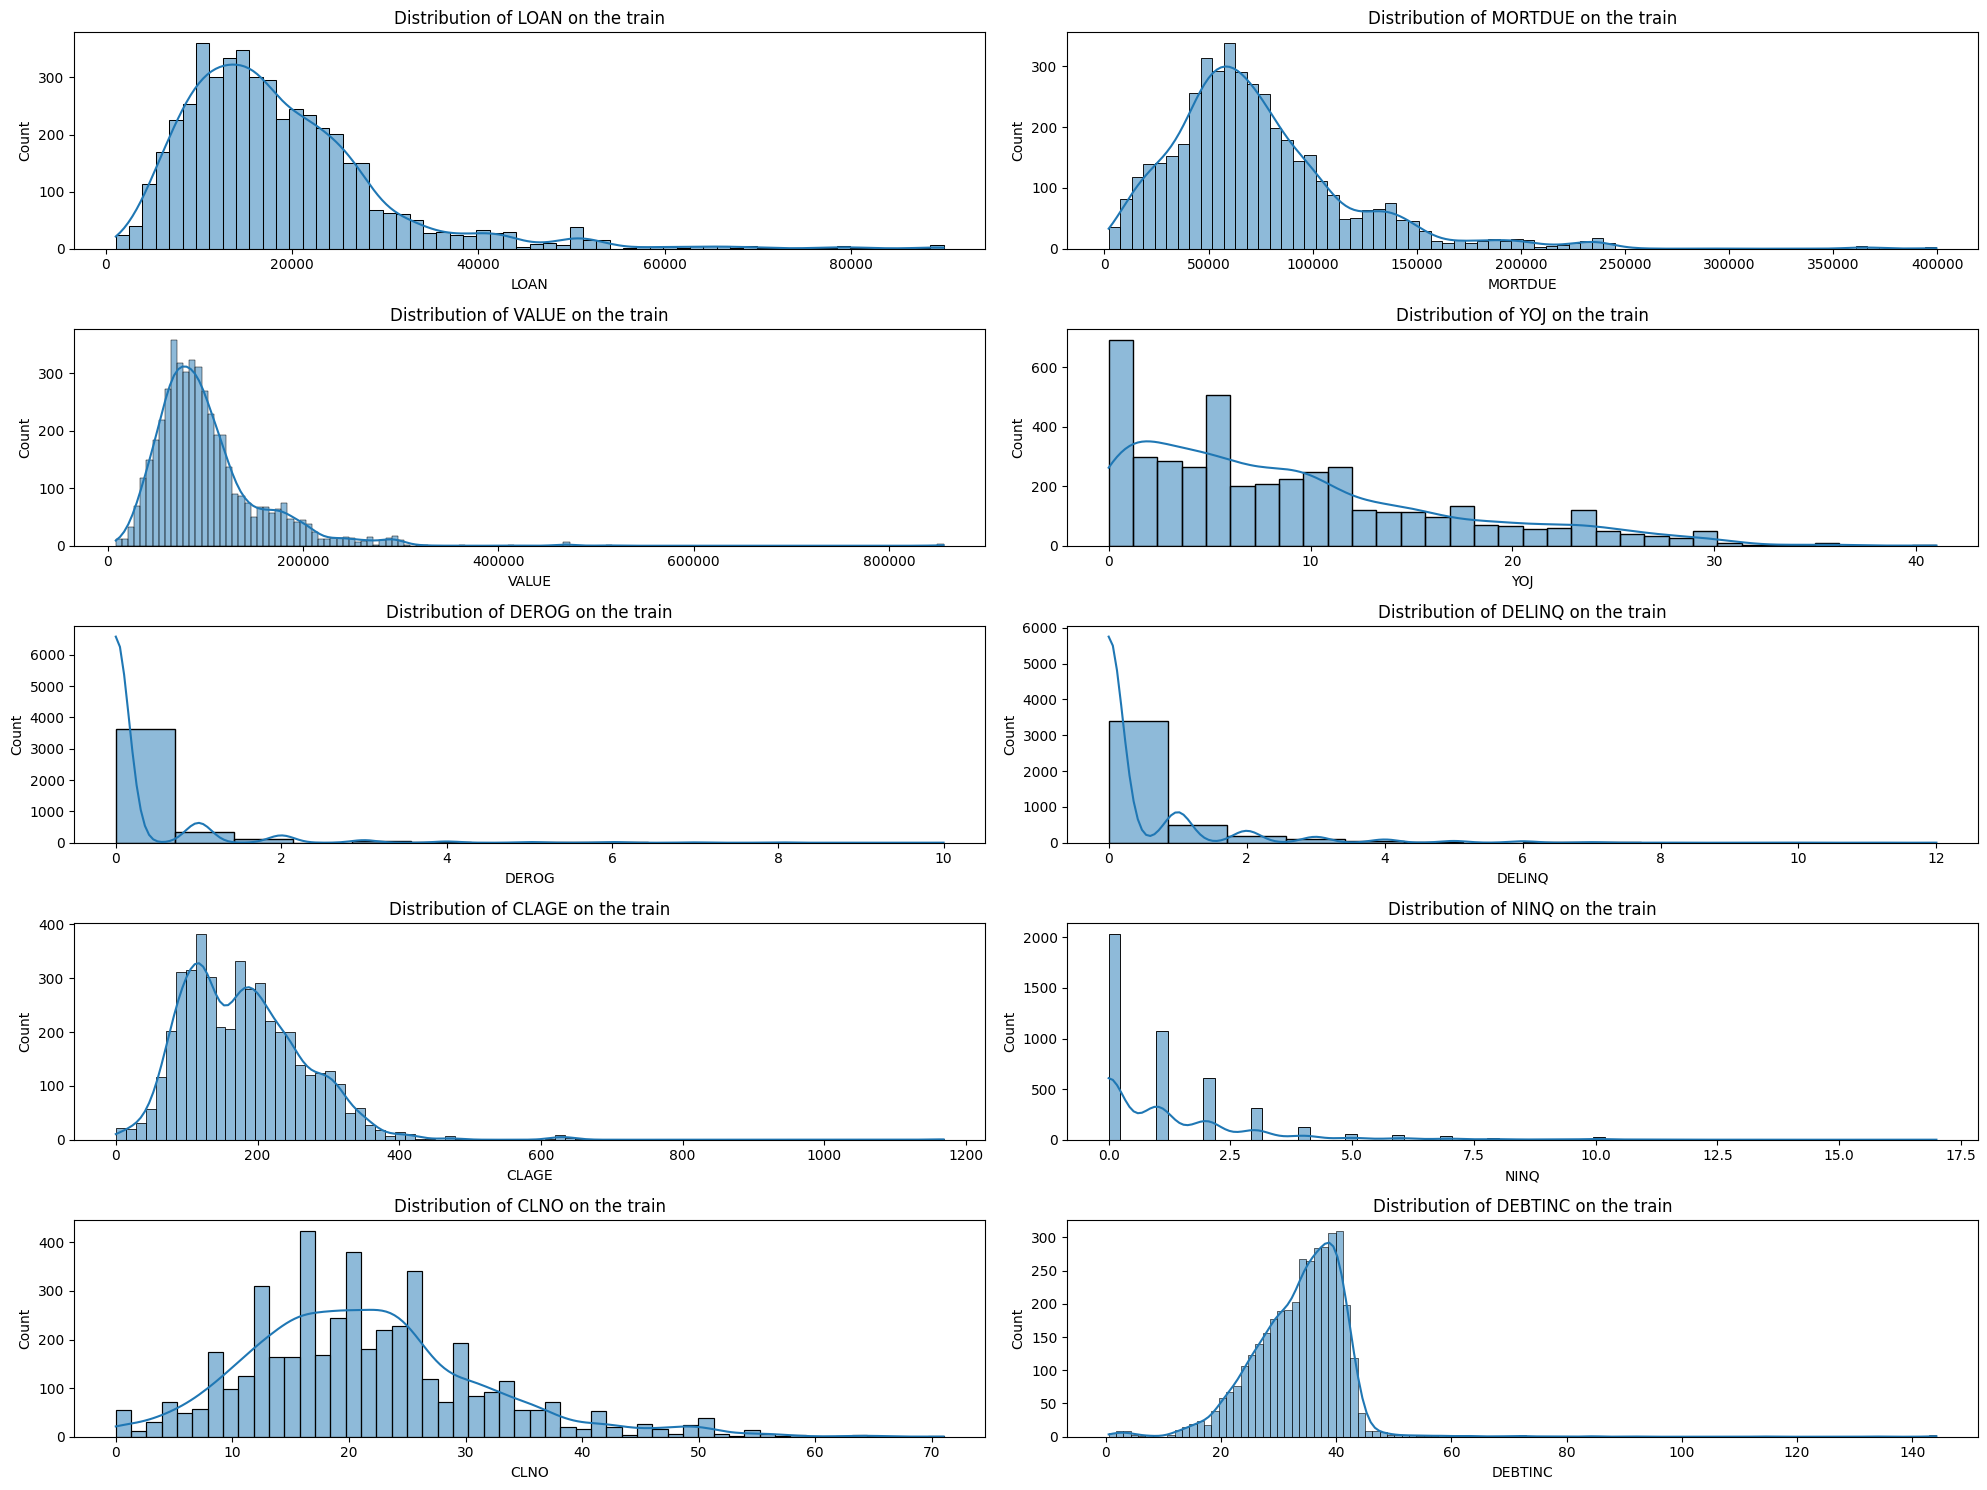

In [143]:
num_col = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO','DEBTINC']
plt.figure(figsize=(20, 15))
for i, col in enumerate(num_col):
    plt.subplot(5, 2, i+1)
    sns.histplot(X_train[col], kde = True)
    plt.title(f'Distribution of {col} on the train')

plt.tight_layout()
plt.show()

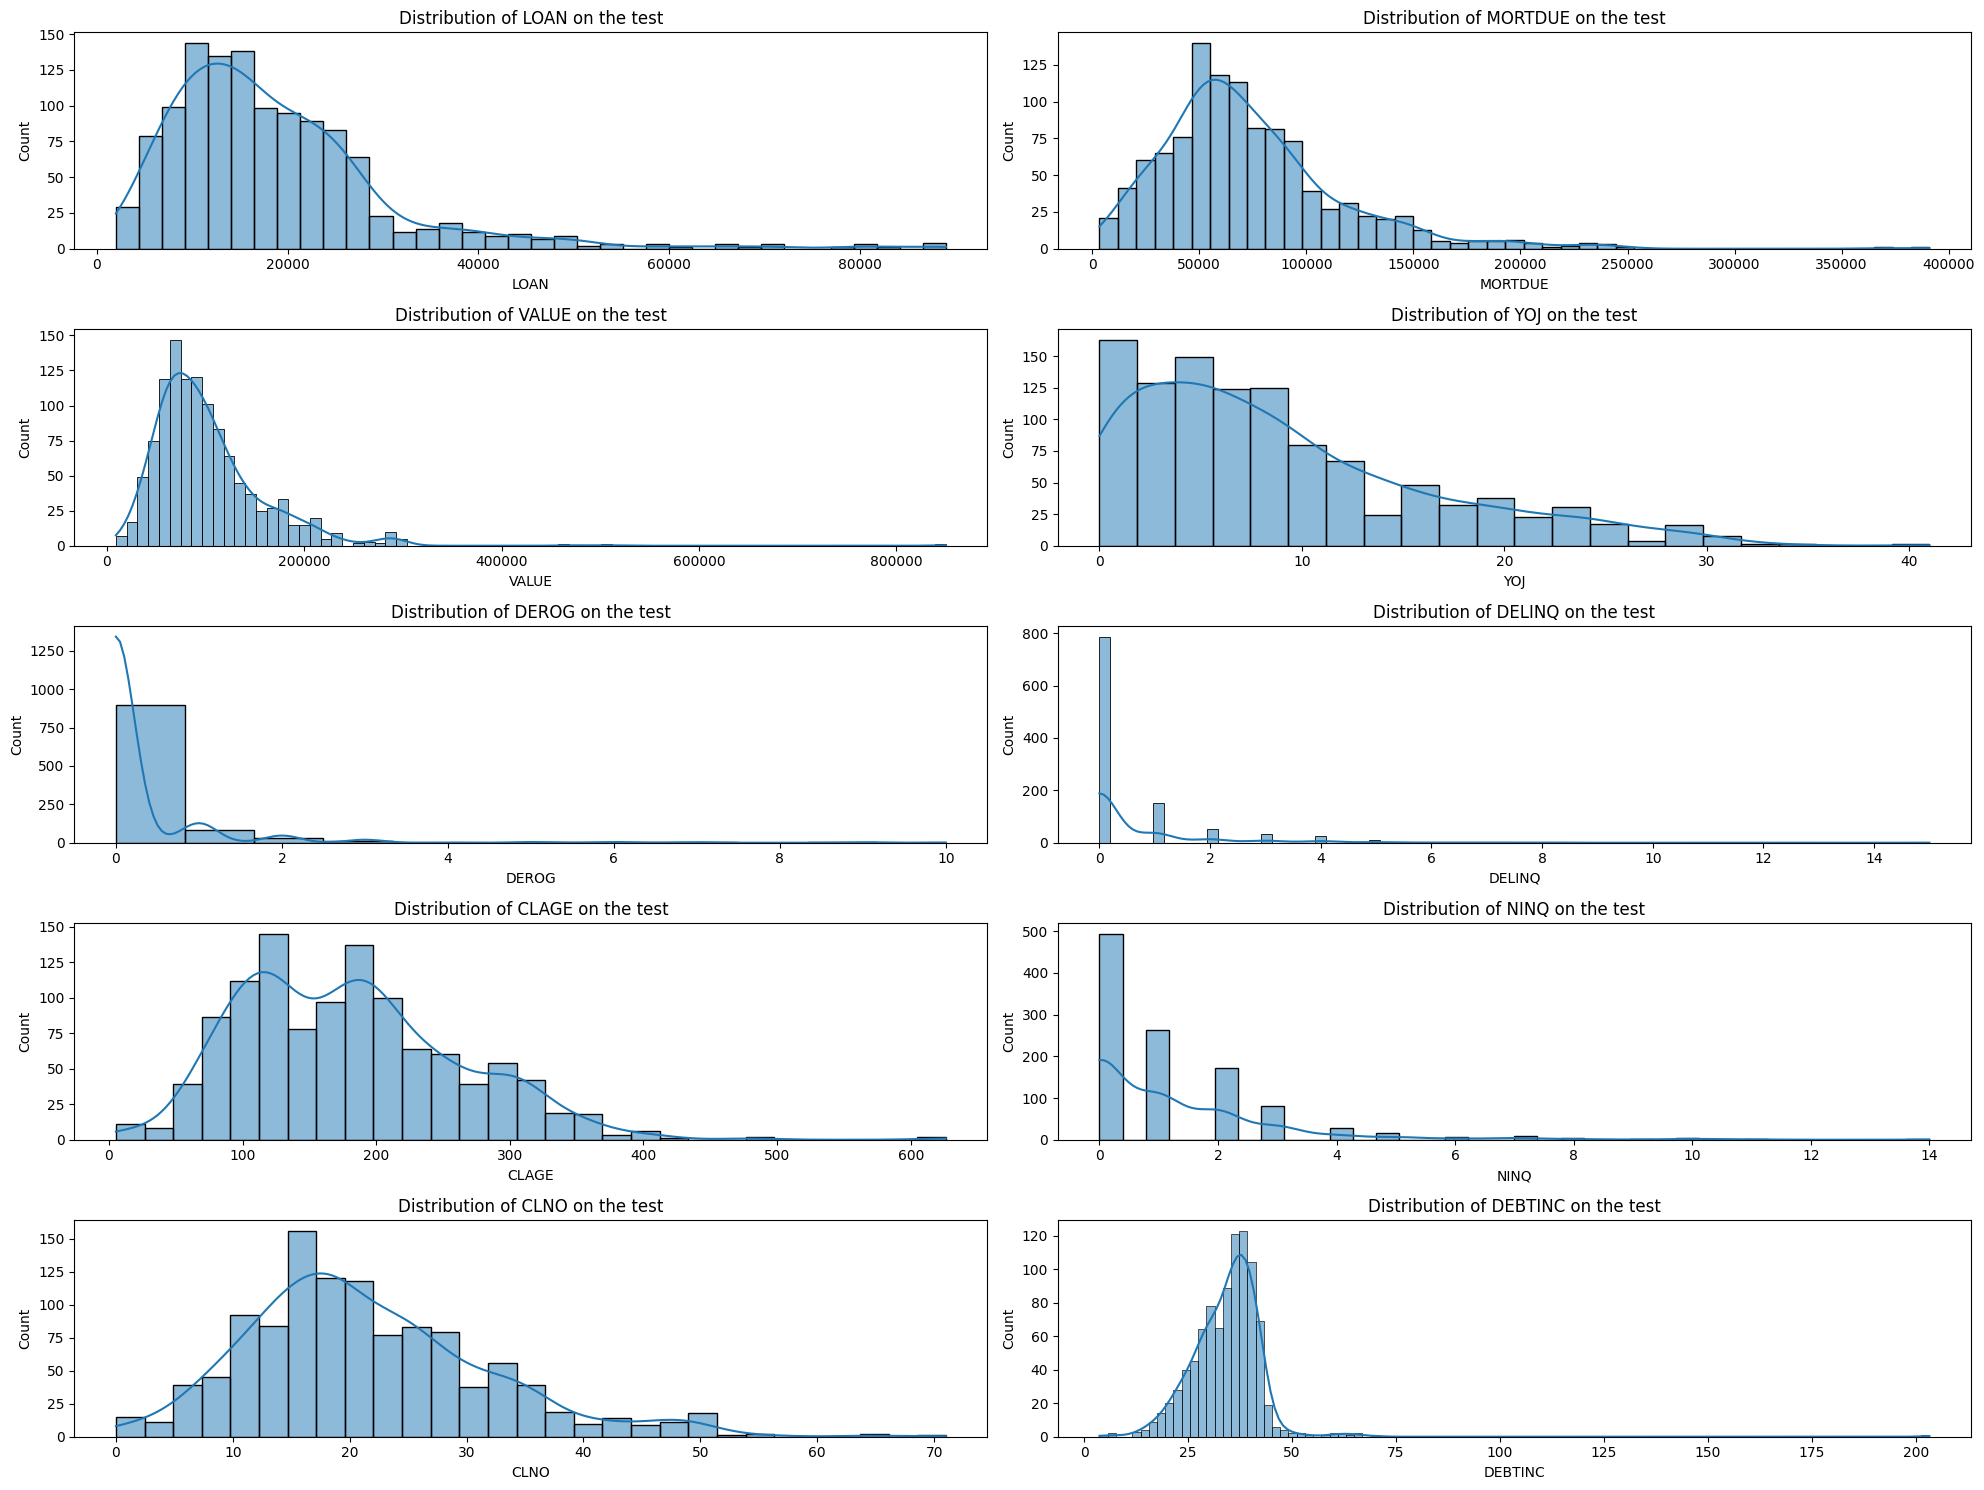

In [144]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(num_col):
    plt.subplot(5, 2, i+1)
    sns.histplot(X_test[col], kde = True)
    plt.title(f'Distribution of {col} on the test')

plt.tight_layout()
plt.show()

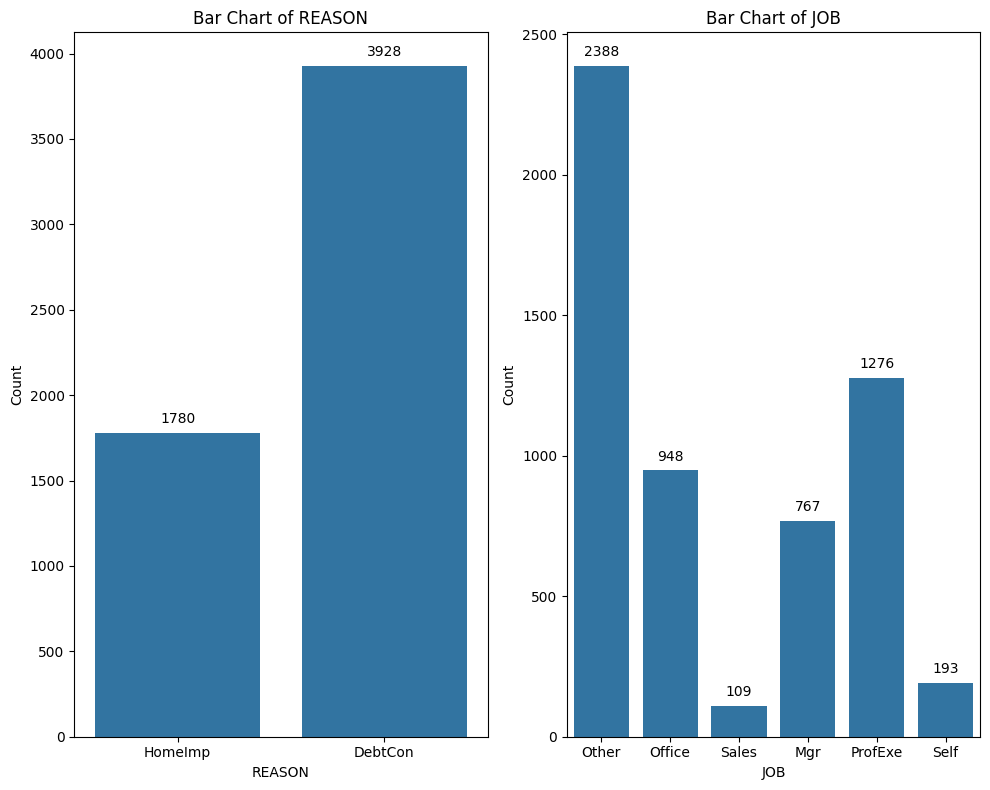

In [145]:
# Barchart cho biến phân loại
cate_columns = ['REASON', 'JOB']
plt.figure(figsize=(10, 8))
for i, col in enumerate(cate_columns):
    plt.subplot(1, len(cate_columns), i+1)
    ax = sns.countplot(data=data, x=col)
    plt.title(f'Bar Chart of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 10),
                    textcoords = 'offset points')

plt.tight_layout()
plt.show()

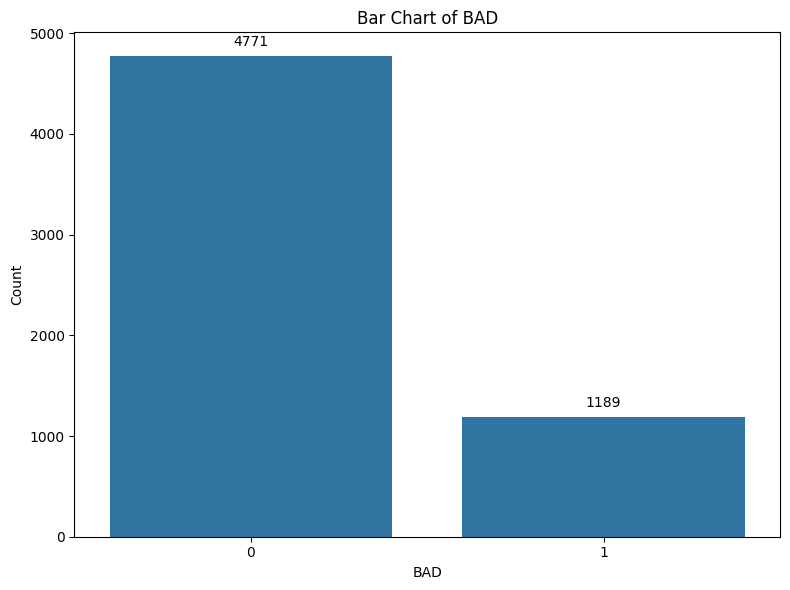

In [146]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=data, x='BAD')
plt.title('Bar Chart of BAD')
plt.xlabel('BAD')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')

plt.tight_layout()
plt.show()

<p>Kết luận: Qua sự phân bố của các trường có thể thấy rằng: </p>
<p>+ Hầu như các trường dữ liệu dạng numeric đều không theo phân phối chuẩn</p>
<p>+ Các trường dữ liệu dạng category đều có sự chênh lệch đang kể về sự phân phối của các giá trị</p>
<p>+ Các trường dữ liệu dạng numeric đều có thiên hướng lệch phải trên cả tập train và tập test


<h3>Correlation between variables

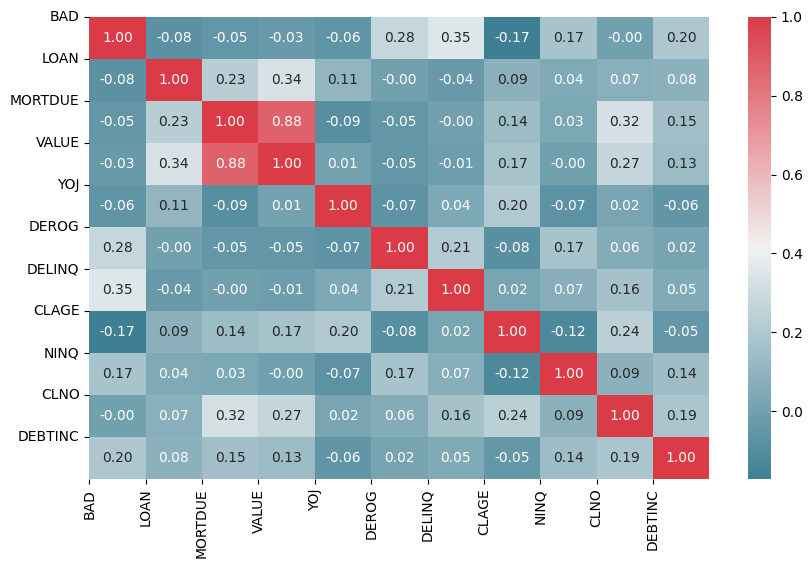

In [147]:
numeric_col = data.select_dtypes(include='number')
corr = data[numeric_col.columns].corr()
fig, ax = plt.subplots(figsize=(10,6))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()


In [148]:
def variable_with_target(data):
    # Create subplots for bar plots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
    fig.suptitle("Relationships between 'BAD' and Different Features", fontsize=16)

    # Bar plot for 'REASON'
    REASON=pd.crosstab(data['REASON'],data['BAD'])
    REASON.div(REASON.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, title='REASON vs BAD', ax = axes[0,0])

    # Bar plot for 'JOB'
    JOB=pd.crosstab(data['JOB'],data['BAD'])
    JOB.div(JOB.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, title='JOB vs BAD', ax = axes[0,1])

    # Bar plot for 'DEROG'
    DEROG=pd.crosstab(data['DEROG'],data['BAD'])
    DEROG.div(DEROG.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, title='DEROG vs BAD', ax = axes[1,0])

    # Bar plot for 'DELINQ'
    DELINQ=pd.crosstab(data['DELINQ'],data['BAD'])
    DELINQ.div(DELINQ.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, title='DELINQ vs BAD', ax = axes[1,1])

    # Bar plot for 'NINQ'
    NINQ=pd.crosstab(data['NINQ'],data['BAD'])
    NINQ.div(NINQ.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, title='NINQ vs BAD', ax = axes[2,0])

    # Bar plot for 'DEBTINC'
    bins=[0,40,100,204] 
    group=['Low','Average','High'] 
    dfWithBin = pd.DataFrame()
    dfWithBin['DEBTINC_bin']=pd.cut(data['DEBTINC'],bins,labels=group)
    LOAN_bin=pd.crosstab(dfWithBin['DEBTINC_bin'],data['BAD'])
    LOAN_bin.div(LOAN_bin.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True,title='DEBTINC vs BAD', ax = axes[2,1])
    plt.xlabel('DEBTINC')

    # Adjust layout and display plots
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

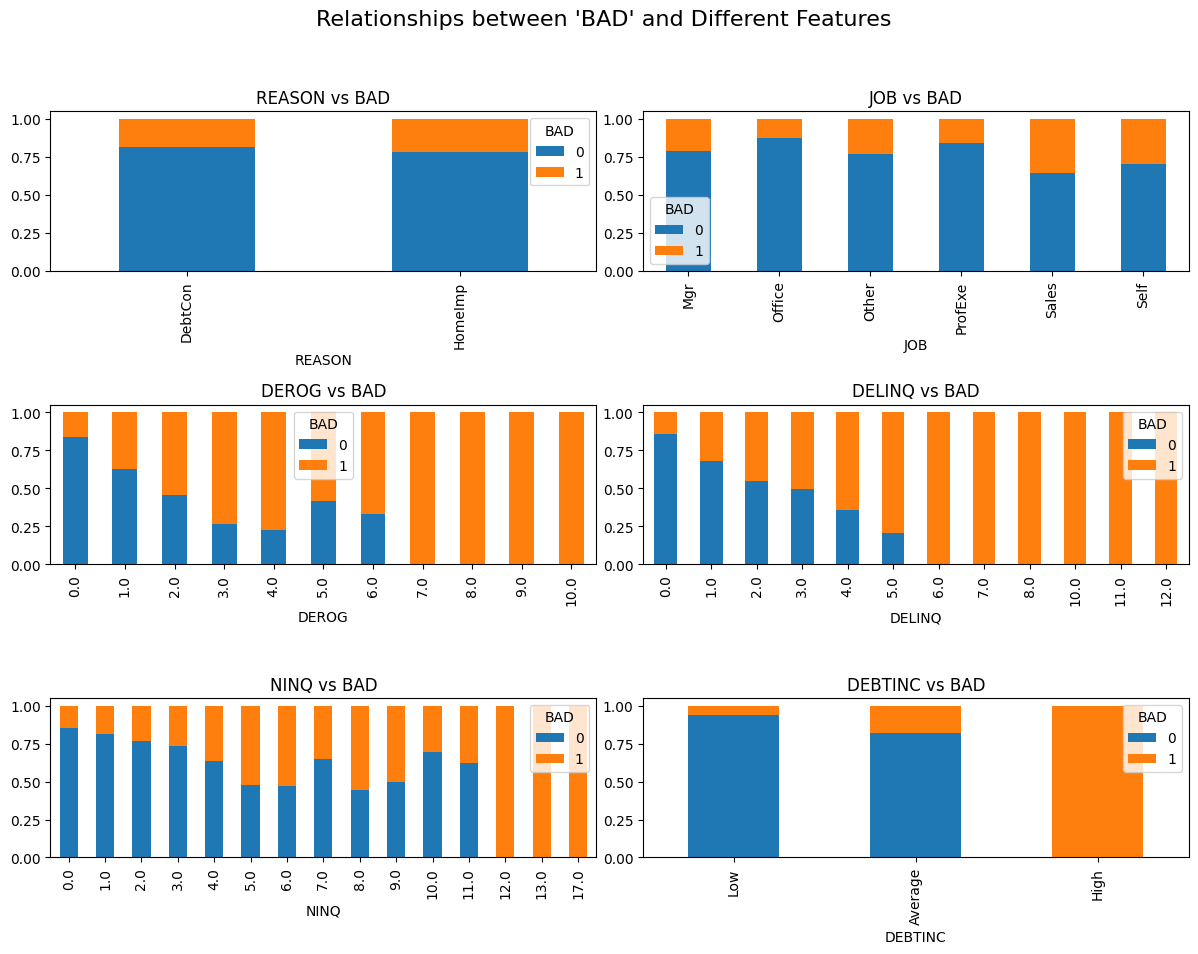

In [149]:
data_corr = X_train.copy()
data_corr["BAD"] = y_train
variable_with_target(data_corr)

<h5>Nhận xét: Đồ thị bên trên biểu diễn sự phụ thuộc của biến dự đoán vào các biến có tính tương quan cao với biến dự đoán: REASON, JOB, DEROG, DELINQ, NINQ, DEBTINC.</h5>
<p>+ Tỉ lệ vỡ nợ do HomeImp (sửa sang nhà cửa) cao hơn tỉ lệ vỡ nợ do DebtCon (vay ghép nợ)
<p>+ Tỉ lệ vỡ nợ do làm công việc Sales cao nhất và tỉ lệ vỡ nợ khi làm các công việc Office là thấp nhất
<p>+ Với số lượng báo cáo vỡ nợ càng nhiều thì khả năng vỡ nợ càng lớn. Và khi số lượng báo cáo vỡ nợ đạt ngưỡng 7 báo cáo trở nên thì khả năng vỡ nợ có thể lên tới 100%
<p>+ Với số hạn mức tín dụng quá hạn càng nhiều thì khả năng vỡ nợ càng lớn. Và khi số hạn mức tín dụng quá hạn đạt ngưỡng 6 trở lên thì khả năng vỡ nợ có thể lên tới 100%
<p>+ Với số lượng yêu cầu tín dụng càng nhiều thì dường như khả năng vỡ nợ càng lớn. Và khi số lượng yêu cầu tín dụng đạt ngưỡng 12 trở lên thì khả năng vỡ nợ có thể lên tới 100%
<p>+ Tỉ lệ (nợ/thu nhập) càng lớn, tức là số tiền nợ hàng tháng phải trả quá cao so với mức lương thu nhập thì khả năng xảy ra vỡ nợ càng cao. Và nếu tỉ lệ này vượt quá 100% thì khả năng vỡ nợ gần như là 100%

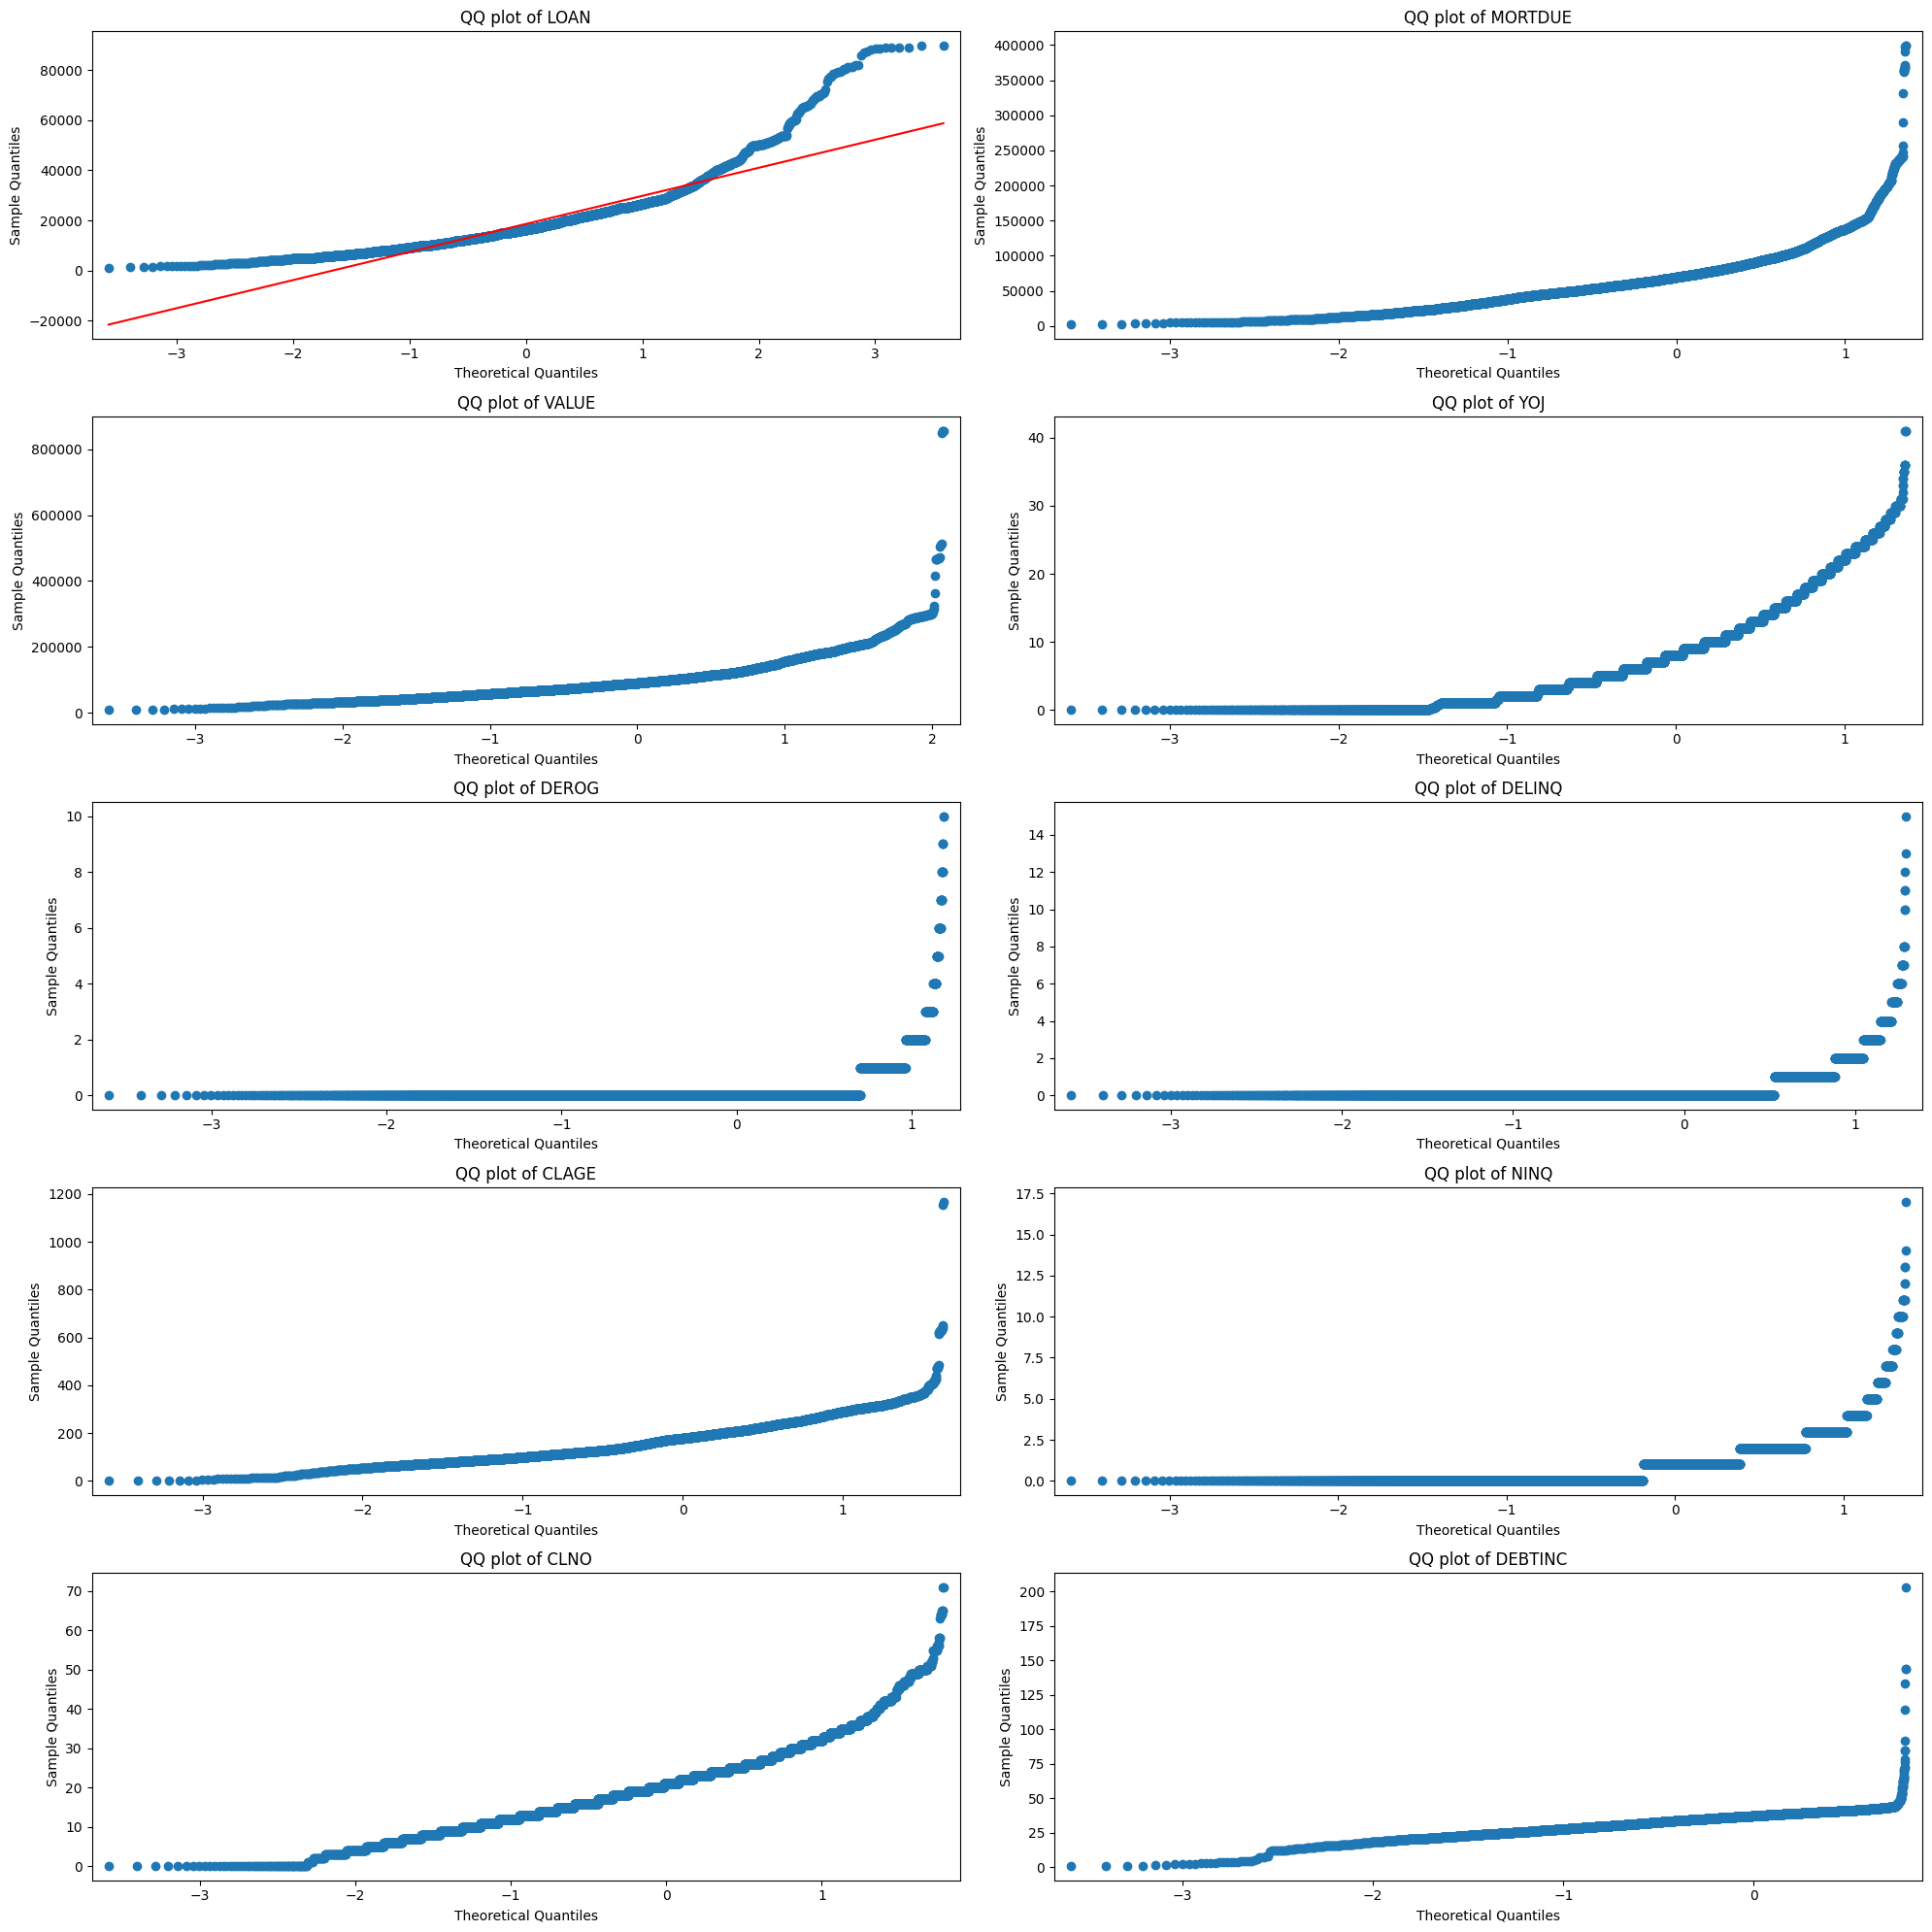

In [150]:
import statsmodels.api as sm
plt.figure(figsize=(20,20))
for i, col in enumerate(num_col):
    plt.subplot(5, 2, i+1)
    sm.qqplot(data[col], line='s', ax=plt.gca())
    plt.title(f'QQ plot of {col}')
plt.tight_layout()
plt.show()

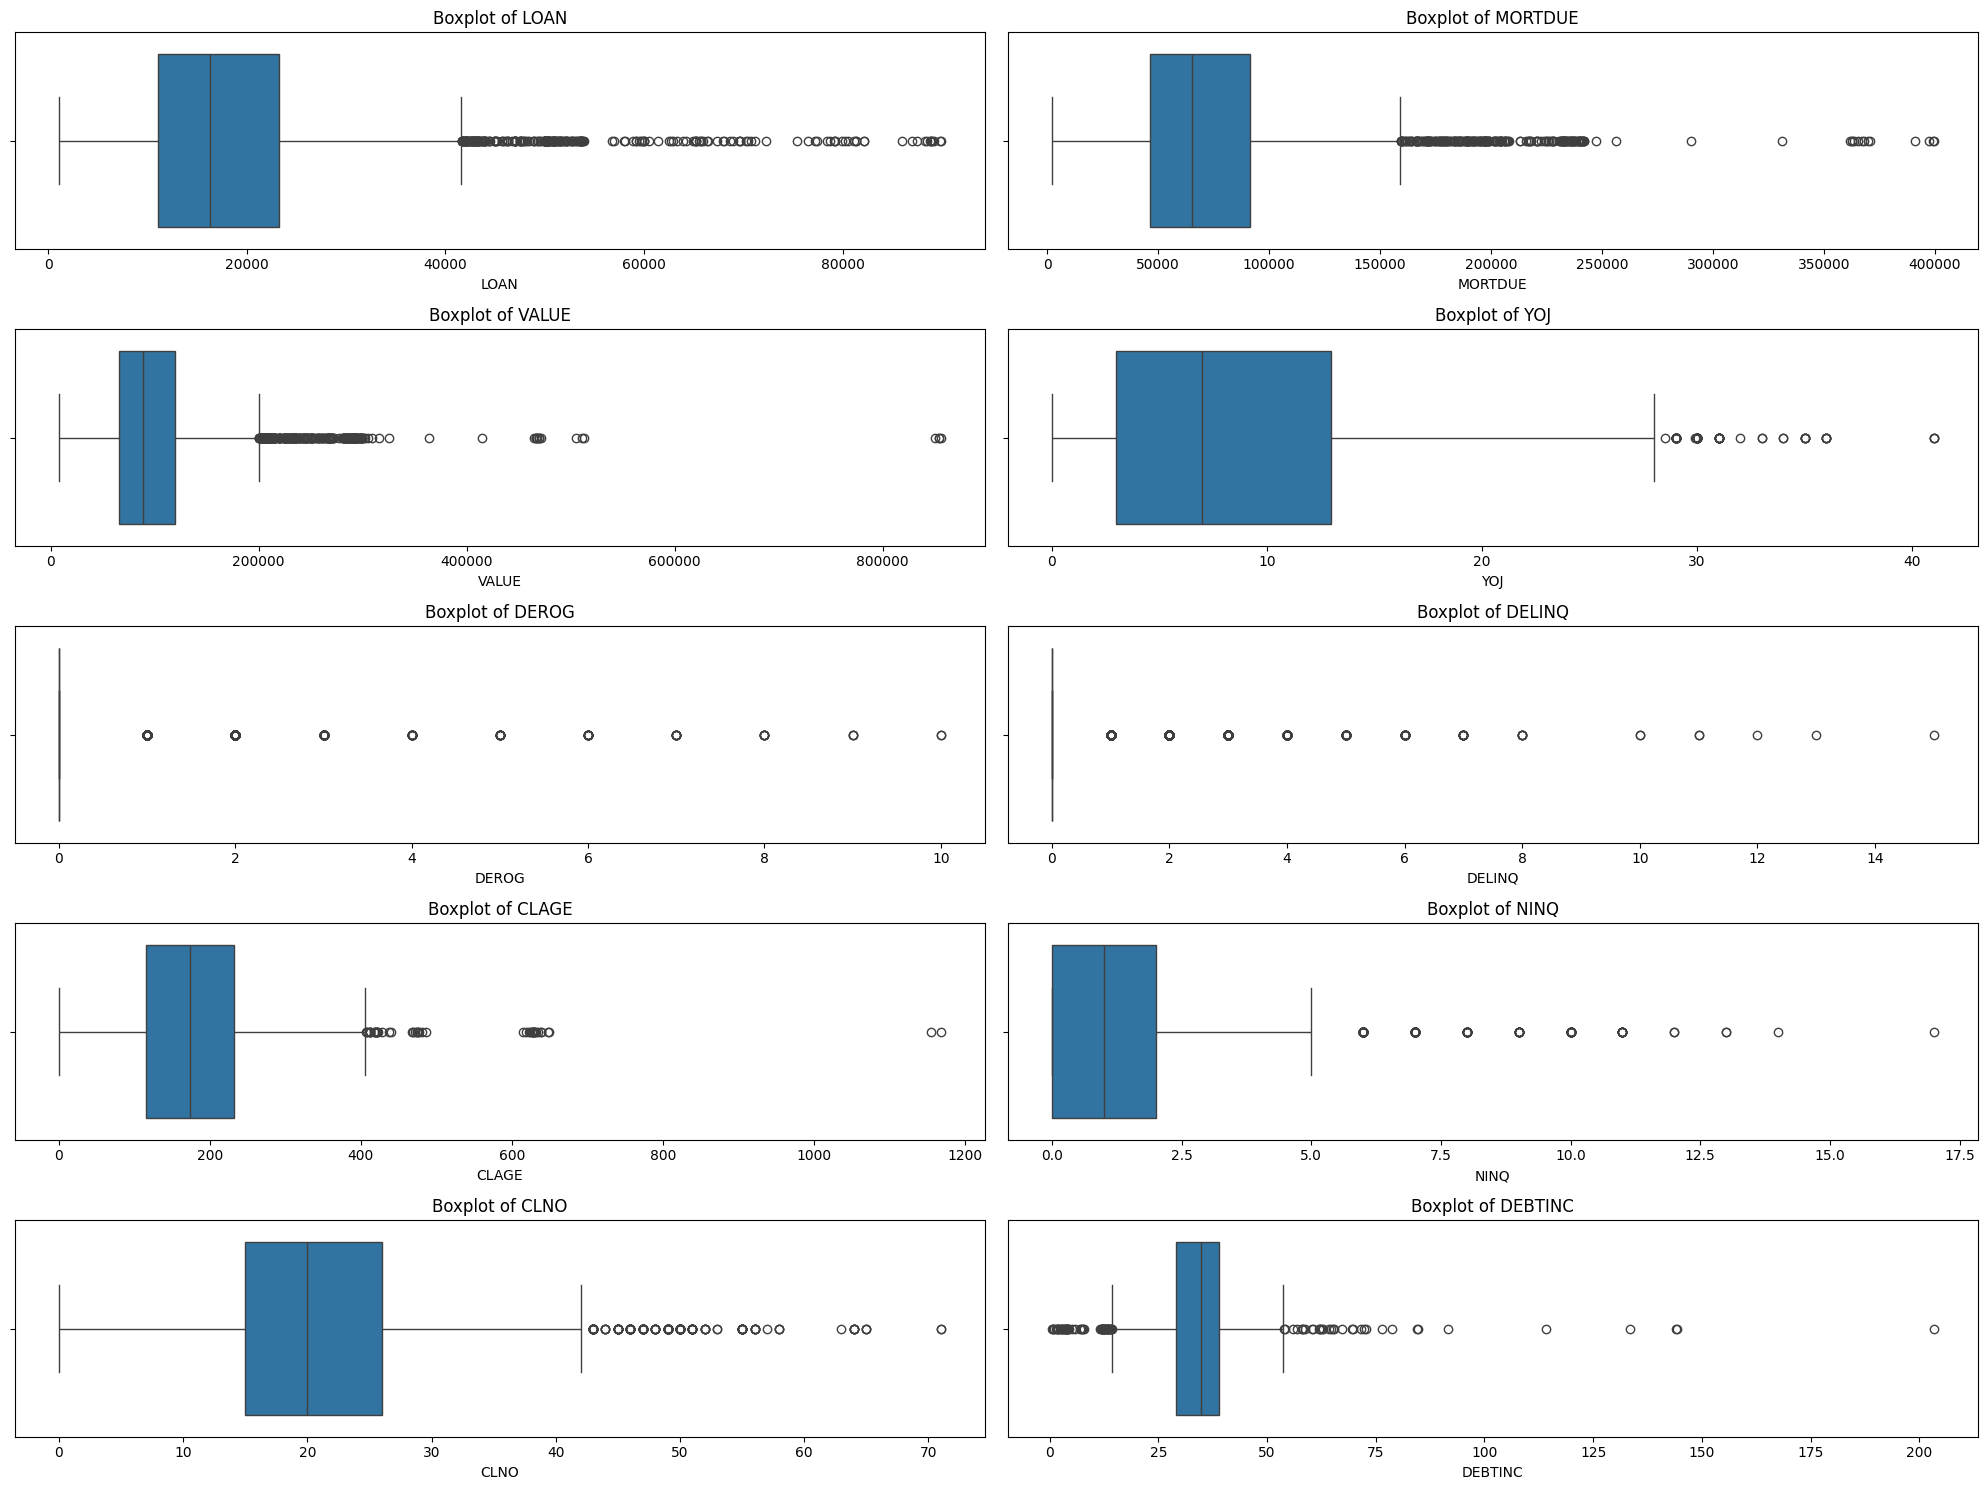

In [151]:
# Box plot: IQR và các điểm ngoại lai
plt.figure(figsize=(20, 15))
for i, col in enumerate(num_col):
    plt.subplot(5, 2, i+1)
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

<h3>Data Preprocessing</h3>

In [159]:
# Hàm thay thế các giá trị Nan trong các trường dữ liệu
def inplace_nan_1(x, y, REASON_OTHERS):
    for column in x.columns[1:]:
        if x[column].dtype == 'object':
            if REASON_OTHERS == True and column == 'REASON':
                # Thay thế các giá trị Nan trong trường "REASON" với giá trị "Other reason"
                x.fillna("Other")
            else:
                # Với record có target là 0 sẽ fillna với giá trị xuất hiện nhiều nhất của các record có target = 0
                # Với record có target là 1 sẽ fillna với giá trị xuất hiện nhiều nhất của các record có target = 1
                x.loc[(x[column].isna()) & (y == 0), column] = x[y == 0][column].value_counts().idxmax()
                x.loc[(x[column].isna()) & (y == 1), column] = x[y == 1][column].value_counts().idxmax()
            
        else:
            # Vì trong các trường dữ liệu số đều có giá trị outlier nên sẽ thay thế bởi giá trị median
            # Với record có target là 0 sẽ fillna với giá trị median của các record có target = 0
            # Với record có target là 1 sẽ fillna với giá trị median của các record có target = 1
            x.loc[(x[column].isna()) & (y == 0), column] = round(x[y == 0][column].median(), 0)
            x.loc[(x[column].isna()) & (y == 1), column] = round(x[y == 1][column].median(), 0)

def inplace_nan_2(x, y):
    # Combine X and Y into a single DataFrame
    data = pd.concat([x, y], axis=1)
    
    # Numerosity Reduction, with a threshold of 3 null values
    data.dropna(axis=0, thresh=3, inplace=True)
    
    # Filling the rest of the null values using interpolated values
    data = data.interpolate()
    
    # Fill NaN in object columns with mode, and in numeric columns with median
    for column in data.columns[data.isnull().any()].tolist():
        if data[column].dtype == 'object':
            data[column] = data[column].fillna(data[column].mode().iloc[0])
        else:
            data[column] = data[column].fillna(data[column].median(), inplace=True)
    
    # Split back into X and Y
    x = data.iloc[:, :len(x.columns)]
    y = data.iloc[:, len(x.columns):]
    
    return x, y

            
def inplace_nan_3(x, y):
    # Fill specific columns with predefined values
    x["REASON"] = x["REASON"].fillna(value="DebtCon")
    x["JOB"] = x["JOB"].fillna(value="Other")
    
    # Fill numeric columns with their median values
    x["DEROG"] = x["DEROG"].fillna(value=0)
    x["DELINQ"] = x["DELINQ"].fillna(value=0)
    
    # Fill remaining NaNs with mean values for numeric columns
    numeric_columns = x.select_dtypes(include=['number']).columns
    x[numeric_columns] = x[numeric_columns].fillna(x[numeric_columns].mean())

    return x, y





In [155]:
# Remove outlier
def remove_outlier_IQR(x, y, columns):
    df = pd.concat([x, y], axis=1)
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask = ((df[columns] < (Q1 - 1.5 * IQR)) | (df[columns] > (Q3 + 1.5 * IQR))).any(axis=1)
    df_final = df[~outlier_mask]

    x = df_final.iloc[:, :len(x.columns)]
    y = df_final.iloc[:, len(x.columns):]

    return x, y

<h3>Standardized data</h3>

In [156]:
def preprocess_standard(X, y, index, save): 

  scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
  scaled_features = scaler.fit_transform(X)

  scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
  if save:
    pickle.dump(scaler, open(f'./standard/StandardScaler{index}.pkl', 'wb'))
  return scaled_features_df,y

def preprocess_min_max(X, y, index, save):

  scaler = MinMaxScaler()
  scaled_features = scaler.fit_transform(X)

  scaled_features_df = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
  if save:
    pickle.dump(scaler, open(f'./standard/MinMaxScaler{index}.pkl', 'wb'))
  return scaled_features_df,y

<p>TH1: Loại bỏ các record có nhiều hơn 4 giá trị Nan, sau đó thay thế các giá trị Nan bằng giá trị nội suy. Những giá trị không được thay thế thì:
<p>+ Với giá trị phân loại: thay thế bằng giá trị xuất hiện nhiều nhất
<p>+ Với giá trị số: thay thế bằng giá trị median
<p>Sau đó OnehotEncoder những trường chứa giá trị phân loại
<p>Chuẩn hóa dữ liệu theo pp StandardScaler or MinMaxScaler

In [160]:
X_train_1, X_test_1, y_train_1, y_test_1 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [161]:
# Thay thế các giá trị Nan
X_train_1, y_train_1 = inplace_nan_2(X_train_1, y_train_1)
X_test_1, y_test_1 = inplace_nan_2(X_test_1, y_test_1)

# OnehotEncoder
X_train_1 = pd.get_dummies(X_train_1, columns=['REASON', 'JOB'])
X_test_1 = pd.get_dummies(X_test_1, columns=['REASON', 'JOB'])


# Chuẩn hóa dữ liệu theo pp StandardScaler
X_train_1, y_train_1 = preprocess_standard(X_train_1, y_train_1, 1, True)
X_test_1, y_test_1 = preprocess_standard(X_test_1, y_test_1, 1, True)

C:\Users\Le Phuong\AppData\Local\Temp\ipykernel_11032\3064694700.py:29: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate()
C:\Users\Le Phuong\AppData\Local\Temp\ipykernel_11032\3064694700.py:29: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data = data.interpolate()


<p>TH2: 
<p>+ Với giá trị phân loại: thay thế bằng giá trị xuất hiện nhiều nhất ứng với target tương ứng
<p>+ Với giá trị số: thay thế bằng giá trị median của các record có target tương ứng
<p>Sau đó OneHotEncoder những trường chứa giá trị phân loại
<p>Cuối cùng tiến hành chuẩn hóa dữ liệu theo pp StandardScaler or MinMaxScaler

In [162]:
X_train_2, X_test_2, y_train_2, y_test_2 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [163]:
# Thay thế các giá trị Nan
inplace_nan_1(X_train_2, y_train_2, False)
inplace_nan_1(X_test_2, y_test_2, False)
# OnehotEncoder
X_train_2 = pd.get_dummies(X_train_2, columns=['REASON', 'JOB'])
X_test_2 = pd.get_dummies(X_test_2, columns=['REASON', 'JOB'])
# Chuẩn hóa dữ liệu theo pp StandardScaler
x_train_2, y_train_2 = preprocess_standard(X_train_2, y_train_2, 2, True)
x_test_2, y_test_2 = preprocess_standard(X_test_2, y_test_2, 2, False)

<p>TH3: 
<p>+ Với giá trị phân loại: thay thế bằng giá trị xuất hiện nhiều nhất ứng với target tương ứng (trừ REASON). Nếu là trường REASON sẽ thay thế bằng giá trị "Other"
<p>+ Với giá trị số: thay thế bằng giá trị median của các record có target tương ứng
<p>Sau đó OneHotEncoder những trường chứa giá trị phân loại
<p>Cuối cùng tiến hành chuẩn hóa dữ liệu theo pp StandardScaler or MinMaxScaler

In [166]:
X_train_3, X_test_3, y_train_3, y_test_3 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [167]:
# Thay thế các giá trị Nan
inplace_nan_1(X_train_3, y_train_3, True)
inplace_nan_1(X_test_3, y_test_3, True)
# OnehotEncoder
X_train_3 = pd.get_dummies(X_train_3, columns=['REASON', 'JOB'])
X_test_3 = pd.get_dummies(X_test_3, columns=['REASON', 'JOB'])

# Chuẩn hóa dữ liệu theo pp StandardScaler
x_train_3, y_train_3 = preprocess_standard(X_train_3, y_train_3, 3, True)
x_test_3, y_test_3 = preprocess_standard(X_test_3, y_test_3, 3, False)

In [168]:
X_train_3

LOAN  MORTDUE     VALUE   YOJ  DEROG  DELINQ       CLAGE  NINQ  CLNO  \
944    9100  62976.0   77829.0   0.0    0.0     2.0  131.193496   0.0  23.0   
5755  43800   5884.0   64890.0   7.0    0.0     0.0  309.827548   0.0  19.0   
2259  13800  75142.0   95667.0  19.0    0.0     0.0  230.457554  10.0  24.0   
12     2000  45000.0   55000.0   3.0    0.0     0.0   86.066667   2.0  25.0   
1117   9900  47367.0  114837.0   4.0    0.0     0.0  210.435534   0.0  10.0   
...     ...      ...       ...   ...    ...     ...         ...   ...   ...   
3772  20000  99300.0  139150.0  10.0    0.0     0.0  162.366667   1.0  23.0   
5191  28000  49764.0   74526.0  24.0    0.0     1.0  294.594783   1.0  30.0   
5226  28300  71973.0  119224.0   4.0    0.0     0.0   89.379952   2.0  32.0   
5390  31100  73386.0  108864.0   5.0    0.0     0.0  119.539518  10.0  21.0   
860    8700  77930.0   80164.0  20.0    0.0     0.0  350.528410   1.0  47.0   

        DEBTINC  REASON_DebtCon  REASON_HomeImp  JOB_Mgr  JOB_Office  \
944   26.090419           False            True     True       False   
5755  16.160451           False            True    False        True   
2259  33.383314            True           False     True       False   
12    38.000000           False            True    False       False   
1117  25.042109            True           False    False       False   
...         ...             ...             ...      ...         ...   
3772  34.000000           False            True    False       False   
5191  37.611309            True           False    False       False   
5226  39.981059            True           False    False       False   
5390  42.826601           False            True    False       False   
860   29.662360           False            True    False       False   

      JOB_Other  JOB_ProfExe  JOB_Sales  JOB_Self  
944       False        False      False     False  
5755      False        False      False     False  
2259      False        False      False     False  
12         True        False      False     False  
1117      False         True      False     False  
...         ...          ...        ...       ...  
3772      False         True      False     False  
5191       True        False      False     False  
5226       True        False      False     False  
5390       True        False      False     False  
860        True        False      False     False  

[4768 rows x 18 columns]

<p>TH4:
<p>+ Với giá trị phân loại: thay thế bằng giá trị xuất hiện nhiều nhất
<p>+ Với giá trị số: thay thế bằng giá trị mean của trường dữ liệu tương ứng
<p>Sau đó OneHotEncoder những trường chứa giá trị phân loại
<p>Cuối cùng tiến hành chuẩn hóa dữ liệu theo pp StandardScaler or MinMaxScaler

In [169]:
X_train_4, X_test_4, y_train_4, y_test_4 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [170]:
# Thay thế các giá trị Nan
inplace_nan_3(X_train_4, y_train_4)
inplace_nan_3(X_test_4, y_test_4)
# OnehotEncoder
X_train_4 = pd.get_dummies(X_train_4, columns=['REASON', 'JOB'])
X_test_4 = pd.get_dummies(X_test_4, columns=['REASON', 'JOB'])
# Chuẩn hóa dữ liệu theo pp StandardScaler
X_train_4, y_train_4 = preprocess_standard(X_train_4, y_train_4, 4, True)
X_test_4, y_test_4 = preprocess_standard(X_test_4, y_test_4, 4, False)

<p>TH5:
<p>+ Với giá trị phân loại: thay thế bằng giá trị xuất hiện nhiều nhất
<p>+ Với giá trị số: thay thế bằng giá trị mean của trường dữ liệu tương ứng
<p>Loại bỏ trường dữ liệu "MORTDUE"
<p>OneHotEncoder những trường chứa giá trị phân loại
<p>Chuẩn hóa dữ liệu theo pp StandardScaler or MinMaxScaler

In [171]:
X_train_5, X_test_5, y_train_5, y_test_5 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [172]:
# Loại bỏ trường dữ liệu MORTDUE
X_train_5.drop(['MORTDUE'], axis=1, inplace=True)
X_test_5.drop(['MORTDUE'], axis=1, inplace=True)
# Thay thế các giá trị Nan
inplace_nan_3(X_train_5, y_train_5)
inplace_nan_3(X_test_5, y_test_5)
# OnehotEncoder
X_train_5 = pd.get_dummies(X_train_5, columns=['REASON', 'JOB'])
X_test_5 = pd.get_dummies(X_test_5, columns=['REASON', 'JOB'])
# Chuẩn hóa dữ liệu theo pp StandardScaler
x_train_5, y_train_5 = preprocess_standard(X_train_5, y_train_5, 5, True)
x_test_5, y_test_5 = preprocess_standard(X_test_5, y_test_5, 5, False)

<p>TH6:
<p>+ Với giá trị phân loại: thay thế bằng giá trị xuất hiện nhiều nhất
<p>+ Với giá trị số: thay thế bằng giá trị mean của trường dữ liệu tương ứng
<p>OneHotEncoder những trường chứa giá trị phân loại
<p>Chuẩn hóa dữ liệu theo pp StandardScaler or MinMaxScaler

In [173]:
X_train_6, X_test_6, y_train_6, y_test_6 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [174]:
# Thay thế các giá trị Nan
inplace_nan_3(X_train_6, y_train_6)
inplace_nan_3(X_test_6, y_test_6)
# OnehotEncoder
X_train_6 = pd.get_dummies(X_train_6, columns=['REASON', 'JOB'])
X_test_6 = pd.get_dummies(X_test_6, columns=['REASON', 'JOB'])
# Đưa các trường dữ liệu về phân phối chuẩn
x_train_6, y_train_6 = preprocess_min_max(X_train_6, y_train_6, 6, True)
x_test_6, y_test_6 = preprocess_min_max(X_test_6, y_test_6, 6, False)

<p>TH7:
<p>+ Tách 2 trường dữ liệu REASON và JOB thành các cột
<p>+ Loại bỏ cột DEBTINC do có quá nhiều giá trị missing
<p>+ Loại bỏ các hàng mà có bất kì giá trị missing nào
<p>OneHotEncoder những trường chứa giá trị phân loại
<p>Chuẩn hóa dữ liệu theo StandardScaler or MinMaxScaler

In [175]:
X_train_7, X_test_7, y_train_7, y_test_7 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [176]:
def transform(x, y):
    df = pd.concat([x,y], axis=1)
    df=pd.get_dummies(df, columns=['REASON','JOB'])
    df.drop('DEBTINC', axis=1, inplace=True)
    df.dropna(axis=0, how='any', inplace=True)
    y_trans = df['BAD']
    x_trans = df.drop(['BAD'], axis=1)
    return x_trans, y_trans

In [177]:
X_train_7, y_train_7 = transform(X_train_7, y_train_7)
X_test_7, y_test_7 = transform(X_test_7, y_test_7)

# Chuẩn hóa dữ liệu theo pp StandardScaler
X_train_7, y_train_7 = preprocess_standard(X_train_7, y_train_7, 7, True)
X_test_7, y_test_7 = preprocess_standard(X_test_7, y_test_7, 7, False)

<h3>Tuning model - Hyperparameter

In [201]:
log_param_grid = {
    'solver': ['saga', 'liblinear'],
    'penalty': ['l2', 'l1'],
    'C': [0.001, 0.1, 10, 100, 1000, 10000]
}

dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

rf_param_grid = { 
    'n_estimators':[5,10,15],
    'max_depth':[50,60,70],
    'criterion': ['gini','entropy']
} 

knn_param_grid = { 
    'n_neighbors' : [1,2,3,4,5,6,7,8],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']}

svm_param_grid = {
    'kernel':['rbf'],
    'C':[0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001]}

xgb_param_grid = {
    'max_depth': [3, 5, 7, 9],
    'gamma': [0.1, 0.5, 1.0, 1.5],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10]
}


In [196]:
#ROC plot
from sklearn.metrics import roc_curve, auc
def plot_roc(model, X_test, y_test):
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label='AUC = %0.2f' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC plot for loan defaulter prediction")
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
def plot_confusion_matrix(y, y_pred):
    plt.figure(figsize=(6,4))
    cf_matrix = confusion_matrix(y, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='YlOrRd')
    plt.show()

In [181]:
def model_analysis(model, X_test, y_test, y_pred):
    plot_roc(model, X_test, y_test)
    plot_confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred))

In [182]:
def tuning_hyperparameter_grid(model, param_grid, X_train, y_train):
    clf_grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
    grid = clf_grid.fit(X_train, y_train)
    
    print('Best train: %f using %s' % (grid.best_score_, grid.best_params_))
    return grid.best_estimator_


In [203]:
def build_and_train_model(models, param_grids, X_train, y_train, X_test, y_test, index):
    for i, (model, param_grid) in enumerate(zip(models, param_grids)):
        print(f'Model {i+1}: {type(model).__name__}')
        
        best_model = tuning_hyperparameter_grid(model, param_grid, X_train, y_train)
        train_accuracy = best_model.score(X_train, y_train)
        test_accuracy = best_model.score(X_test, y_test)
        
        y_pred_train = best_model.predict(X_train)
        recall_train = recall_score(y_train, y_pred_train)
        
        y_pred_test = best_model.predict(X_test)
        recall_test = recall_score(y_test, y_pred_test)
        
        print(f'Accuracy on Training Set: {train_accuracy:.4f}')
        print(f'Accuracy on Test Set: {test_accuracy:.4f}')
        print(f'Recall on Training Set: {recall_train:.4f}')
        print(f'Recall on Test Set: {recall_test:.4f}')
        
        # Predict on test set
        y_pred = best_model.predict(X_test)
        
        # Call model_analysis with y_pred
        model_analysis(best_model, X_test, y_test, y_pred)
        
        # Save the model
        model_name = type(best_model).__name__
        with open(f"model/{model_name}{index}.pkl", 'wb') as f:
            pickle.dump(best_model, f)
        
        print("\n\n\n\n")


In [204]:
log_model = LogisticRegression()
dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()
knn_model = KNeighborsClassifier()
svm_model = SVC(probability=True)
xgb_model = XGBClassifier()
    
models = [log_model, dt_model, rf_model, knn_model, svm_model, xgb_model]
param_grids = [log_param_grid, dt_param_grid, rf_param_grid, knn_param_grid, svm_param_grid, xgb_param_grid]


<h3>data1 - GridSearch

Model 1: LogisticRegression
Fitting 5 folds for each of 24 candidates, totalling 120 fits


d:\App\setup_python\python_3_10\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best train: 0.794731 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy on Training Set: 0.8395
Accuracy on Test Set: 0.8070
Recall on Training Set: 0.2969
Recall on Test Set: 0.2491


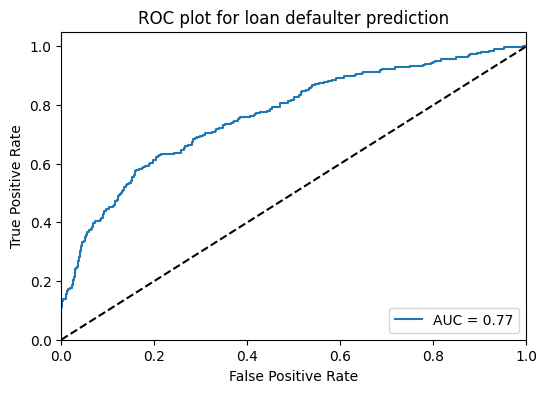

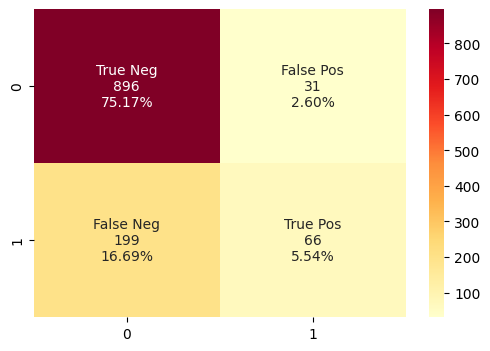

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       927
           1       0.68      0.25      0.36       265

    accuracy                           0.81      1192
   macro avg       0.75      0.61      0.63      1192
weighted avg       0.79      0.81      0.77      1192






Model 2: DecisionTreeClassifier
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best train: 0.806573 using {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2}
Accuracy on Training Set: 0.9278
Accuracy on Test Set: 0.8247
Recall on Training Set: 0.7378
Recall on Test Set: 0.5132


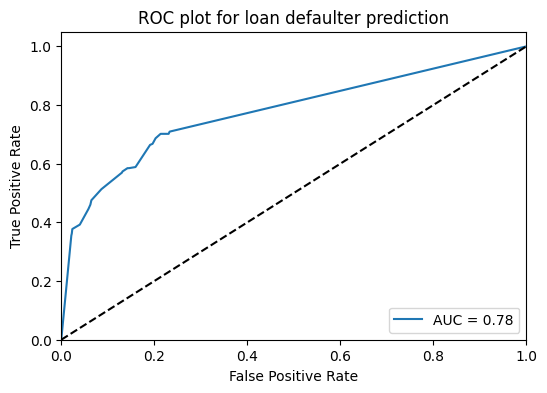

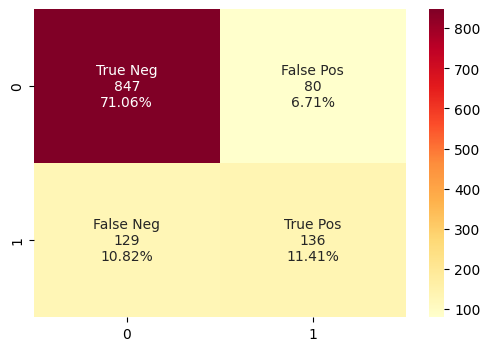

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       927
           1       0.63      0.51      0.57       265

    accuracy                           0.82      1192
   macro avg       0.75      0.71      0.73      1192
weighted avg       0.81      0.82      0.82      1192






Model 3: RandomForestClassifier
Fitting 5 folds for each of 18 candidates, totalling 90 fits


d:\App\setup_python\python_3_10\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best train: 0.934493 using {'criterion': 'entropy', 'max_depth': 60, 'n_estimators': 15}
Accuracy on Training Set: 0.9983
Accuracy on Test Set: 0.8817
Recall on Training Set: 0.9913
Recall on Test Set: 0.5170


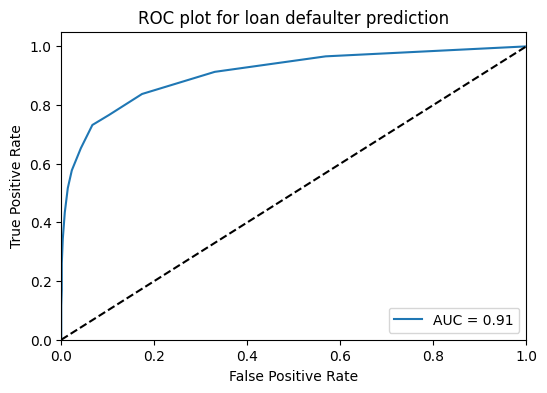

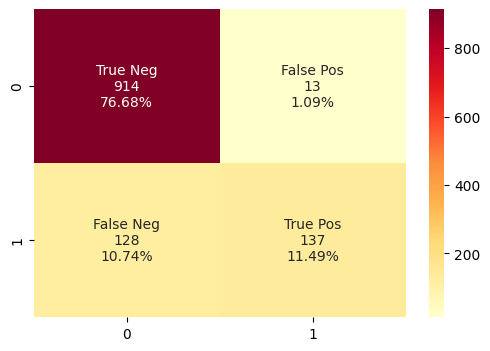

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       927
           1       0.91      0.52      0.66       265

    accuracy                           0.88      1192
   macro avg       0.90      0.75      0.79      1192
weighted avg       0.89      0.88      0.87      1192






Model 4: KNeighborsClassifier
Fitting 5 folds for each of 48 candidates, totalling 240 fits


d:\App\setup_python\python_3_10\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Best train: 0.900064 using {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.8549
Recall on Training Set: 1.0000
Recall on Test Set: 0.3585


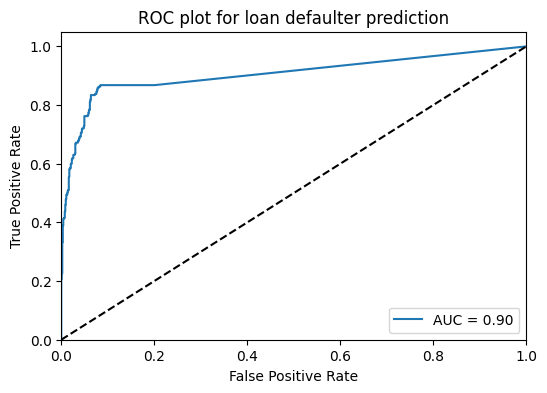

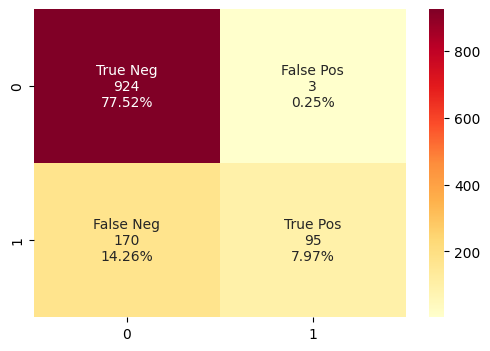

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       927
           1       0.97      0.36      0.52       265

    accuracy                           0.85      1192
   macro avg       0.91      0.68      0.72      1192
weighted avg       0.87      0.85      0.83      1192






Model 5: SVC
Fitting 5 folds for each of 20 candidates, totalling 100 fits


d:\App\setup_python\python_3_10\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best train: 0.967992 using {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Accuracy on Training Set: 0.9943
Accuracy on Test Set: 0.8389
Recall on Training Set: 0.9707
Recall on Test Set: 0.2981


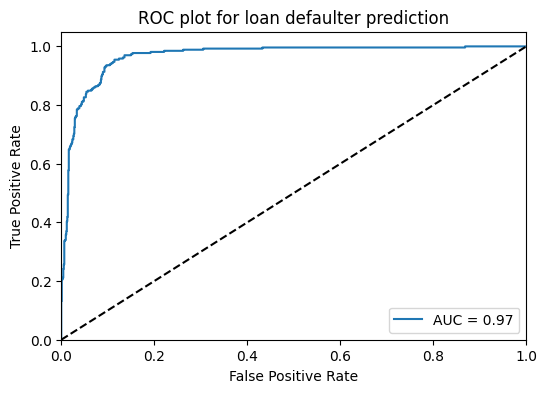

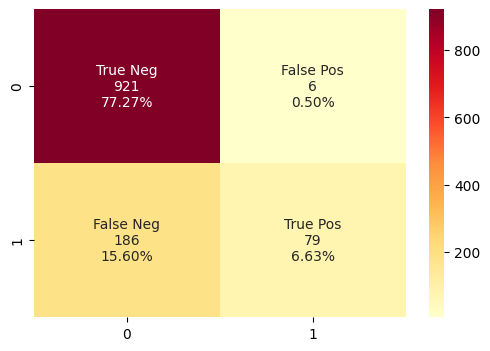

              precision    recall  f1-score   support

           0       0.83      0.99      0.91       927
           1       0.93      0.30      0.45       265

    accuracy                           0.84      1192
   macro avg       0.88      0.65      0.68      1192
weighted avg       0.85      0.84      0.80      1192






Model 6: XGBClassifier
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best train: 0.932840 using {'colsample_bytree': 0.8, 'gamma': 0.1, 'max_depth': 7, 'min_child_weight': 1}
Accuracy on Training Set: 0.9998
Accuracy on Test Set: 0.8683
Recall on Training Set: 0.9989
Recall on Test Set: 0.5019


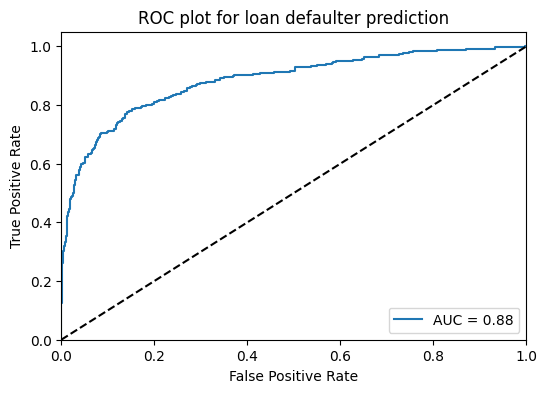

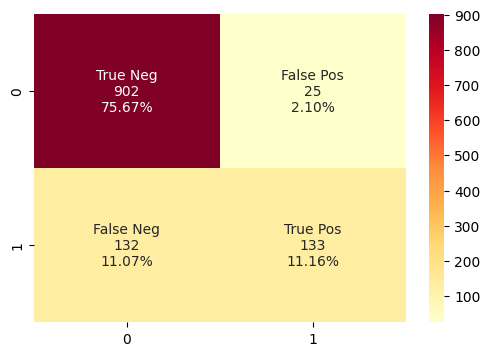

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       927
           1       0.84      0.50      0.63       265

    accuracy                           0.87      1192
   macro avg       0.86      0.74      0.77      1192
weighted avg       0.87      0.87      0.86      1192








In [205]:
build_and_train_model(models, param_grids, X_train_1, y_train_1, X_test_1, y_test_1, 1)

<h3>data2 - GridSearch

Model 1: LogisticRegression
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best train: 0.843863 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy on Training Set: 0.8542
Accuracy on Test Set: 0.8372
Recall on Training Set: 0.3788
Recall on Test Set: 0.3925


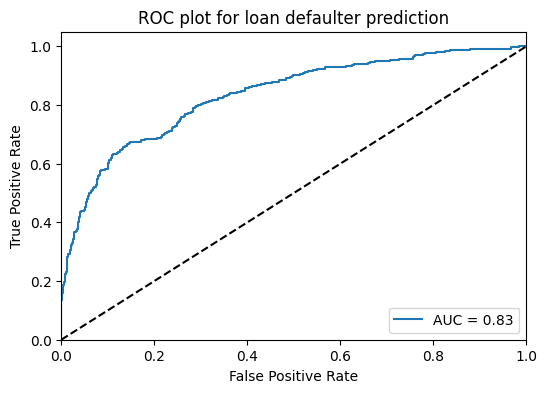

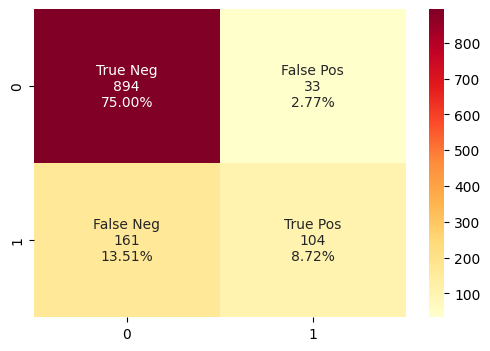

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       927
           1       0.76      0.39      0.52       265

    accuracy                           0.84      1192
   macro avg       0.80      0.68      0.71      1192
weighted avg       0.83      0.84      0.82      1192






Model 2: DecisionTreeClassifier
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best train: 0.926786 using {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 5}
Accuracy on Training Set: 0.9654
Accuracy on Test Set: 0.9463
Recall on Training Set: 0.8366
Recall on Test Set: 0.7925


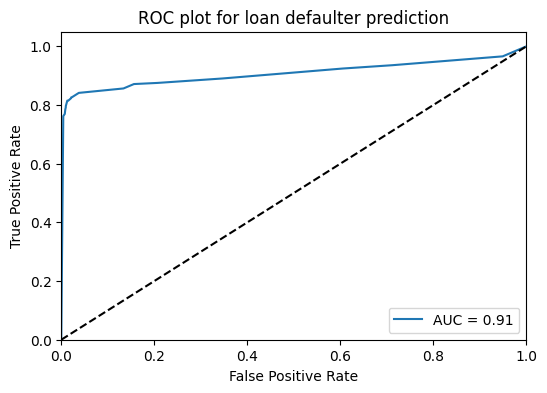

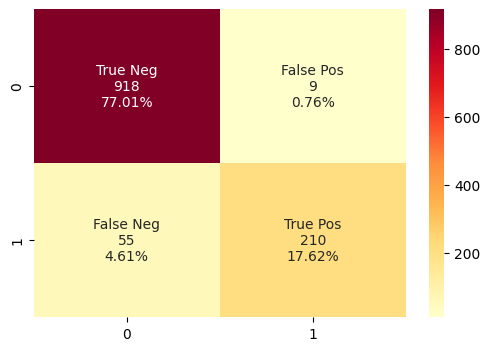

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       927
           1       0.96      0.79      0.87       265

    accuracy                           0.95      1192
   macro avg       0.95      0.89      0.92      1192
weighted avg       0.95      0.95      0.94      1192






Model 3: RandomForestClassifier
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best train: 0.977352 using {'criterion': 'gini', 'max_depth': 60, 'n_estimators': 15}
Accuracy on Training Set: 0.9987
Accuracy on Test Set: 0.9639
Recall on Training Set: 0.9935
Recall on Test Set: 0.8491


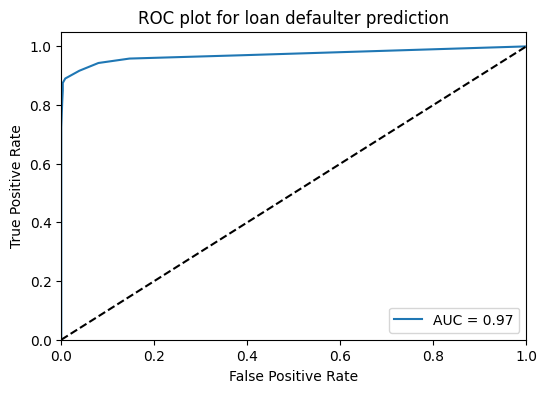

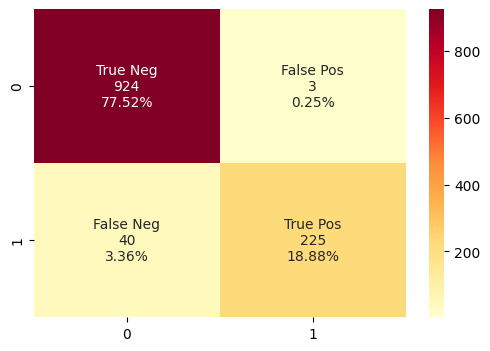

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       927
           1       0.99      0.85      0.91       265

    accuracy                           0.96      1192
   macro avg       0.97      0.92      0.95      1192
weighted avg       0.96      0.96      0.96      1192






Model 4: KNeighborsClassifier
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best train: 0.715202 using {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.8230
Recall on Training Set: 1.0000
Recall on Test Set: 0.2943


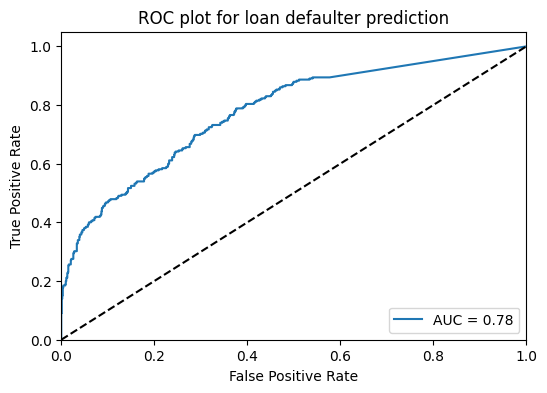

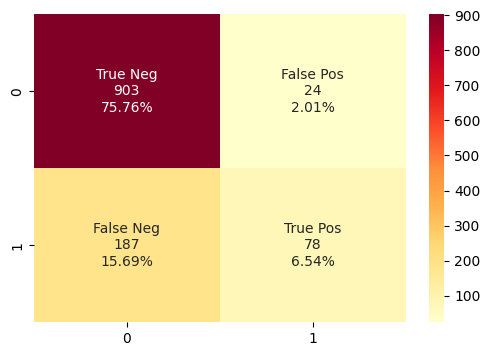

              precision    recall  f1-score   support

           0       0.83      0.97      0.90       927
           1       0.76      0.29      0.43       265

    accuracy                           0.82      1192
   macro avg       0.80      0.63      0.66      1192
weighted avg       0.81      0.82      0.79      1192






Model 5: SVC
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best train: 0.503330 using {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy on Training Set: 0.9998
Accuracy on Test Set: 0.7777
Recall on Training Set: 0.9989
Recall on Test Set: 0.0000


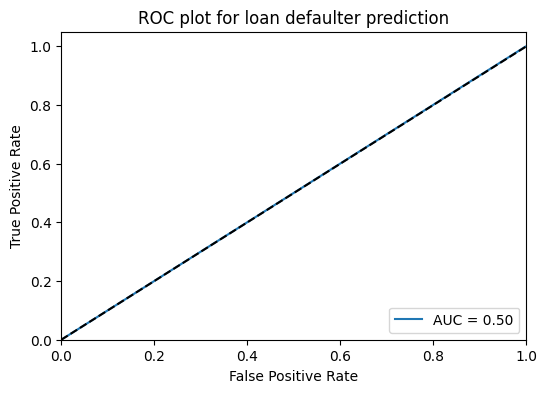

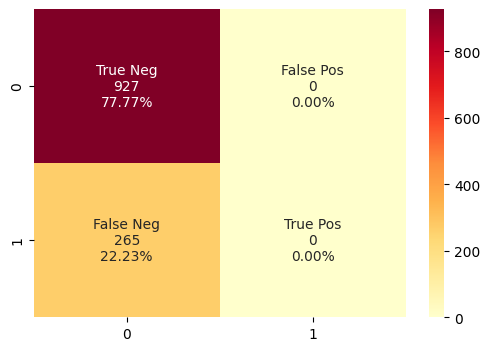

d:\App\setup_python\python_3_10\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\App\setup_python\python_3_10\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\App\setup_python\python_3_10\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.78      1.00      0.87       927
           1       0.00      0.00      0.00       265

    accuracy                           0.78      1192
   macro avg       0.39      0.50      0.44      1192
weighted avg       0.60      0.78      0.68      1192






Model 6: XGBClassifier
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best train: 0.974165 using {'colsample_bytree': 0.8, 'gamma': 0.1, 'max_depth': 9, 'min_child_weight': 1}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.9681
Recall on Training Set: 1.0000
Recall on Test Set: 0.8679


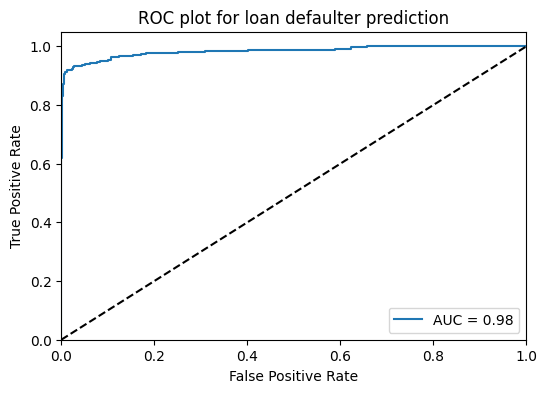

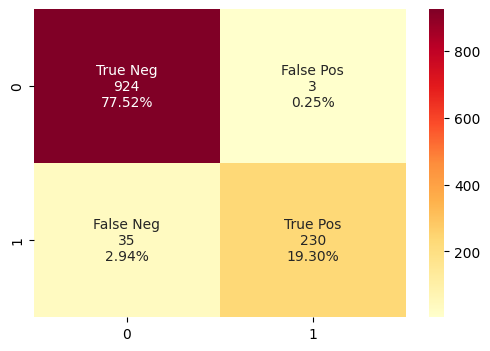

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       927
           1       0.99      0.87      0.92       265

    accuracy                           0.97      1192
   macro avg       0.98      0.93      0.95      1192
weighted avg       0.97      0.97      0.97      1192








In [206]:
build_and_train_model(models, param_grids, X_train_2, y_train_2, X_test_2, y_test_2, 2)

<h3>data3 - GridSearch

Model 1: LogisticRegression
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best train: 0.843582 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy on Training Set: 0.8547
Accuracy on Test Set: 0.8356
Recall on Training Set: 0.3788
Recall on Test Set: 0.3849


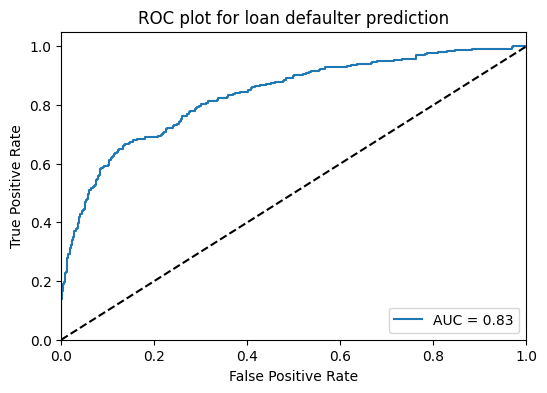

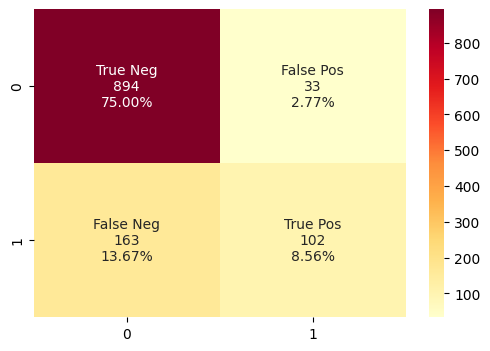

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       927
           1       0.76      0.38      0.51       265

    accuracy                           0.84      1192
   macro avg       0.80      0.67      0.71      1192
weighted avg       0.83      0.84      0.81      1192






Model 2: DecisionTreeClassifier
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best train: 0.925678 using {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Accuracy on Training Set: 0.9654
Accuracy on Test Set: 0.9480
Recall on Training Set: 0.8366
Recall on Test Set: 0.7925


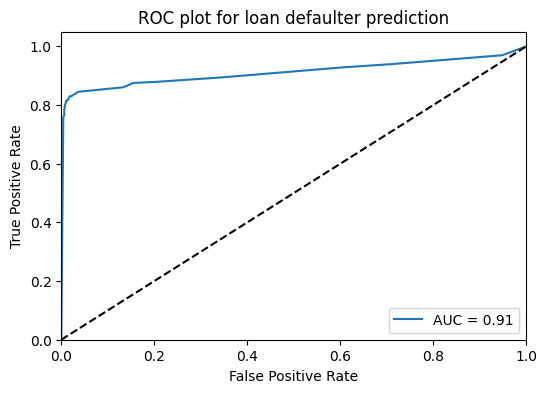

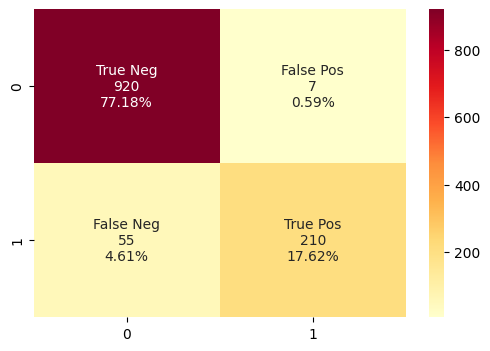

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       927
           1       0.97      0.79      0.87       265

    accuracy                           0.95      1192
   macro avg       0.96      0.89      0.92      1192
weighted avg       0.95      0.95      0.95      1192






Model 3: RandomForestClassifier
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best train: 0.976596 using {'criterion': 'gini', 'max_depth': 70, 'n_estimators': 15}
Accuracy on Training Set: 0.9987
Accuracy on Test Set: 0.9606
Recall on Training Set: 0.9935
Recall on Test Set: 0.8340


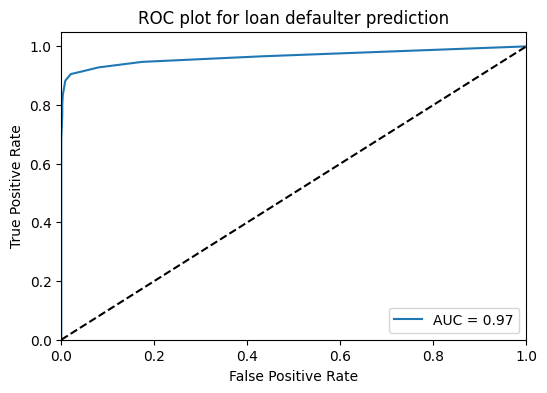

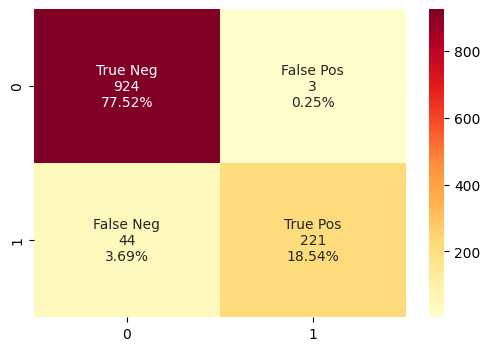

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       927
           1       0.99      0.83      0.90       265

    accuracy                           0.96      1192
   macro avg       0.97      0.92      0.94      1192
weighted avg       0.96      0.96      0.96      1192






Model 4: KNeighborsClassifier
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best train: 0.715205 using {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.8230
Recall on Training Set: 1.0000
Recall on Test Set: 0.2943


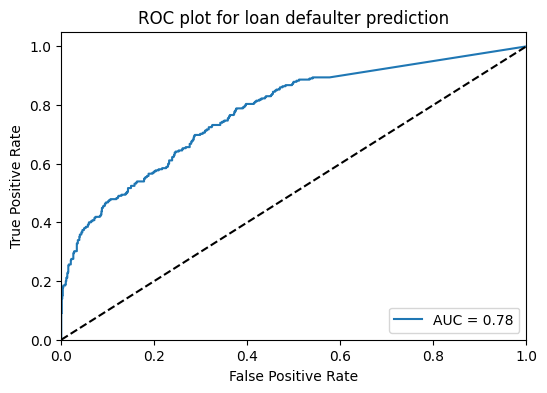

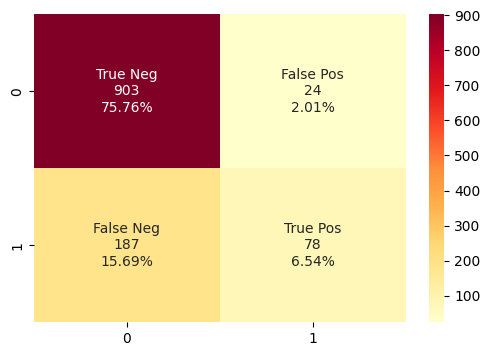

              precision    recall  f1-score   support

           0       0.83      0.97      0.90       927
           1       0.76      0.29      0.43       265

    accuracy                           0.82      1192
   macro avg       0.80      0.63      0.66      1192
weighted avg       0.81      0.82      0.79      1192






Model 5: SVC
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best train: 0.503330 using {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy on Training Set: 0.9998
Accuracy on Test Set: 0.7777
Recall on Training Set: 0.9989
Recall on Test Set: 0.0000


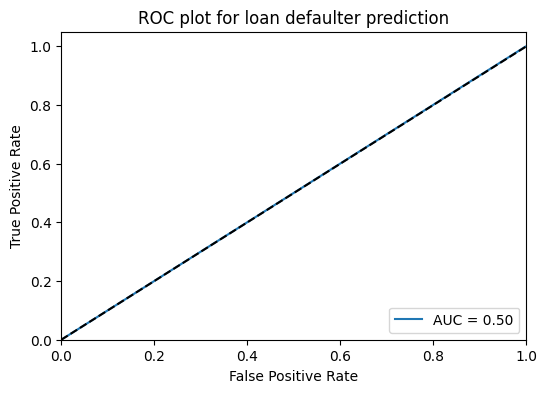

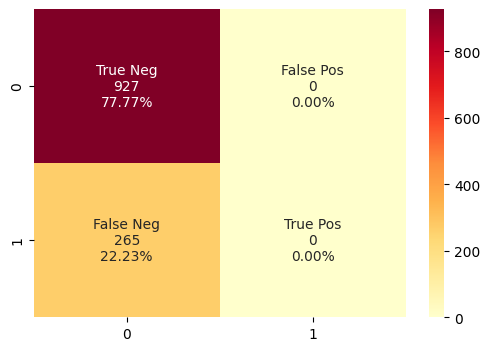

d:\App\setup_python\python_3_10\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\App\setup_python\python_3_10\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\App\setup_python\python_3_10\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.78      1.00      0.87       927
           1       0.00      0.00      0.00       265

    accuracy                           0.78      1192
   macro avg       0.39      0.50      0.44      1192
weighted avg       0.60      0.78      0.68      1192






Model 6: XGBClassifier
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best train: 0.973962 using {'colsample_bytree': 0.6, 'gamma': 0.1, 'max_depth': 9, 'min_child_weight': 1}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.9622
Recall on Training Set: 1.0000
Recall on Test Set: 0.8415


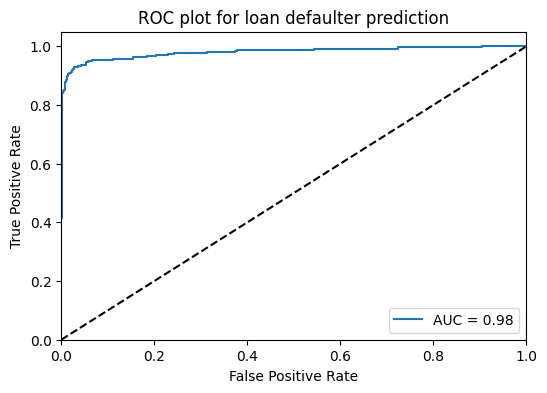

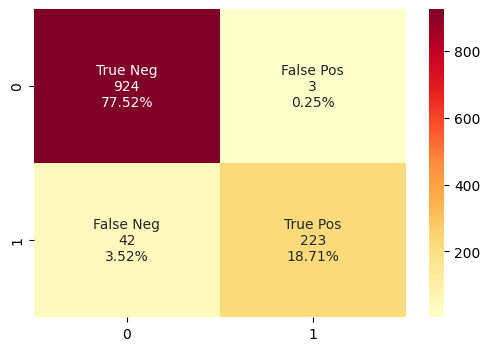

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       927
           1       0.99      0.84      0.91       265

    accuracy                           0.96      1192
   macro avg       0.97      0.92      0.94      1192
weighted avg       0.96      0.96      0.96      1192








In [207]:
build_and_train_model(models, param_grids, X_train_3, y_train_3, X_test_3, y_test_3,3)

<h3>data4 - GridSearch

Model 1: LogisticRegression
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best train: 0.805334 using {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy on Training Set: 0.8406
Accuracy on Test Set: 0.8146
Recall on Training Set: 0.2976
Recall on Test Set: 0.2755


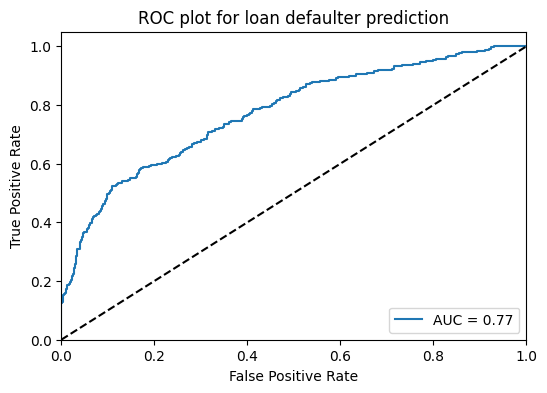

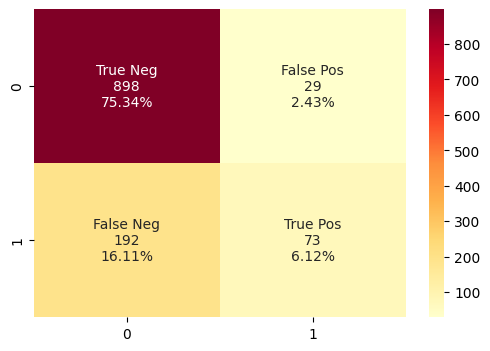

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       927
           1       0.72      0.28      0.40       265

    accuracy                           0.81      1192
   macro avg       0.77      0.62      0.64      1192
weighted avg       0.80      0.81      0.78      1192






Model 2: DecisionTreeClassifier
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best train: 0.865583 using {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 5}
Accuracy on Training Set: 0.9218
Accuracy on Test Set: 0.8750
Recall on Training Set: 0.7381
Recall on Test Set: 0.5925


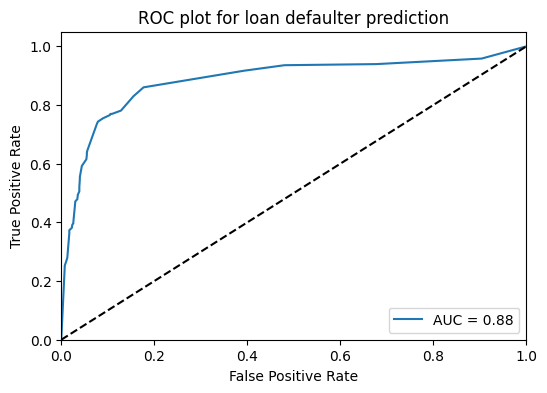

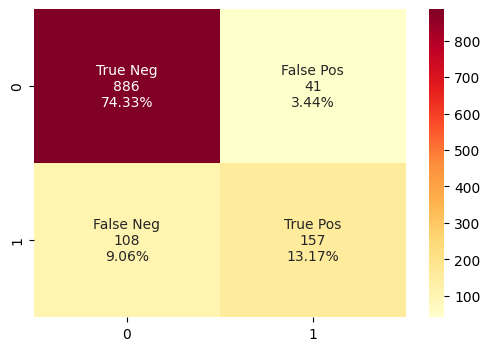

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       927
           1       0.79      0.59      0.68       265

    accuracy                           0.88      1192
   macro avg       0.84      0.77      0.80      1192
weighted avg       0.87      0.88      0.87      1192






Model 3: RandomForestClassifier
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best train: 0.952778 using {'criterion': 'gini', 'max_depth': 70, 'n_estimators': 15}
Accuracy on Training Set: 0.9973
Accuracy on Test Set: 0.9094
Recall on Training Set: 0.9892
Recall on Test Set: 0.6868


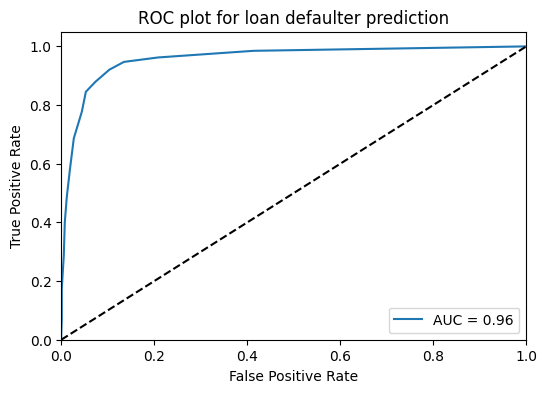

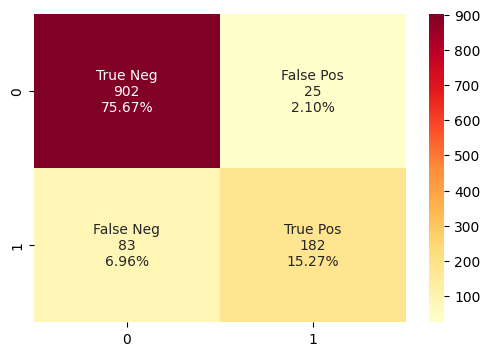

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       927
           1       0.88      0.69      0.77       265

    accuracy                           0.91      1192
   macro avg       0.90      0.83      0.86      1192
weighted avg       0.91      0.91      0.91      1192






Model 4: KNeighborsClassifier
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best train: 0.926207 using {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.8716
Recall on Training Set: 1.0000
Recall on Test Set: 0.4226


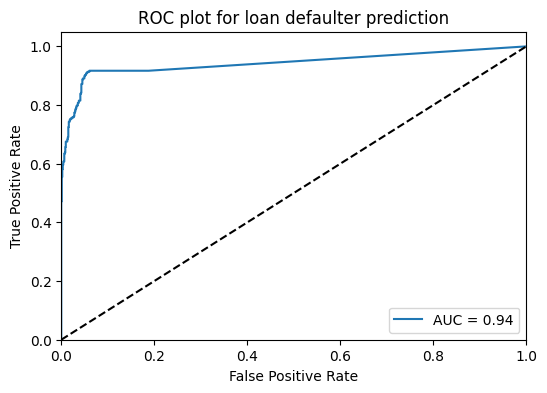

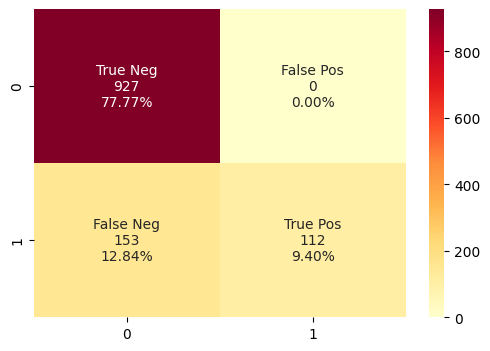

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       927
           1       1.00      0.42      0.59       265

    accuracy                           0.87      1192
   macro avg       0.93      0.71      0.76      1192
weighted avg       0.89      0.87      0.85      1192






Model 5: SVC
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best train: 0.983294 using {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Accuracy on Training Set: 0.9929
Accuracy on Test Set: 0.9337
Recall on Training Set: 0.9654
Recall on Test Set: 0.7245


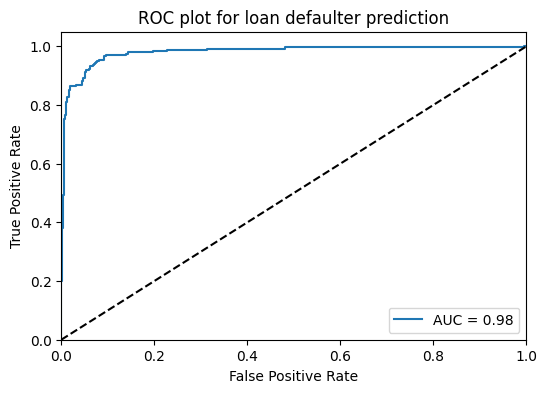

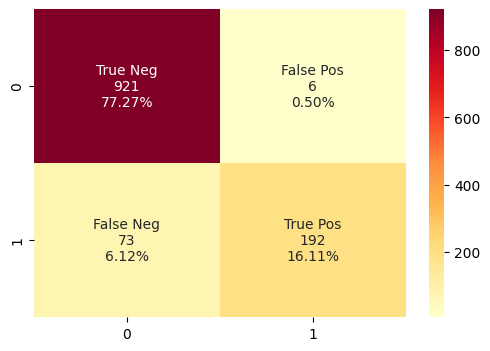

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       927
           1       0.97      0.72      0.83       265

    accuracy                           0.93      1192
   macro avg       0.95      0.86      0.89      1192
weighted avg       0.94      0.93      0.93      1192






Model 6: XGBClassifier
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best train: 0.955490 using {'colsample_bytree': 0.6, 'gamma': 0.1, 'max_depth': 7, 'min_child_weight': 1}
Accuracy on Training Set: 0.9998
Accuracy on Test Set: 0.8993
Recall on Training Set: 1.0000
Recall on Test Set: 0.6189


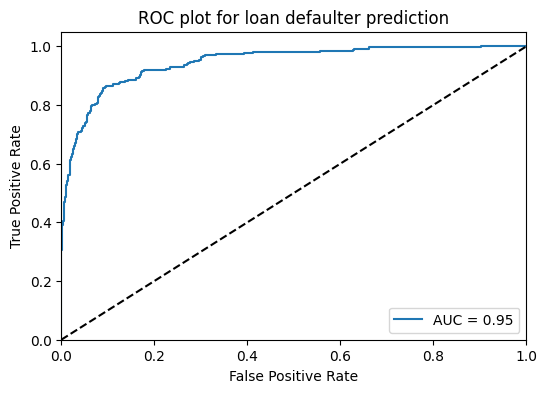

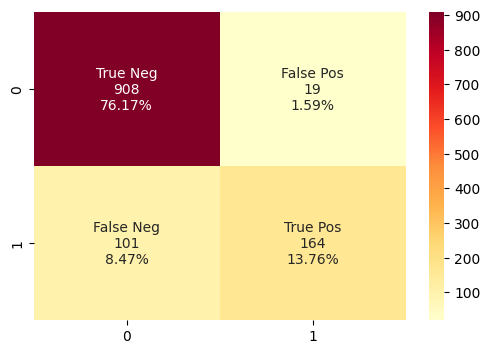

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       927
           1       0.90      0.62      0.73       265

    accuracy                           0.90      1192
   macro avg       0.90      0.80      0.84      1192
weighted avg       0.90      0.90      0.89      1192








In [208]:
build_and_train_model(models, param_grids, X_train_4, y_train_4, X_test_4, y_test_4,4)

<p>data5 - GridSearch

Model 1: LogisticRegression
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best train: 0.804588 using {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy on Training Set: 0.8414
Accuracy on Test Set: 0.8163
Recall on Training Set: 0.3052
Recall on Test Set: 0.3132


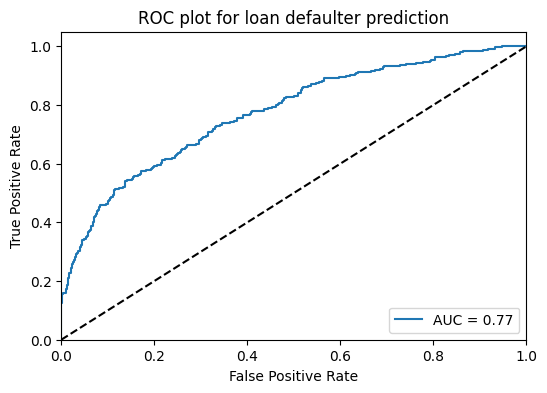

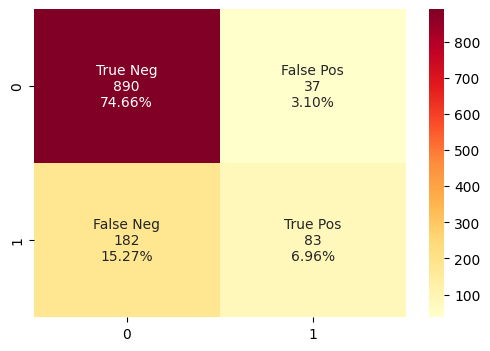

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       927
           1       0.69      0.31      0.43       265

    accuracy                           0.82      1192
   macro avg       0.76      0.64      0.66      1192
weighted avg       0.80      0.82      0.79      1192






Model 2: DecisionTreeClassifier
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best train: 0.870276 using {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 5}
Accuracy on Training Set: 0.9251
Accuracy on Test Set: 0.8364
Recall on Training Set: 0.7024
Recall on Test Set: 0.3057


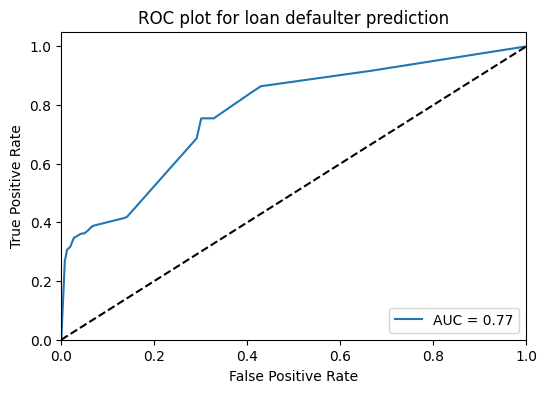

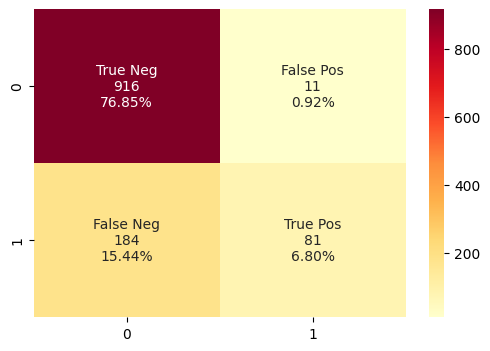

              precision    recall  f1-score   support

           0       0.83      0.99      0.90       927
           1       0.88      0.31      0.45       265

    accuracy                           0.84      1192
   macro avg       0.86      0.65      0.68      1192
weighted avg       0.84      0.84      0.80      1192






Model 3: RandomForestClassifier
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best train: 0.948698 using {'criterion': 'gini', 'max_depth': 50, 'n_estimators': 15}
Accuracy on Training Set: 0.9981
Accuracy on Test Set: 0.8666
Recall on Training Set: 0.9935
Recall on Test Set: 0.4340


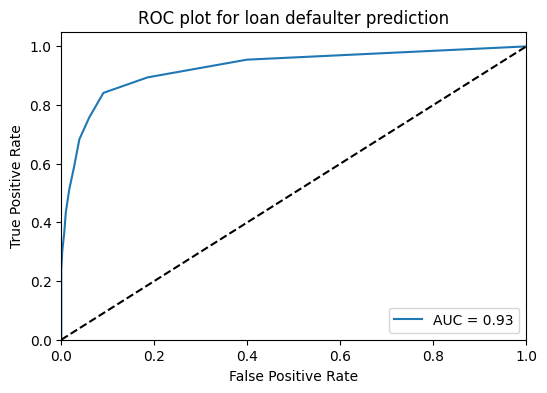

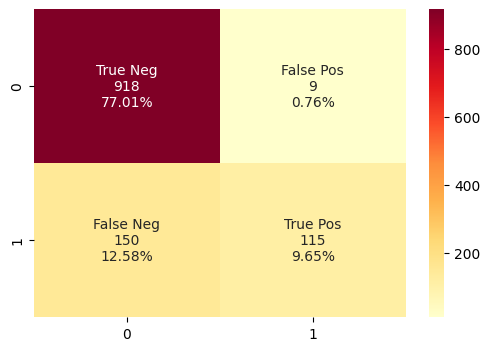

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       927
           1       0.93      0.43      0.59       265

    accuracy                           0.87      1192
   macro avg       0.89      0.71      0.76      1192
weighted avg       0.87      0.87      0.85      1192






Model 4: KNeighborsClassifier
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best train: 0.655169 using {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.7953
Recall on Training Set: 1.0000
Recall on Test Set: 0.2679


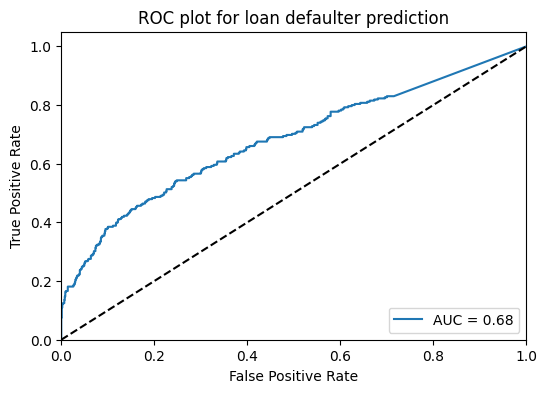

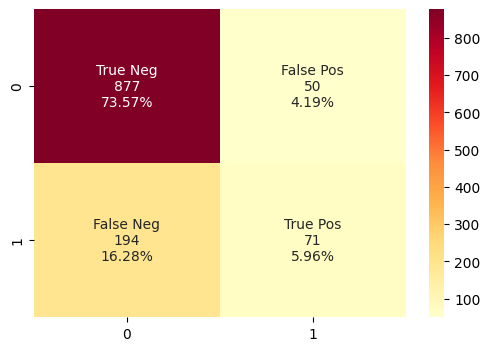

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       927
           1       0.59      0.27      0.37       265

    accuracy                           0.80      1192
   macro avg       0.70      0.61      0.62      1192
weighted avg       0.77      0.80      0.76      1192






Model 5: SVC
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best train: 0.532100 using {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy on Training Set: 0.9998
Accuracy on Test Set: 0.7777
Recall on Training Set: 0.9989
Recall on Test Set: 0.0000


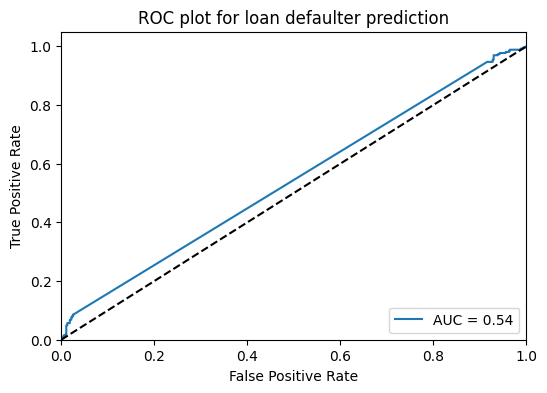

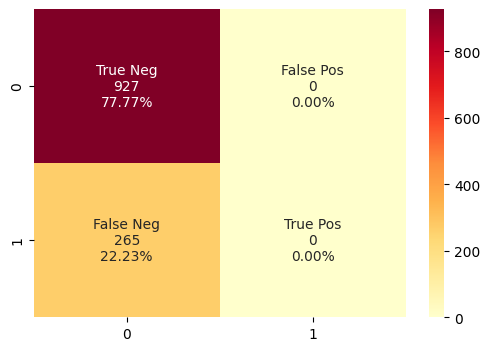

d:\App\setup_python\python_3_10\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\App\setup_python\python_3_10\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\App\setup_python\python_3_10\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.78      1.00      0.87       927
           1       0.00      0.00      0.00       265

    accuracy                           0.78      1192
   macro avg       0.39      0.50      0.44      1192
weighted avg       0.60      0.78      0.68      1192






Model 6: XGBClassifier
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best train: 0.951557 using {'colsample_bytree': 0.8, 'gamma': 0.1, 'max_depth': 9, 'min_child_weight': 1}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.8767
Recall on Training Set: 1.0000
Recall on Test Set: 0.4604


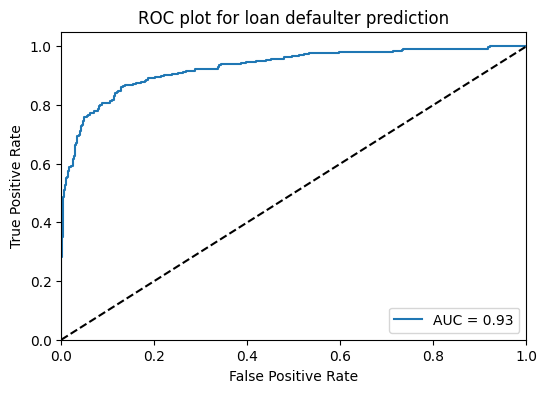

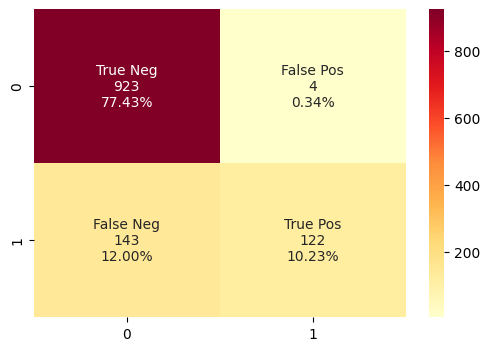

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       927
           1       0.97      0.46      0.62       265

    accuracy                           0.88      1192
   macro avg       0.92      0.73      0.78      1192
weighted avg       0.89      0.88      0.86      1192








In [209]:
build_and_train_model(models, param_grids, X_train_5, y_train_5, X_test_5, y_test_5,5)

<p>data6 - GridSearch

Model 1: LogisticRegression
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best train: 0.804801 using {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy on Training Set: 0.8421
Accuracy on Test Set: 0.8129
Recall on Training Set: 0.3106
Recall on Test Set: 0.3132


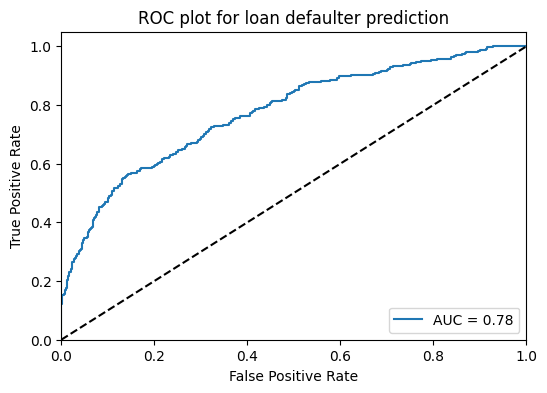

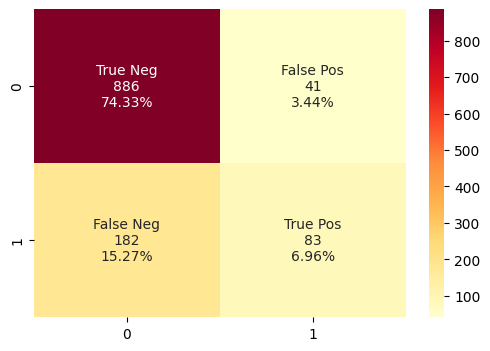

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       927
           1       0.67      0.31      0.43       265

    accuracy                           0.81      1192
   macro avg       0.75      0.63      0.66      1192
weighted avg       0.79      0.81      0.79      1192






Model 2: DecisionTreeClassifier
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best train: 0.867968 using {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
Accuracy on Training Set: 0.9260
Accuracy on Test Set: 0.8448
Recall on Training Set: 0.7500
Recall on Test Set: 0.3698


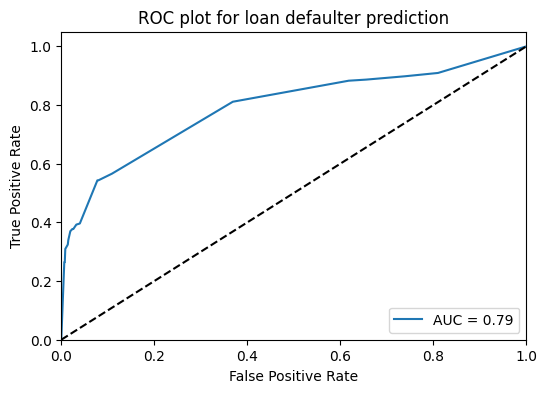

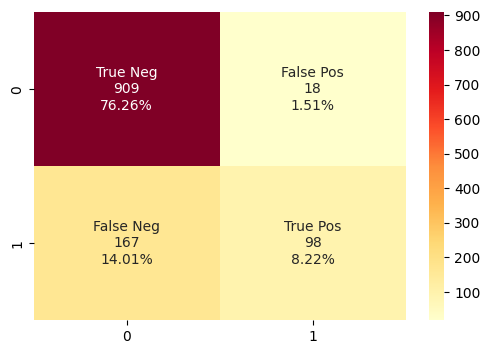

              precision    recall  f1-score   support

           0       0.84      0.98      0.91       927
           1       0.84      0.37      0.51       265

    accuracy                           0.84      1192
   macro avg       0.84      0.68      0.71      1192
weighted avg       0.84      0.84      0.82      1192






Model 3: RandomForestClassifier
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best train: 0.954497 using {'criterion': 'gini', 'max_depth': 60, 'n_estimators': 15}
Accuracy on Training Set: 0.9987
Accuracy on Test Set: 0.8708
Recall on Training Set: 0.9935
Recall on Test Set: 0.4453


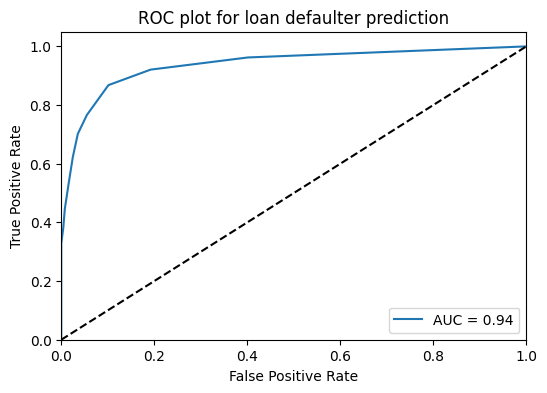

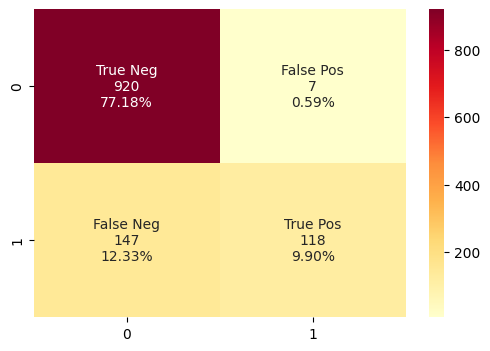

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       927
           1       0.94      0.45      0.61       265

    accuracy                           0.87      1192
   macro avg       0.90      0.72      0.76      1192
weighted avg       0.88      0.87      0.85      1192






Model 4: KNeighborsClassifier
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best train: 0.683439 using {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.8154
Recall on Training Set: 1.0000
Recall on Test Set: 0.2604


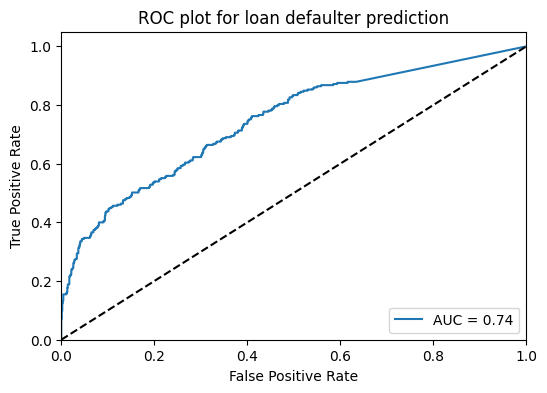

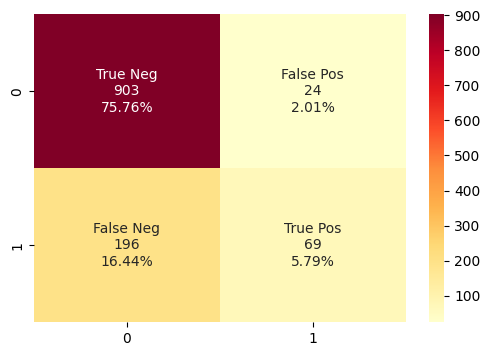

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       927
           1       0.74      0.26      0.39       265

    accuracy                           0.82      1192
   macro avg       0.78      0.62      0.64      1192
weighted avg       0.80      0.82      0.78      1192






Model 5: SVC
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best train: 0.502660 using {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy on Training Set: 0.9998
Accuracy on Test Set: 0.7777
Recall on Training Set: 0.9989
Recall on Test Set: 0.0000


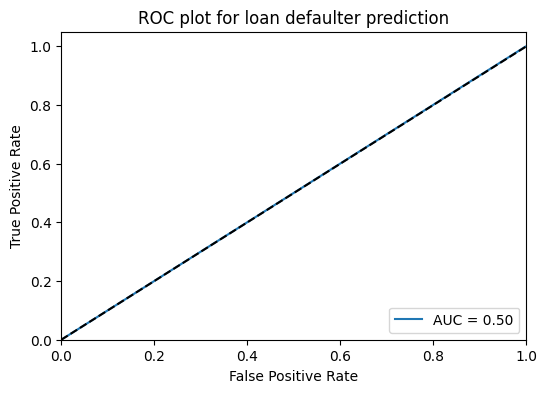

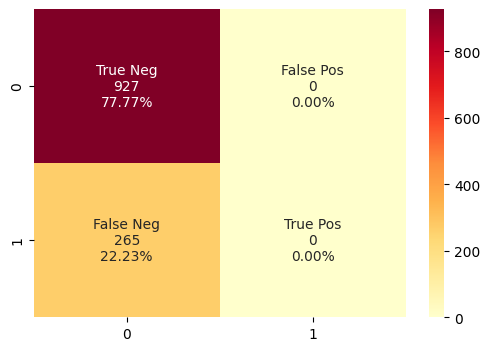

d:\App\setup_python\python_3_10\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\App\setup_python\python_3_10\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\App\setup_python\python_3_10\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.78      1.00      0.87       927
           1       0.00      0.00      0.00       265

    accuracy                           0.78      1192
   macro avg       0.39      0.50      0.44      1192
weighted avg       0.60      0.78      0.68      1192






Model 6: XGBClassifier
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best train: 0.955930 using {'colsample_bytree': 0.6, 'gamma': 0.1, 'max_depth': 7, 'min_child_weight': 1}
Accuracy on Training Set: 0.9998
Accuracy on Test Set: 0.8767
Recall on Training Set: 1.0000
Recall on Test Set: 0.4491


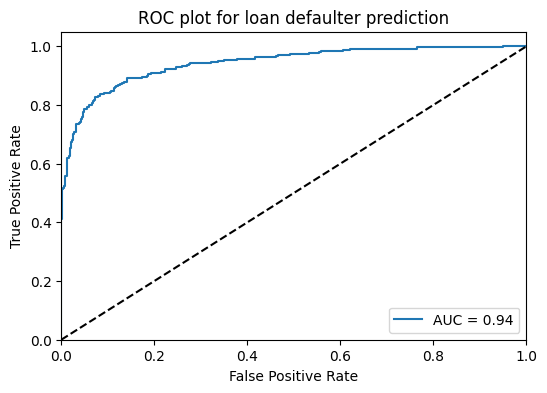

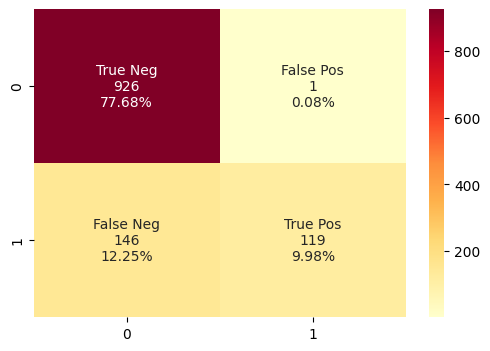

              precision    recall  f1-score   support

           0       0.86      1.00      0.93       927
           1       0.99      0.45      0.62       265

    accuracy                           0.88      1192
   macro avg       0.93      0.72      0.77      1192
weighted avg       0.89      0.88      0.86      1192








In [210]:
build_and_train_model(models, param_grids, X_train_6, y_train_6, X_test_6, y_test_6,6)

<p>data7 - GridSearch

Model 1: LogisticRegression
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best train: 0.812472 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy on Training Set: 0.8482
Accuracy on Test Set: 0.8302
Recall on Training Set: 0.3401
Recall on Test Set: 0.3039


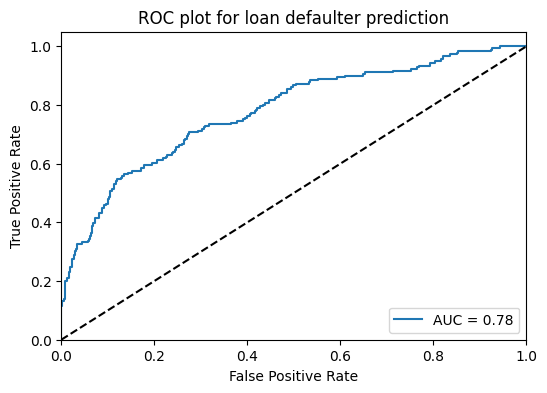

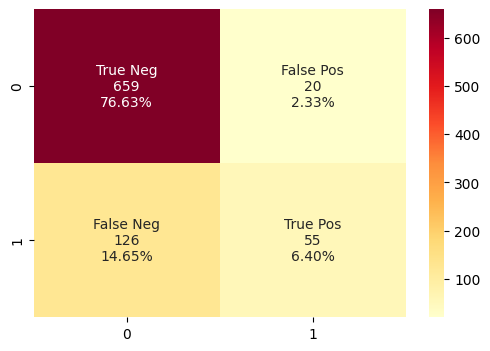

              precision    recall  f1-score   support

           0       0.84      0.97      0.90       679
           1       0.73      0.30      0.43       181

    accuracy                           0.83       860
   macro avg       0.79      0.64      0.66       860
weighted avg       0.82      0.83      0.80       860






Model 2: DecisionTreeClassifier
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best train: 0.835544 using {'criterion': 'gini', 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10}
Accuracy on Training Set: 0.9427
Accuracy on Test Set: 0.8430
Recall on Training Set: 0.7815
Recall on Test Set: 0.5304


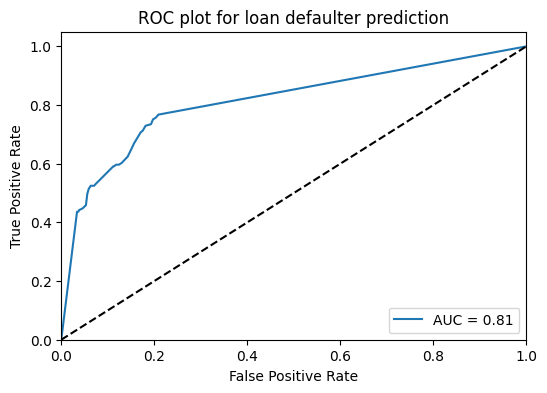

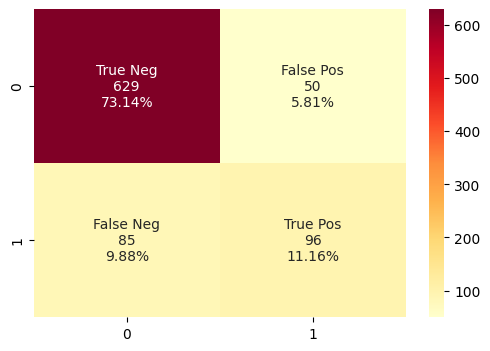

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       679
           1       0.66      0.53      0.59       181

    accuracy                           0.84       860
   macro avg       0.77      0.73      0.75       860
weighted avg       0.83      0.84      0.84       860






Model 3: RandomForestClassifier
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best train: 0.953424 using {'criterion': 'entropy', 'max_depth': 70, 'n_estimators': 15}
Accuracy on Training Set: 0.9978
Accuracy on Test Set: 0.9093
Recall on Training Set: 0.9884
Recall on Test Set: 0.6022


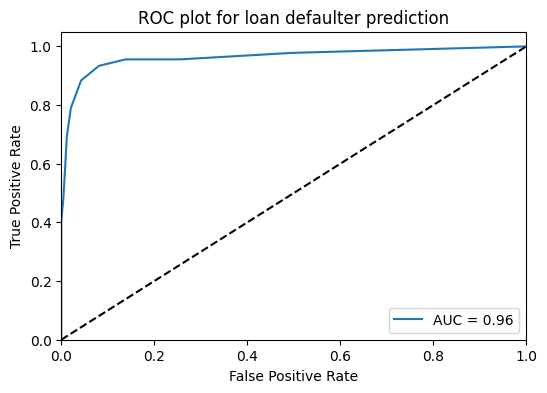

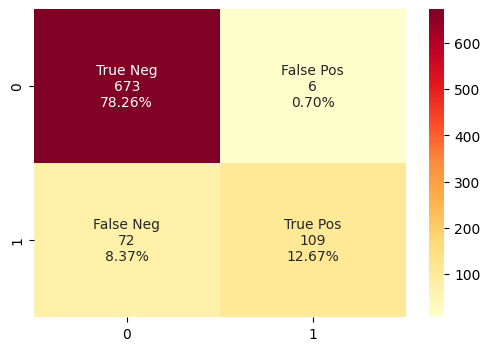

              precision    recall  f1-score   support

           0       0.90      0.99      0.95       679
           1       0.95      0.60      0.74       181

    accuracy                           0.91       860
   macro avg       0.93      0.80      0.84       860
weighted avg       0.91      0.91      0.90       860






Model 4: KNeighborsClassifier
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best train: 0.918016 using {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.8802
Recall on Training Set: 1.0000
Recall on Test Set: 0.4309


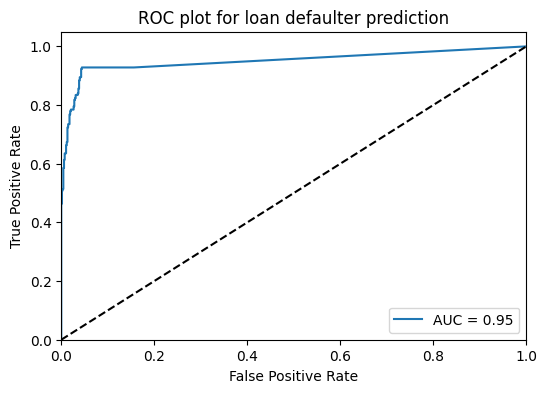

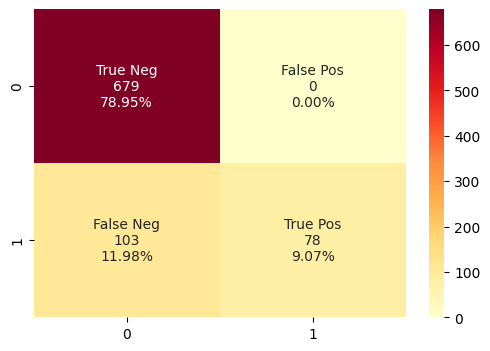

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       679
           1       1.00      0.43      0.60       181

    accuracy                           0.88       860
   macro avg       0.93      0.72      0.77       860
weighted avg       0.90      0.88      0.86       860






Model 5: SVC
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best train: 0.990481 using {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.9651
Recall on Training Set: 1.0000
Recall on Test Set: 0.8729


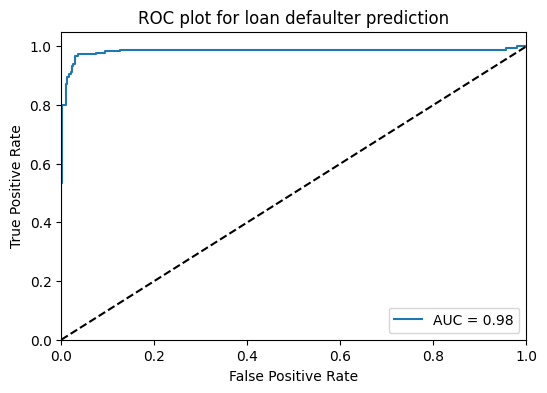

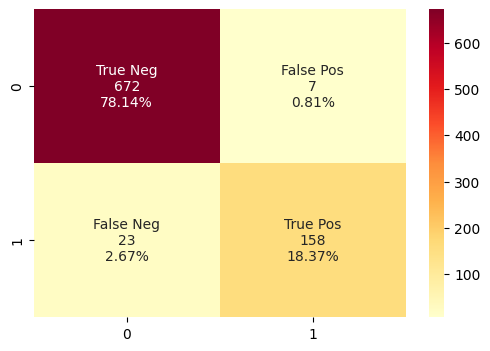

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       679
           1       0.96      0.87      0.91       181

    accuracy                           0.97       860
   macro avg       0.96      0.93      0.95       860
weighted avg       0.96      0.97      0.96       860






Model 6: XGBClassifier
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best train: 0.946886 using {'colsample_bytree': 0.8, 'gamma': 0.1, 'max_depth': 7, 'min_child_weight': 1}
Accuracy on Training Set: 0.9994
Accuracy on Test Set: 0.8930
Recall on Training Set: 0.9971
Recall on Test Set: 0.5193


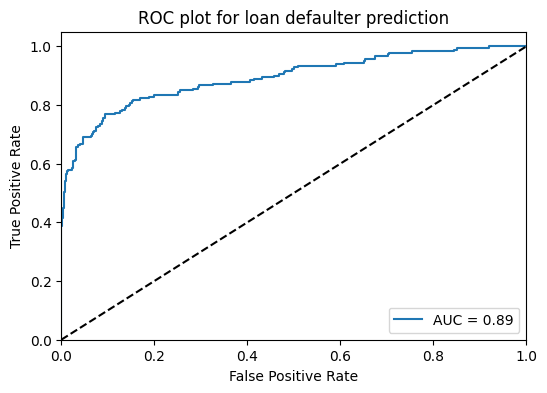

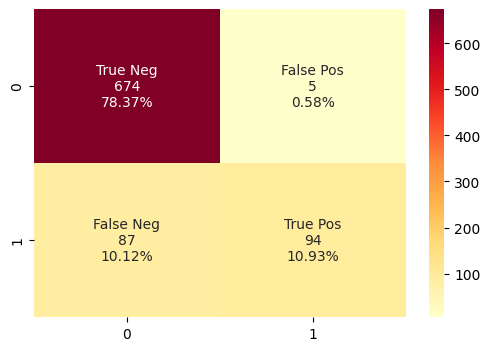

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       679
           1       0.95      0.52      0.67       181

    accuracy                           0.89       860
   macro avg       0.92      0.76      0.80       860
weighted avg       0.90      0.89      0.88       860








In [211]:
build_and_train_model(models, param_grids, X_train_7, y_train_7, X_test_7, y_test_7,7)

<h3>RandomSearch

In [212]:
def tuning_hyperparameter_random(model, param_grid, X_train, y_train):
    clf_grid = RandomizedSearchCV(model, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
    grid = clf_grid.fit(X_train, y_train)
    
    print('Best train: %f using %s' % (grid.best_score_, grid.best_params_))
    return grid.best_estimator_


In [213]:
def build_and_train_model(models, param_grids, X_train, y_train, X_test, y_test, index):
    for i, (model, param_grid) in enumerate(zip(models, param_grids)):
        print(f'Model {i+1}: {type(model).__name__}')
        
        best_model = tuning_hyperparameter_random(model, param_grid, X_train, y_train)
        train_accuracy = best_model.score(X_train, y_train)
        test_accuracy = best_model.score(X_test, y_test)
        
        y_pred_train = best_model.predict(X_train)
        recall_train = recall_score(y_train, y_pred_train)
        
        y_pred_test = best_model.predict(X_test)
        recall_test = recall_score(y_test, y_pred_test)
        
        print(f'Accuracy on Training Set: {train_accuracy:.4f}')
        print(f'Accuracy on Test Set: {test_accuracy:.4f}')
        print(f'Recall on Training Set: {recall_train:.4f}')
        print(f'Recall on Test Set: {recall_test:.4f}')
        
        # Predict on test set
        y_pred = best_model.predict(X_test)
        
        # Call model_analysis with y_pred
        model_analysis(best_model, X_test, y_test, y_pred)
        
        # Save the model
        model_name = type(best_model).__name__
        with open(f"model/{model_name}_rd{index}.pkl", 'wb') as f:
            pickle.dump(best_model, f)
        
        print("\n\n\n\n")


In [216]:
from scipy.stats import randint, uniform

log_param_random = {
    'solver': ['saga', 'liblinear'],
    'penalty': ['l2', 'l1'],
    'C': [0.001, 0.1, 10, 100, 1000, 10000]
}

dt_param_random = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

rf_param_random = { 
    'n_estimators': randint(5, 100),  
    'max_depth': randint(10, 71),     
    'criterion': ['gini', 'entropy']  
} 

knn_param_random = { 
    'n_neighbors' : np.arange(1, 21),
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}

svm_param_random = {
    'kernel':['rbf'],
    'C':uniform(0.1, 10),
    'gamma': ['scale', 'auto'] + list(np.logspace(-2, 0, 3))
}

xgb_param_random = {
    'max_depth': randint(3, 10),
    'gamma': uniform(0, 1),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 11) 
}


In [219]:
models = [log_model, dt_model, rf_model, knn_model, svm_model, xgb_model]
param_random = [log_param_random, dt_param_random, rf_param_random, knn_param_random, svm_param_random, xgb_param_random]

Model 1: LogisticRegression
Fitting 5 folds for each of 10 candidates, totalling 50 fits


d:\App\setup_python\python_3_10\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best train: 0.794591 using {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}
Accuracy on Training Set: 0.8391
Accuracy on Test Set: 0.8070
Recall on Training Set: 0.2871
Recall on Test Set: 0.2453


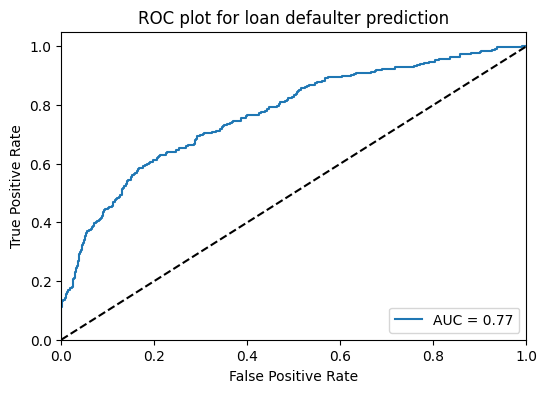

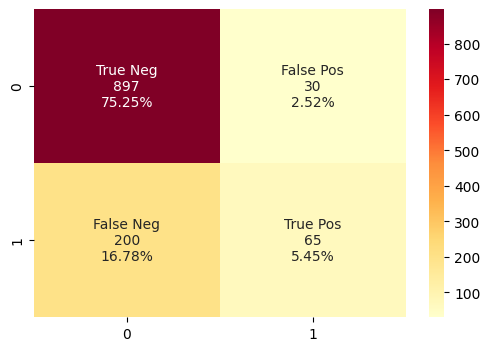

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       927
           1       0.68      0.25      0.36       265

    accuracy                           0.81      1192
   macro avg       0.75      0.61      0.62      1192
weighted avg       0.79      0.81      0.77      1192






Model 2: DecisionTreeClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.810750 using {'criterion': 'gini', 'max_depth': 45, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 15}
Accuracy on Training Set: 0.9303
Accuracy on Test Set: 0.8238
Recall on Training Set: 0.7681
Recall on Test Set: 0.4943


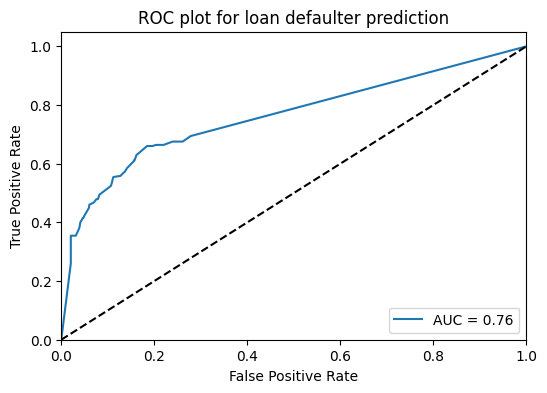

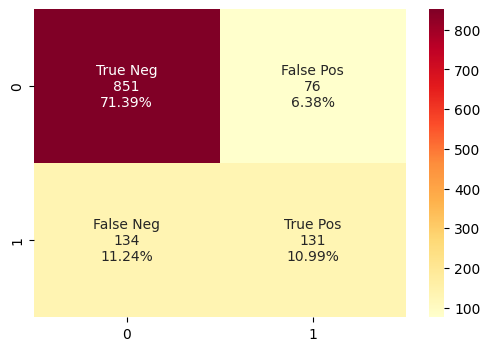

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       927
           1       0.63      0.49      0.56       265

    accuracy                           0.82      1192
   macro avg       0.75      0.71      0.72      1192
weighted avg       0.81      0.82      0.82      1192






Model 3: RandomForestClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits


d:\App\setup_python\python_3_10\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best train: 0.950409 using {'criterion': 'entropy', 'max_depth': 22, 'n_estimators': 89}
Accuracy on Training Set: 0.9987
Accuracy on Test Set: 0.8817
Recall on Training Set: 0.9935
Recall on Test Set: 0.4830


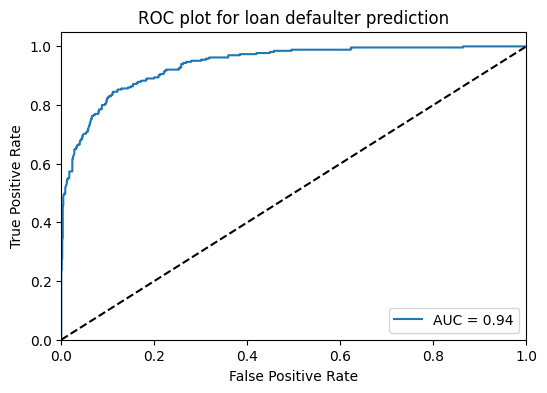

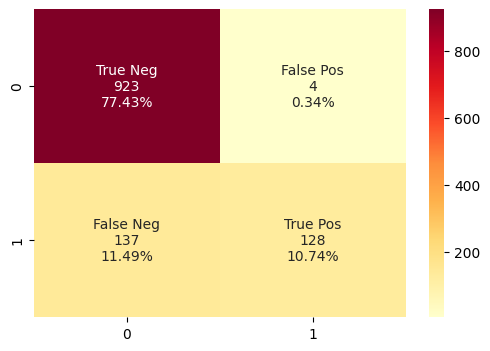

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       927
           1       0.97      0.48      0.64       265

    accuracy                           0.88      1192
   macro avg       0.92      0.74      0.79      1192
weighted avg       0.89      0.88      0.87      1192






Model 4: KNeighborsClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits


d:\App\setup_python\python_3_10\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Best train: 0.900064 using {'weights': 'distance', 'n_neighbors': 8, 'metric': 'manhattan'}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.8549
Recall on Training Set: 1.0000
Recall on Test Set: 0.3585


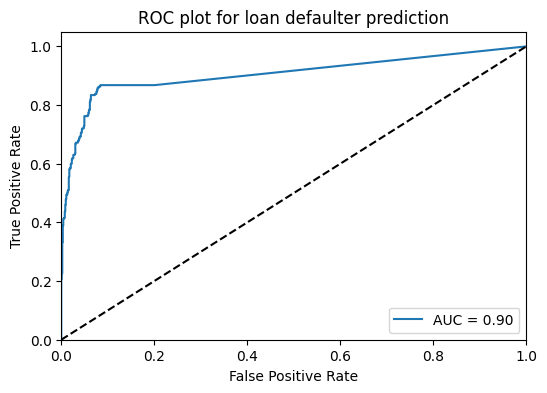

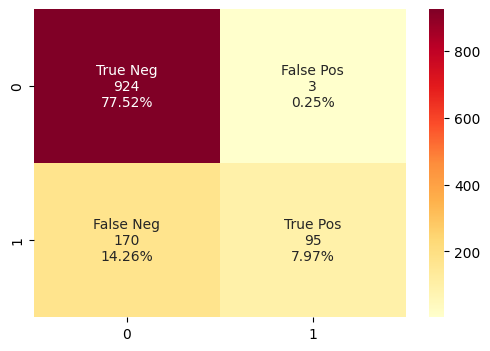

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       927
           1       0.97      0.36      0.52       265

    accuracy                           0.85      1192
   macro avg       0.91      0.68      0.72      1192
weighted avg       0.87      0.85      0.83      1192






Model 5: SVC
Fitting 5 folds for each of 10 candidates, totalling 50 fits


d:\App\setup_python\python_3_10\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best train: 0.968054 using {'C': 1.3029292829808448, 'gamma': 1.0, 'kernel': 'rbf'}
Accuracy on Training Set: 0.9954
Accuracy on Test Set: 0.8532
Recall on Training Set: 0.9772
Recall on Test Set: 0.3774


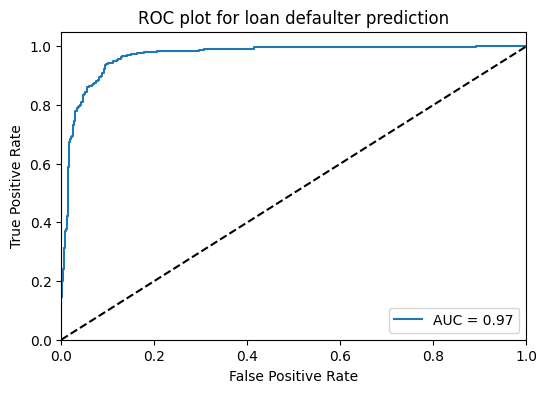

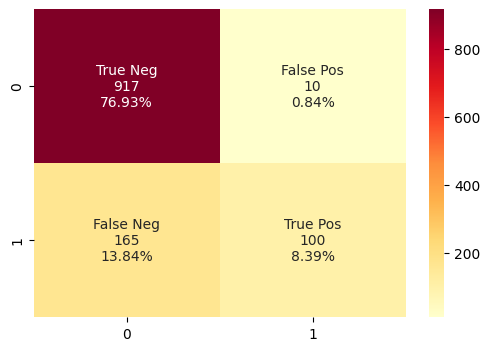

              precision    recall  f1-score   support

           0       0.85      0.99      0.91       927
           1       0.91      0.38      0.53       265

    accuracy                           0.85      1192
   macro avg       0.88      0.68      0.72      1192
weighted avg       0.86      0.85      0.83      1192






Model 6: XGBClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.925420 using {'colsample_bytree': 0.8731688266779785, 'gamma': 0.06508194384211874, 'max_depth': 9, 'min_child_weight': 3}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.8700
Recall on Training Set: 1.0000
Recall on Test Set: 0.5170


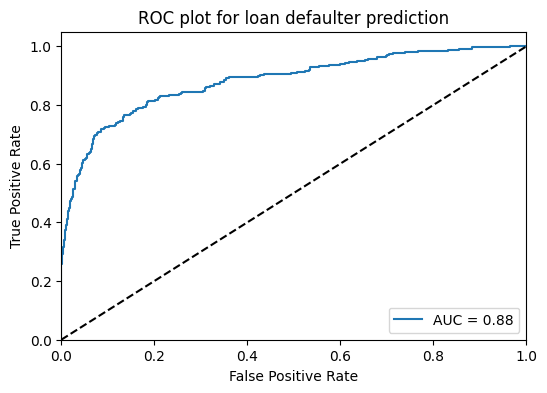

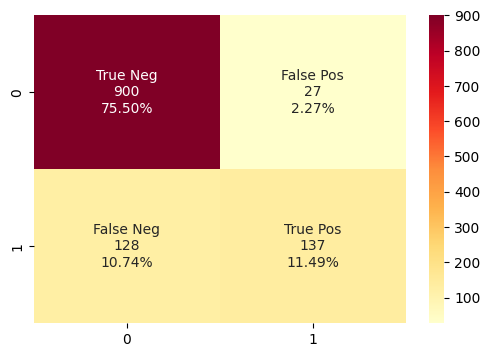

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       927
           1       0.84      0.52      0.64       265

    accuracy                           0.87      1192
   macro avg       0.86      0.74      0.78      1192
weighted avg       0.87      0.87      0.86      1192








In [221]:
build_and_train_model(models, param_random, X_train_1, y_train_1, X_test_1, y_test_1, 1)

<p>data2 - RandomSearch

Model 1: LogisticRegression
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.843829 using {'solver': 'liblinear', 'penalty': 'l1', 'C': 10}
Accuracy on Training Set: 0.8538
Accuracy on Test Set: 0.8372
Recall on Training Set: 0.3788
Recall on Test Set: 0.3925


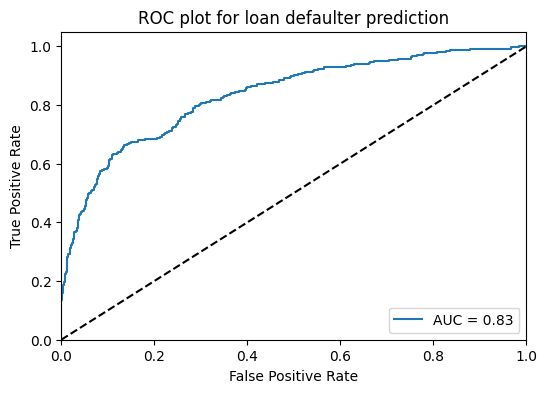

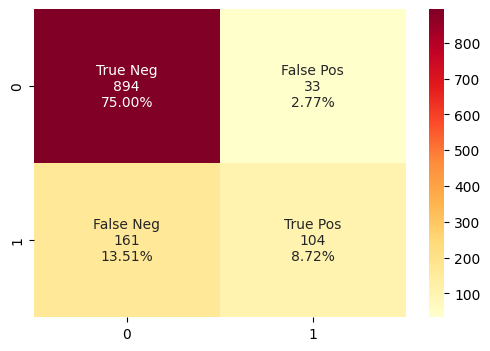

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       927
           1       0.76      0.39      0.52       265

    accuracy                           0.84      1192
   macro avg       0.80      0.68      0.71      1192
weighted avg       0.83      0.84      0.82      1192






Model 2: DecisionTreeClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.922865 using {'criterion': 'gini', 'max_depth': 41, 'max_features': None, 'min_samples_leaf': 12, 'min_samples_split': 2}
Accuracy on Training Set: 0.9516
Accuracy on Test Set: 0.9480
Recall on Training Set: 0.7857
Recall on Test Set: 0.8075


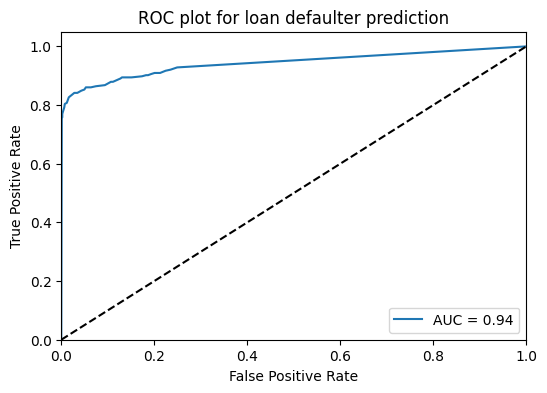

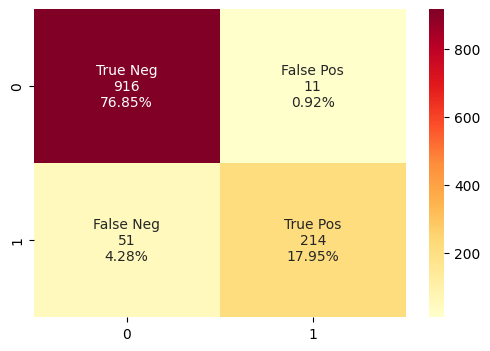

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       927
           1       0.95      0.81      0.87       265

    accuracy                           0.95      1192
   macro avg       0.95      0.90      0.92      1192
weighted avg       0.95      0.95      0.95      1192






Model 3: RandomForestClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.985733 using {'criterion': 'entropy', 'max_depth': 60, 'n_estimators': 88}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.9597
Recall on Training Set: 1.0000
Recall on Test Set: 0.8264


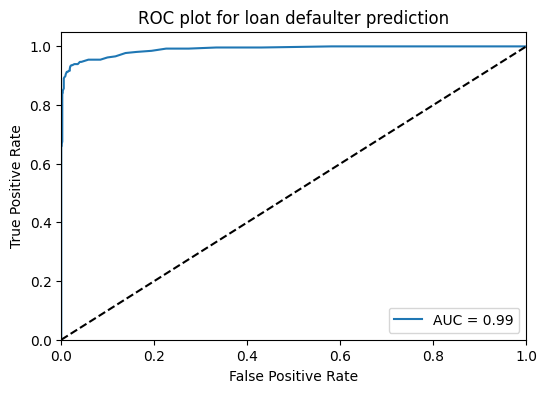

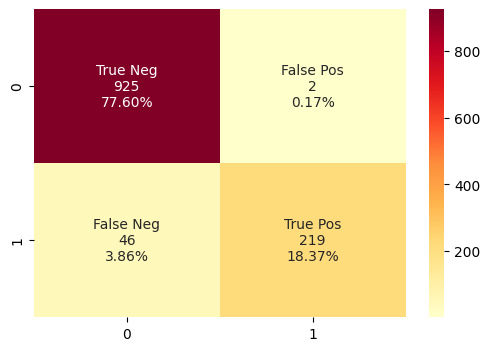

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       927
           1       0.99      0.83      0.90       265

    accuracy                           0.96      1192
   macro avg       0.97      0.91      0.94      1192
weighted avg       0.96      0.96      0.96      1192






Model 4: KNeighborsClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.725455 using {'weights': 'distance', 'n_neighbors': 15, 'metric': 'manhattan'}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.8213
Recall on Training Set: 1.0000
Recall on Test Set: 0.2453


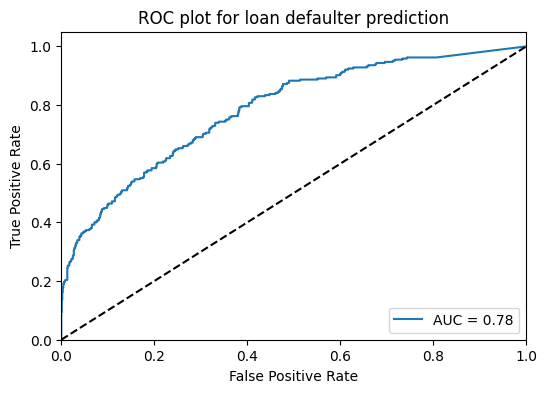

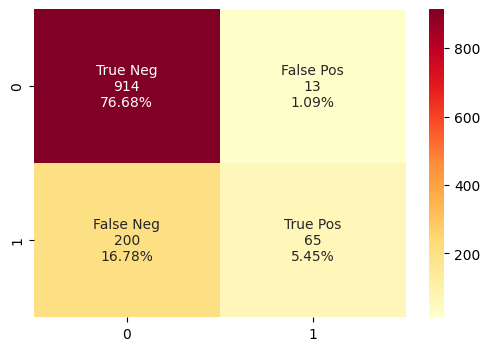

              precision    recall  f1-score   support

           0       0.82      0.99      0.90       927
           1       0.83      0.25      0.38       265

    accuracy                           0.82      1192
   macro avg       0.83      0.62      0.64      1192
weighted avg       0.82      0.82      0.78      1192






Model 5: SVC
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.613768 using {'C': 3.651137450906483, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy on Training Set: 0.8075
Accuracy on Test Set: 0.7785
Recall on Training Set: 0.0065
Recall on Test Set: 0.0038


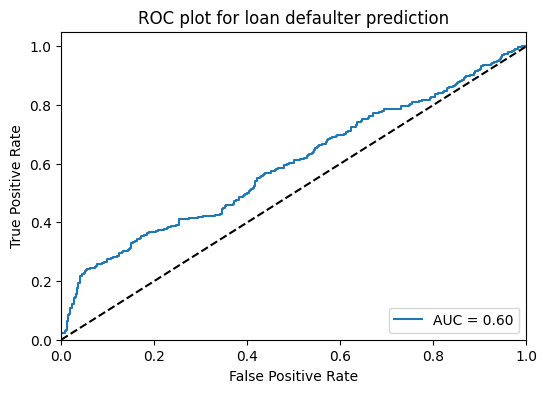

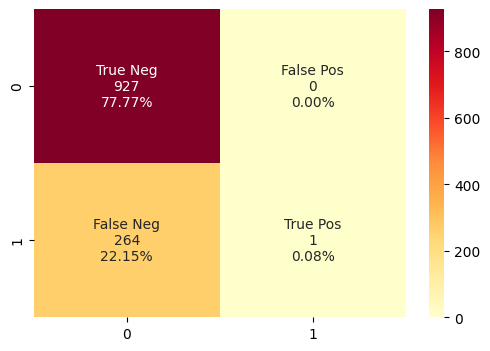

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       927
           1       1.00      0.00      0.01       265

    accuracy                           0.78      1192
   macro avg       0.89      0.50      0.44      1192
weighted avg       0.83      0.78      0.68      1192






Model 6: XGBClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.969105 using {'colsample_bytree': 0.6602660185175467, 'gamma': 0.3225376288325368, 'max_depth': 5, 'min_child_weight': 1}
Accuracy on Training Set: 0.9912
Accuracy on Test Set: 0.9581
Recall on Training Set: 0.9556
Recall on Test Set: 0.8226


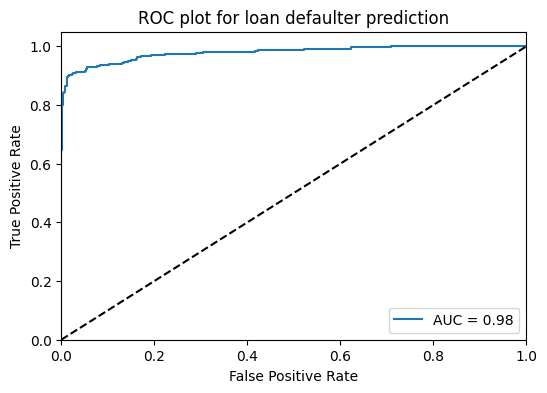

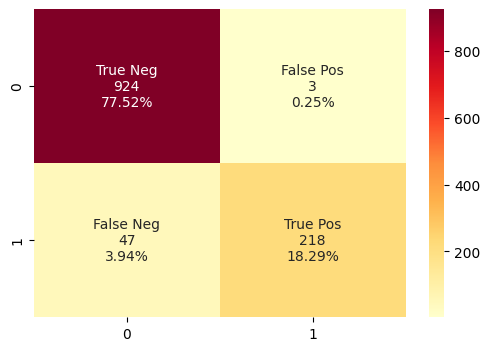

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       927
           1       0.99      0.82      0.90       265

    accuracy                           0.96      1192
   macro avg       0.97      0.91      0.94      1192
weighted avg       0.96      0.96      0.96      1192








In [253]:
build_and_train_model(models, param_random, X_train_2, y_train_2, X_test_2, y_test_2, 2)

<p>data3 - RandomSearch

Model 1: LogisticRegression
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.843490 using {'solver': 'liblinear', 'penalty': 'l1', 'C': 10000}
Accuracy on Training Set: 0.8553
Accuracy on Test Set: 0.8364
Recall on Training Set: 0.3810
Recall on Test Set: 0.3887


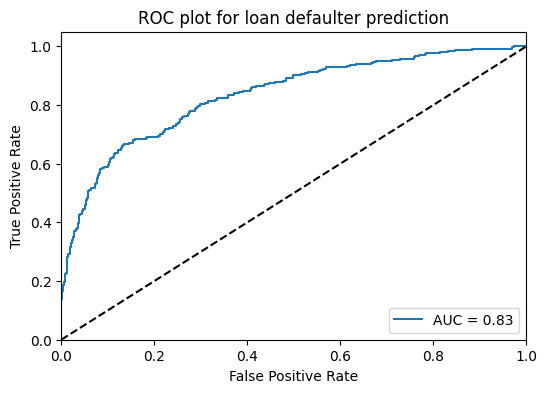

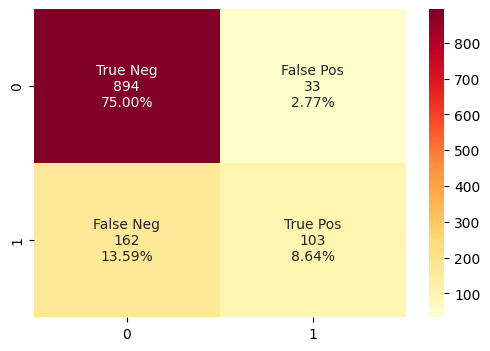

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       927
           1       0.76      0.39      0.51       265

    accuracy                           0.84      1192
   macro avg       0.80      0.68      0.71      1192
weighted avg       0.83      0.84      0.82      1192






Model 2: DecisionTreeClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.916646 using {'criterion': 'gini', 'max_depth': 41, 'max_features': 'log2', 'min_samples_leaf': 14, 'min_samples_split': 4}
Accuracy on Training Set: 0.9230
Accuracy on Test Set: 0.9077
Recall on Training Set: 0.6872
Recall on Test Set: 0.6717


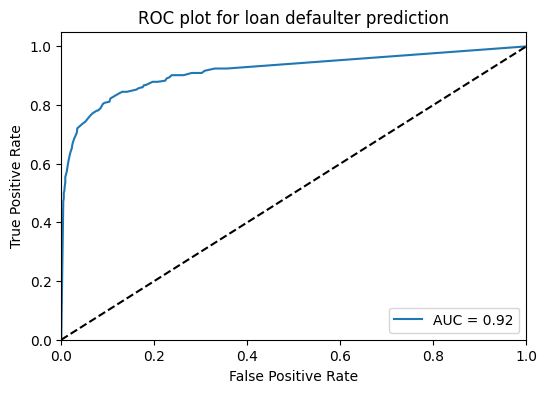

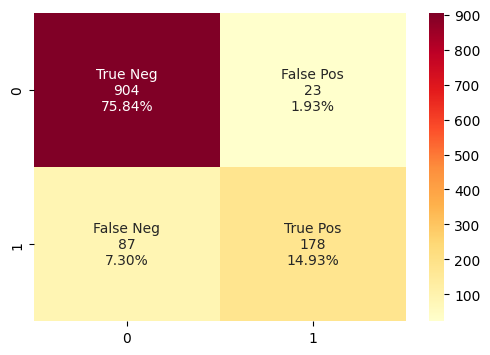

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       927
           1       0.89      0.67      0.76       265

    accuracy                           0.91      1192
   macro avg       0.90      0.82      0.85      1192
weighted avg       0.91      0.91      0.90      1192






Model 3: RandomForestClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.985084 using {'criterion': 'gini', 'max_depth': 50, 'n_estimators': 68}
Accuracy on Training Set: 0.9996
Accuracy on Test Set: 0.9622
Recall on Training Set: 0.9978
Recall on Test Set: 0.8377


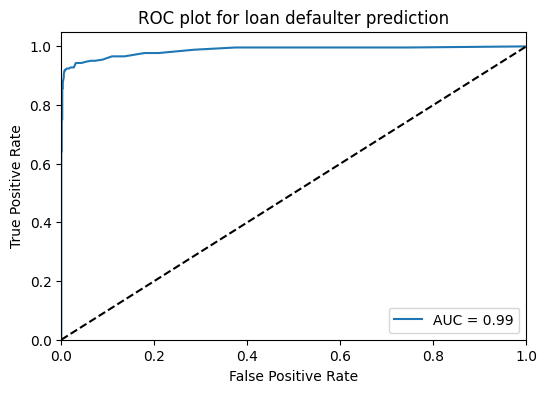

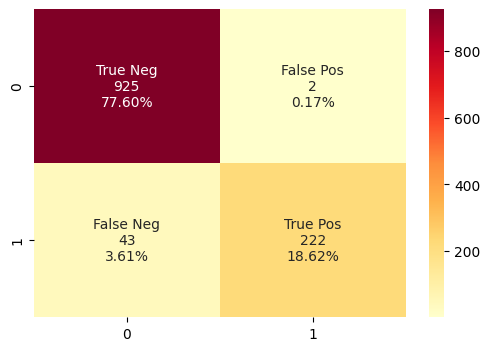

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       927
           1       0.99      0.84      0.91       265

    accuracy                           0.96      1192
   macro avg       0.97      0.92      0.94      1192
weighted avg       0.96      0.96      0.96      1192






Model 4: KNeighborsClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.715205 using {'weights': 'distance', 'n_neighbors': 8, 'metric': 'manhattan'}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.8230
Recall on Training Set: 1.0000
Recall on Test Set: 0.2943


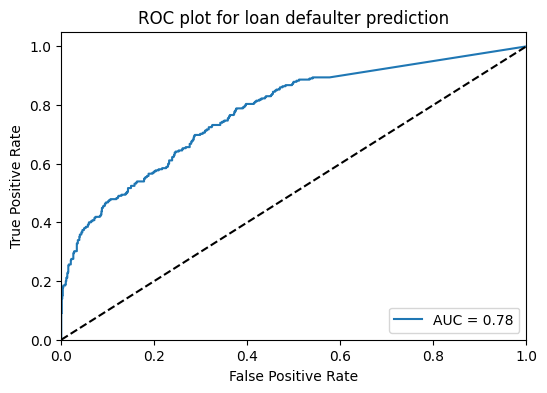

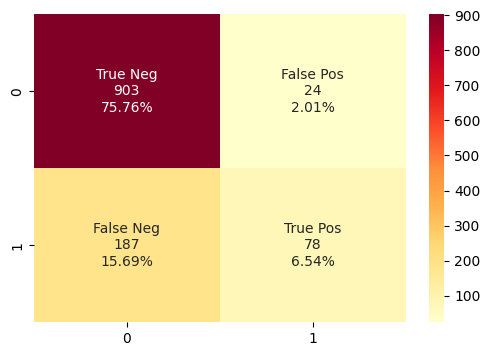

              precision    recall  f1-score   support

           0       0.83      0.97      0.90       927
           1       0.76      0.29      0.43       265

    accuracy                           0.82      1192
   macro avg       0.80      0.63      0.66      1192
weighted avg       0.81      0.82      0.79      1192






Model 5: SVC
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.616678 using {'C': 7.522027594022289, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy on Training Set: 0.8081
Accuracy on Test Set: 0.7794
Recall on Training Set: 0.0097
Recall on Test Set: 0.0075


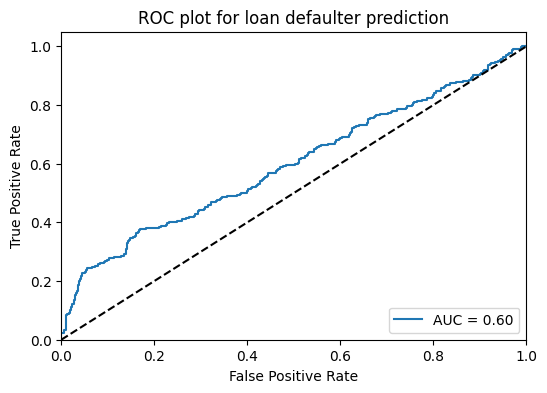

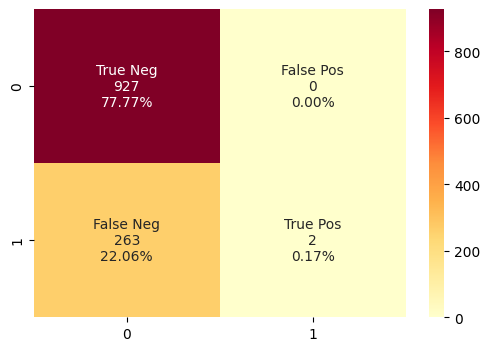

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       927
           1       1.00      0.01      0.01       265

    accuracy                           0.78      1192
   macro avg       0.89      0.50      0.45      1192
weighted avg       0.83      0.78      0.68      1192






Model 6: XGBClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.971973 using {'colsample_bytree': 0.6421134590402725, 'gamma': 0.7175116886959839, 'max_depth': 8, 'min_child_weight': 1}
Accuracy on Training Set: 0.9927
Accuracy on Test Set: 0.9606
Recall on Training Set: 0.9643
Recall on Test Set: 0.8340


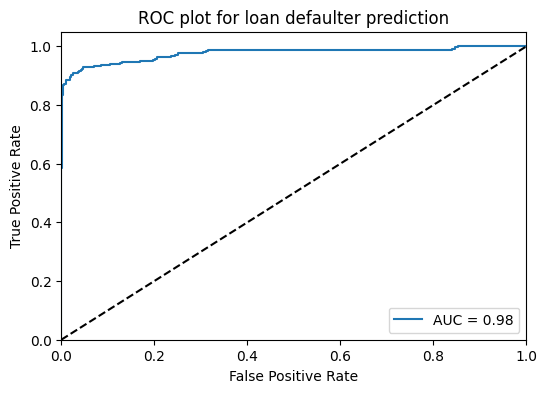

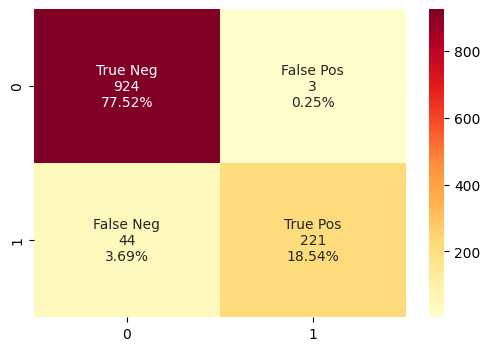

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       927
           1       0.99      0.83      0.90       265

    accuracy                           0.96      1192
   macro avg       0.97      0.92      0.94      1192
weighted avg       0.96      0.96      0.96      1192








In [252]:
build_and_train_model(models, param_random, X_train_3, y_train_3, X_test_3, y_test_3, 3)

<p>data4 - RandomSearch

Model 1: LogisticRegression
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.805332 using {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}
Accuracy on Training Set: 0.8406
Accuracy on Test Set: 0.8146
Recall on Training Set: 0.2976
Recall on Test Set: 0.2755


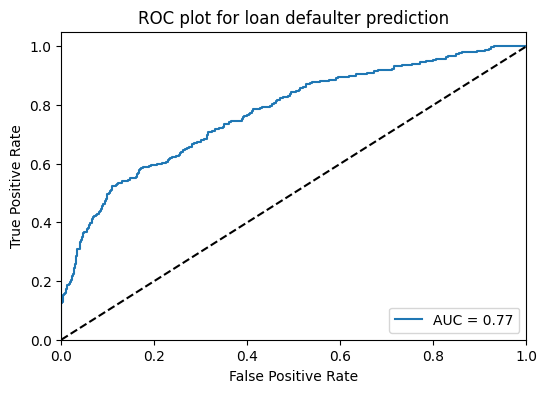

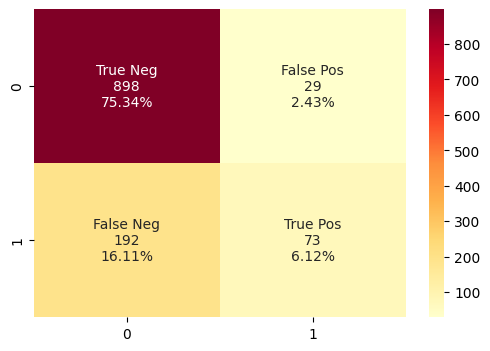

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       927
           1       0.72      0.28      0.40       265

    accuracy                           0.81      1192
   macro avg       0.77      0.62      0.64      1192
weighted avg       0.80      0.81      0.78      1192






Model 2: DecisionTreeClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.857327 using {'criterion': 'gini', 'max_depth': 32, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 12}
Accuracy on Training Set: 0.9054
Accuracy on Test Set: 0.8565
Recall on Training Set: 0.6515
Recall on Test Set: 0.5132


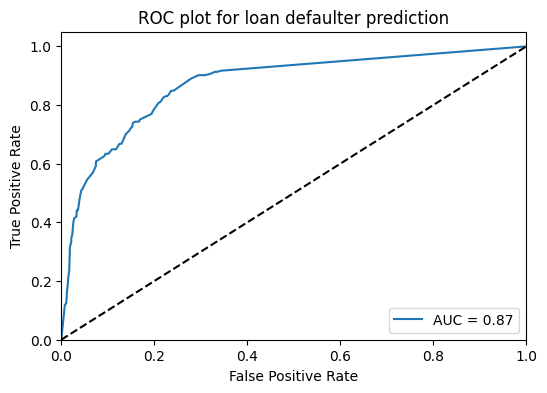

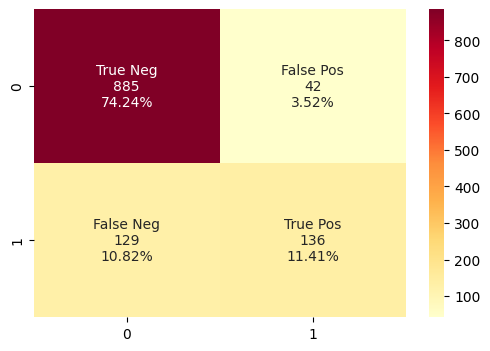

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       927
           1       0.76      0.51      0.61       265

    accuracy                           0.86      1192
   macro avg       0.82      0.73      0.76      1192
weighted avg       0.85      0.86      0.85      1192






Model 3: RandomForestClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.962426 using {'criterion': 'gini', 'max_depth': 66, 'n_estimators': 58}
Accuracy on Training Set: 0.9998
Accuracy on Test Set: 0.9077
Recall on Training Set: 0.9989
Recall on Test Set: 0.6679


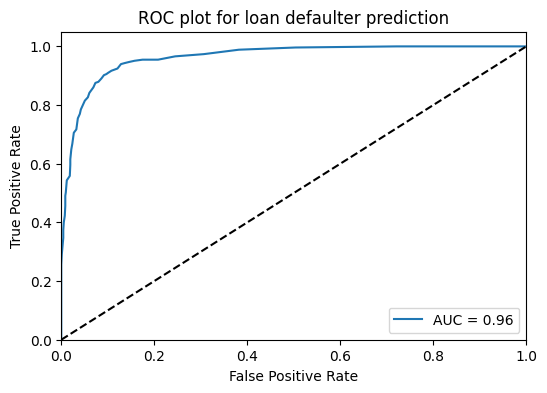

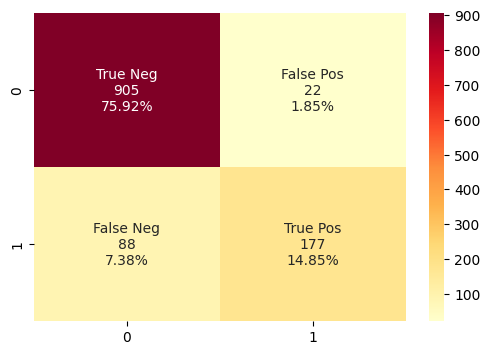

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       927
           1       0.89      0.67      0.76       265

    accuracy                           0.91      1192
   macro avg       0.90      0.82      0.85      1192
weighted avg       0.91      0.91      0.90      1192






Model 4: KNeighborsClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.920825 using {'weights': 'distance', 'n_neighbors': 6, 'metric': 'manhattan'}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.8876
Recall on Training Set: 1.0000
Recall on Test Set: 0.4943


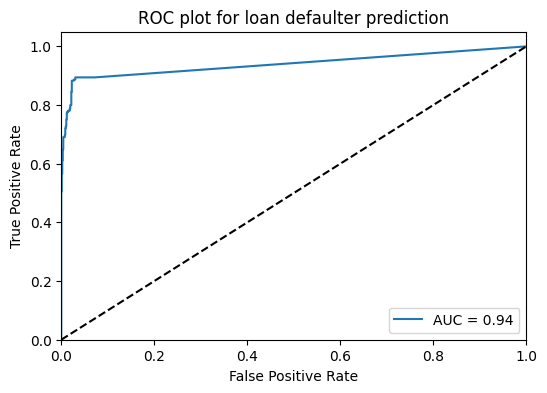

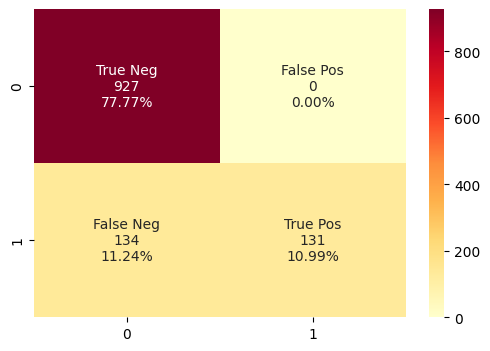

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       927
           1       1.00      0.49      0.66       265

    accuracy                           0.89      1192
   macro avg       0.94      0.75      0.80      1192
weighted avg       0.90      0.89      0.87      1192






Model 5: SVC
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.899304 using {'C': 9.588730189386164, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy on Training Set: 0.9383
Accuracy on Test Set: 0.8884
Recall on Training Set: 0.6916
Recall on Test Set: 0.5132


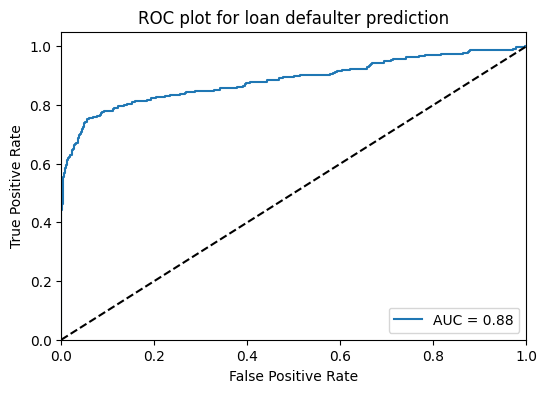

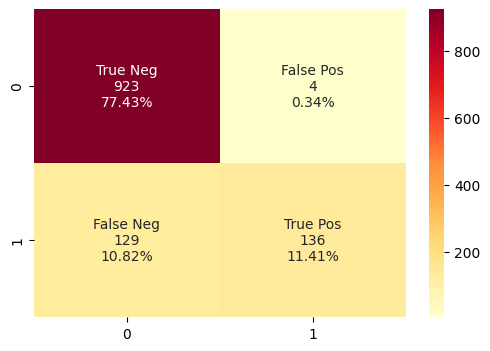

              precision    recall  f1-score   support

           0       0.88      1.00      0.93       927
           1       0.97      0.51      0.67       265

    accuracy                           0.89      1192
   macro avg       0.92      0.75      0.80      1192
weighted avg       0.90      0.89      0.87      1192






Model 6: XGBClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.947917 using {'colsample_bytree': 0.9055050857811459, 'gamma': 0.2439075400368127, 'max_depth': 8, 'min_child_weight': 2}
Accuracy on Training Set: 0.9943
Accuracy on Test Set: 0.8960
Recall on Training Set: 0.9729
Recall on Test Set: 0.6151


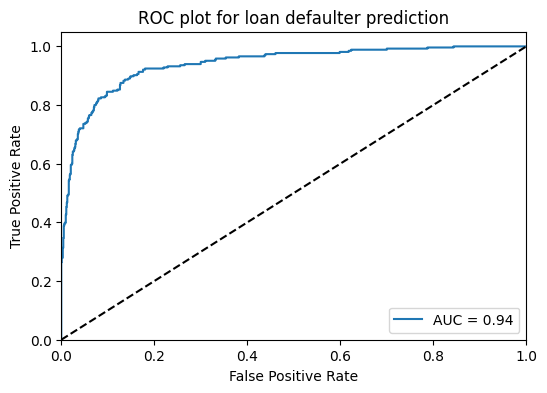

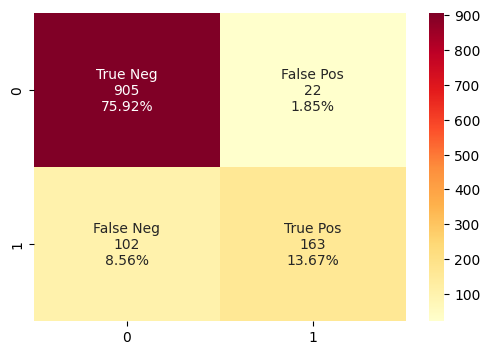

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       927
           1       0.88      0.62      0.72       265

    accuracy                           0.90      1192
   macro avg       0.89      0.80      0.83      1192
weighted avg       0.89      0.90      0.89      1192








In [224]:
build_and_train_model(models, param_random, X_train_4, y_train_4, X_test_4, y_test_4, 4)

<p>data5 - RandomSearch

Model 1: LogisticRegression
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.804524 using {'solver': 'liblinear', 'penalty': 'l1', 'C': 10}
Accuracy on Training Set: 0.8412
Accuracy on Test Set: 0.8146
Recall on Training Set: 0.3052
Recall on Test Set: 0.3094


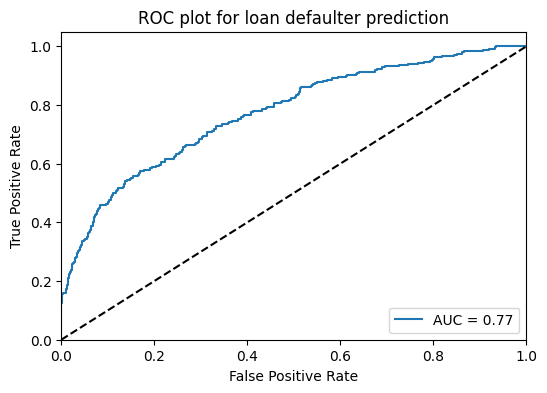

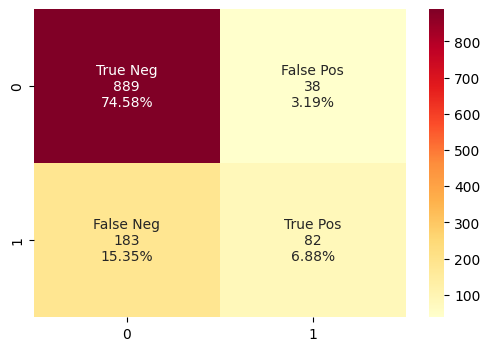

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       927
           1       0.68      0.31      0.43       265

    accuracy                           0.81      1192
   macro avg       0.76      0.63      0.66      1192
weighted avg       0.80      0.81      0.79      1192






Model 2: DecisionTreeClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.876168 using {'criterion': 'gini', 'max_depth': 47, 'max_features': None, 'min_samples_leaf': 13, 'min_samples_split': 17}
Accuracy on Training Set: 0.9065
Accuracy on Test Set: 0.8272
Recall on Training Set: 0.6732
Recall on Test Set: 0.3170


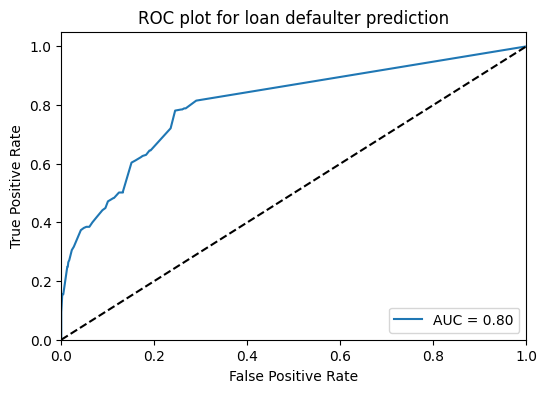

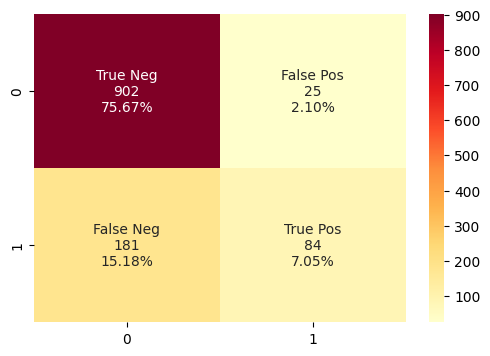

              precision    recall  f1-score   support

           0       0.83      0.97      0.90       927
           1       0.77      0.32      0.45       265

    accuracy                           0.83      1192
   macro avg       0.80      0.65      0.67      1192
weighted avg       0.82      0.83      0.80      1192






Model 3: RandomForestClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.960563 using {'criterion': 'gini', 'max_depth': 25, 'n_estimators': 95}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.8800
Recall on Training Set: 1.0000
Recall on Test Set: 0.4604


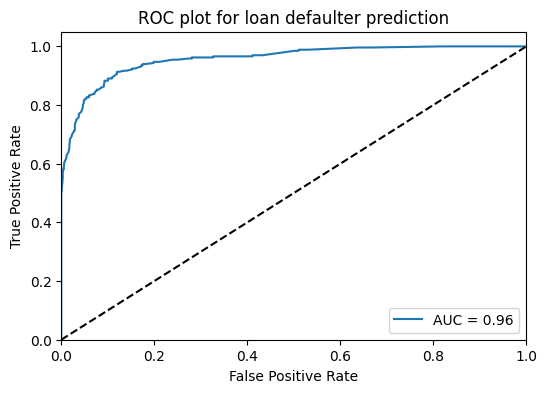

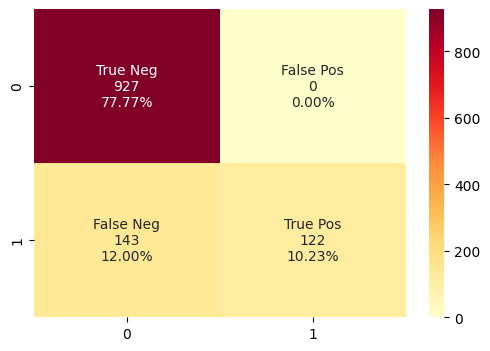

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       927
           1       1.00      0.46      0.63       265

    accuracy                           0.88      1192
   macro avg       0.93      0.73      0.78      1192
weighted avg       0.90      0.88      0.86      1192






Model 4: KNeighborsClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.653190 using {'weights': 'distance', 'n_neighbors': 19, 'metric': 'euclidean'}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.8054
Recall on Training Set: 1.0000
Recall on Test Set: 0.2264


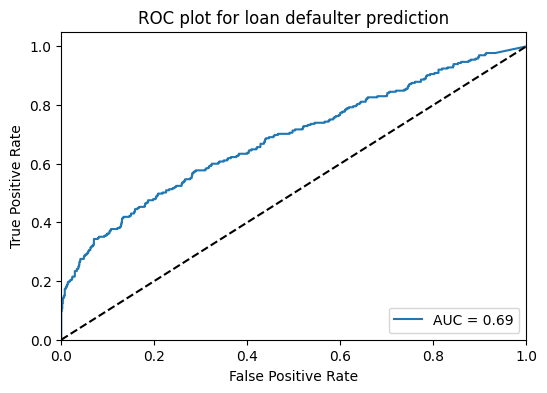

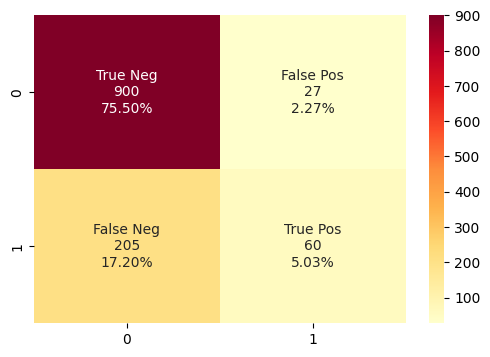

              precision    recall  f1-score   support

           0       0.81      0.97      0.89       927
           1       0.69      0.23      0.34       265

    accuracy                           0.81      1192
   macro avg       0.75      0.60      0.61      1192
weighted avg       0.79      0.81      0.76      1192






Model 5: SVC
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.556058 using {'C': 9.32570971270874, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy on Training Set: 0.8073
Accuracy on Test Set: 0.7794
Recall on Training Set: 0.0054
Recall on Test Set: 0.0075


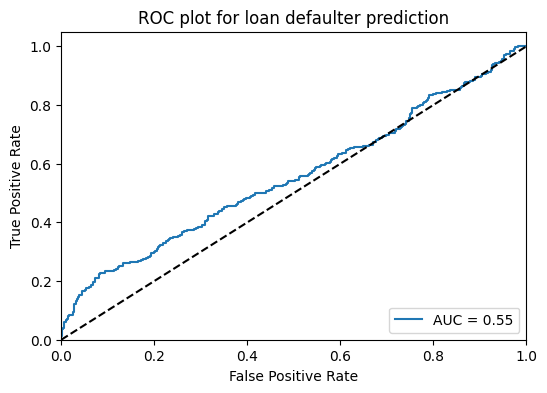

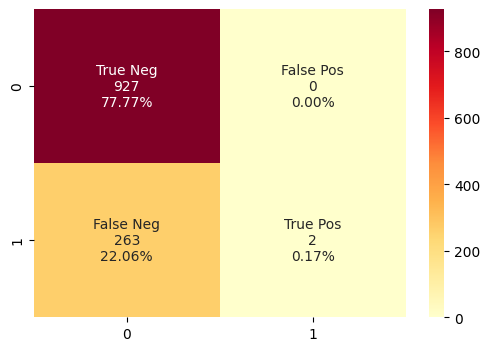

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       927
           1       1.00      0.01      0.01       265

    accuracy                           0.78      1192
   macro avg       0.89      0.50      0.45      1192
weighted avg       0.83      0.78      0.68      1192






Model 6: XGBClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.944542 using {'colsample_bytree': 0.9306595420925154, 'gamma': 0.028312307112157375, 'max_depth': 4, 'min_child_weight': 1}
Accuracy on Training Set: 0.9696
Accuracy on Test Set: 0.8582
Recall on Training Set: 0.8777
Recall on Test Set: 0.3736


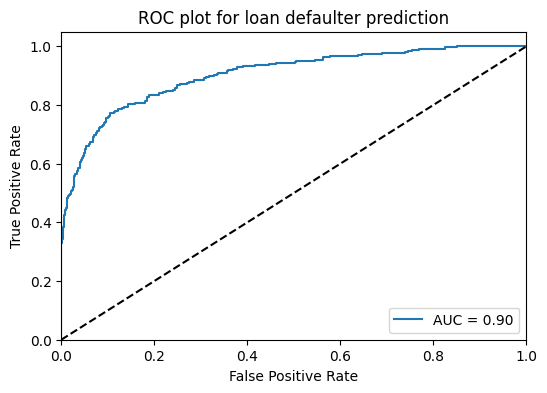

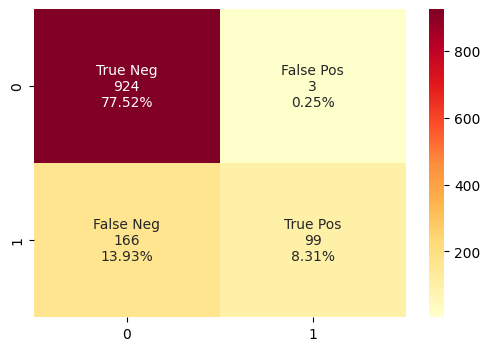

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       927
           1       0.97      0.37      0.54       265

    accuracy                           0.86      1192
   macro avg       0.91      0.69      0.73      1192
weighted avg       0.88      0.86      0.83      1192








In [225]:
build_and_train_model(models, param_random, X_train_5, y_train_5, X_test_5, y_test_5, 5)

<p>data6 - RandomSearch

Model 1: LogisticRegression
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.804802 using {'solver': 'liblinear', 'penalty': 'l1', 'C': 1000}
Accuracy on Training Set: 0.8425
Accuracy on Test Set: 0.8129
Recall on Training Set: 0.3117
Recall on Test Set: 0.3132


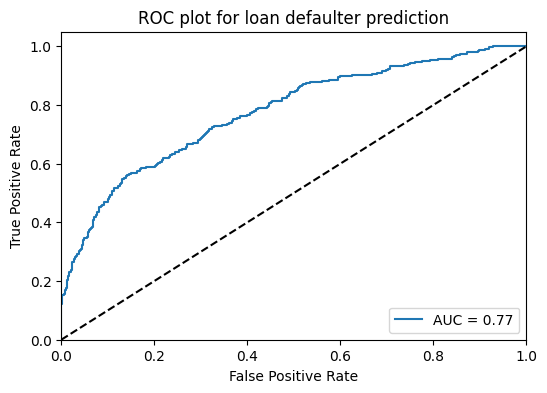

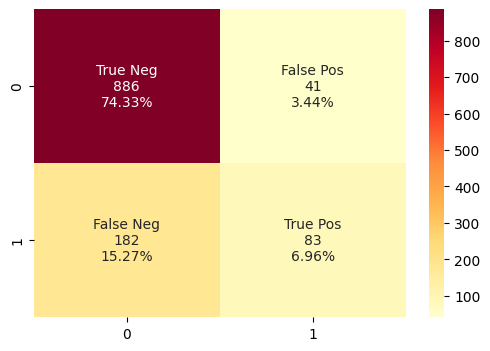

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       927
           1       0.67      0.31      0.43       265

    accuracy                           0.81      1192
   macro avg       0.75      0.63      0.66      1192
weighted avg       0.79      0.81      0.79      1192






Model 2: DecisionTreeClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.884042 using {'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 4}
Accuracy on Training Set: 0.9044
Accuracy on Test Set: 0.8280
Recall on Training Set: 0.6385
Recall on Test Set: 0.2642


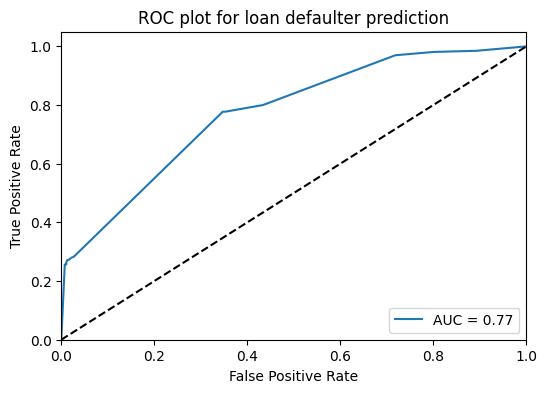

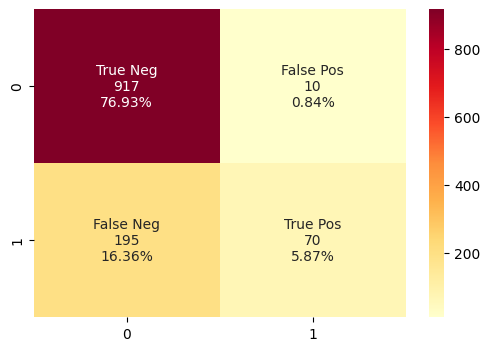

              precision    recall  f1-score   support

           0       0.82      0.99      0.90       927
           1       0.88      0.26      0.41       265

    accuracy                           0.83      1192
   macro avg       0.85      0.63      0.65      1192
weighted avg       0.84      0.83      0.79      1192






Model 3: RandomForestClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.959223 using {'criterion': 'entropy', 'max_depth': 29, 'n_estimators': 88}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.8641
Recall on Training Set: 1.0000
Recall on Test Set: 0.3925


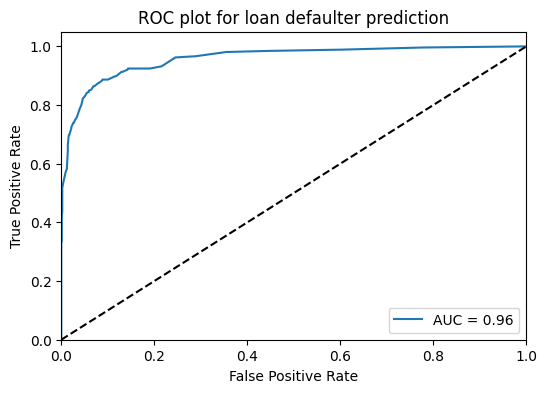

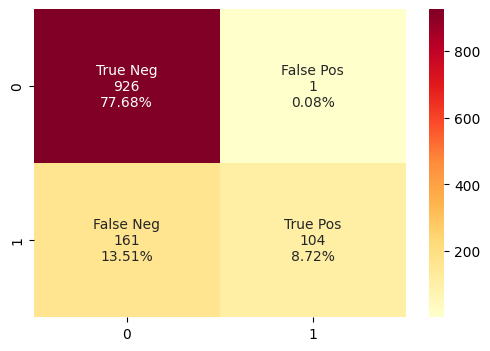

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       927
           1       0.99      0.39      0.56       265

    accuracy                           0.86      1192
   macro avg       0.92      0.70      0.74      1192
weighted avg       0.88      0.86      0.84      1192






Model 4: KNeighborsClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.690579 using {'weights': 'distance', 'n_neighbors': 15, 'metric': 'manhattan'}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.8163
Recall on Training Set: 1.0000
Recall on Test Set: 0.2189


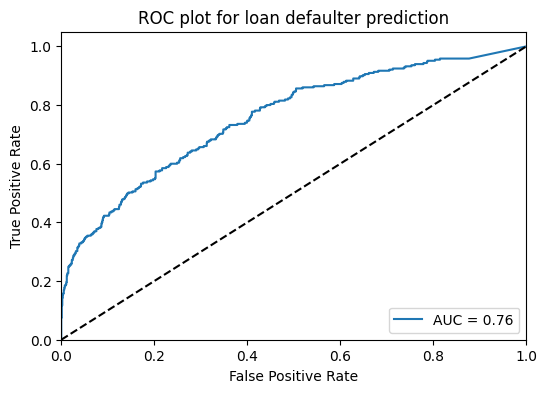

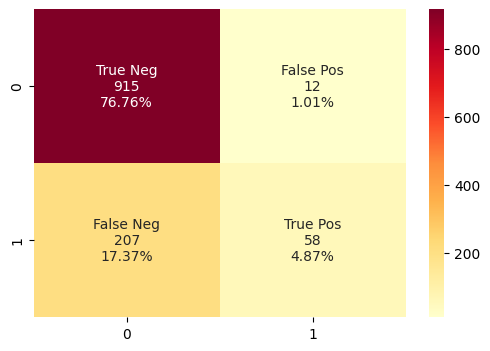

              precision    recall  f1-score   support

           0       0.82      0.99      0.89       927
           1       0.83      0.22      0.35       265

    accuracy                           0.82      1192
   macro avg       0.82      0.60      0.62      1192
weighted avg       0.82      0.82      0.77      1192






Model 5: SVC
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.587742 using {'C': 1.281288163193296, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy on Training Set: 0.8070
Accuracy on Test Set: 0.7785
Recall on Training Set: 0.0043
Recall on Test Set: 0.0038


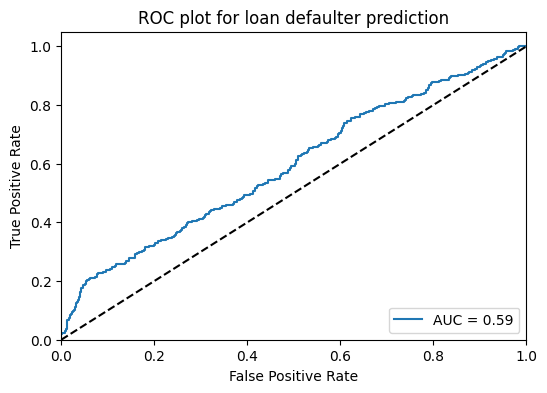

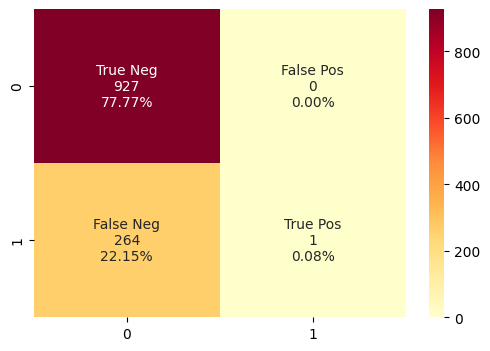

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       927
           1       1.00      0.00      0.01       265

    accuracy                           0.78      1192
   macro avg       0.89      0.50      0.44      1192
weighted avg       0.83      0.78      0.68      1192






Model 6: XGBClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.945160 using {'colsample_bytree': 0.9029332044593179, 'gamma': 0.15865613550116286, 'max_depth': 7, 'min_child_weight': 9}
Accuracy on Training Set: 0.9874
Accuracy on Test Set: 0.8750
Recall on Training Set: 0.9470
Recall on Test Set: 0.4491


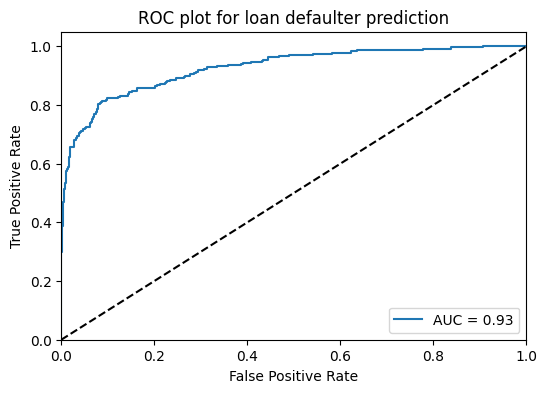

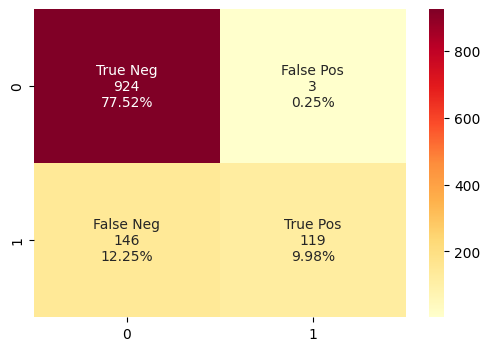

              precision    recall  f1-score   support

           0       0.86      1.00      0.93       927
           1       0.98      0.45      0.61       265

    accuracy                           0.88      1192
   macro avg       0.92      0.72      0.77      1192
weighted avg       0.89      0.88      0.86      1192








In [226]:
build_and_train_model(models, param_random, X_train_6, y_train_6, X_test_6, y_test_6, 6)

<p>data7 - RandomSearch

Model 1: LogisticRegression
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.812472 using {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}
Accuracy on Training Set: 0.8482
Accuracy on Test Set: 0.8302
Recall on Training Set: 0.3401
Recall on Test Set: 0.3039


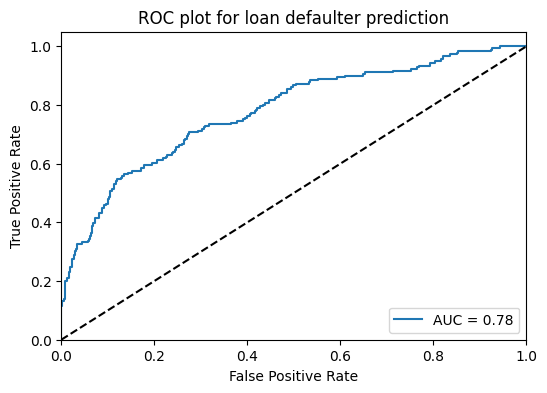

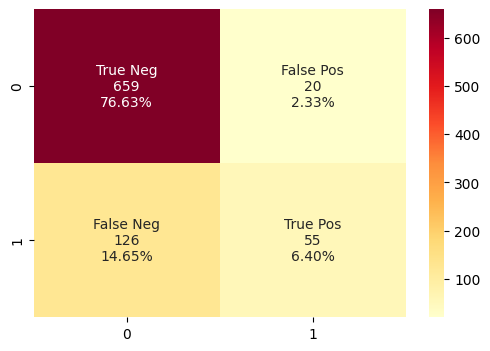

              precision    recall  f1-score   support

           0       0.84      0.97      0.90       679
           1       0.73      0.30      0.43       181

    accuracy                           0.83       860
   macro avg       0.79      0.64      0.66       860
weighted avg       0.82      0.83      0.80       860






Model 2: DecisionTreeClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.823979 using {'criterion': 'entropy', 'max_depth': 43, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 14}
Accuracy on Training Set: 0.9268
Accuracy on Test Set: 0.8500
Recall on Training Set: 0.7279
Recall on Test Set: 0.5635


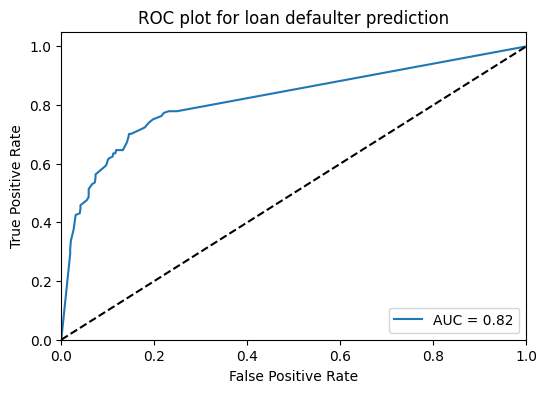

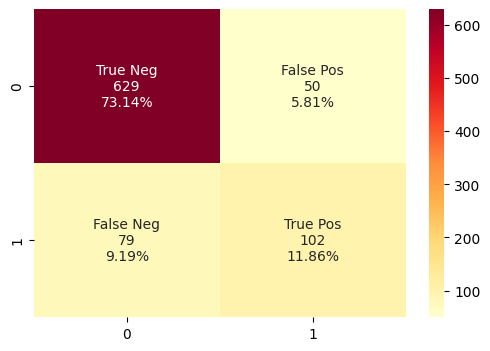

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       679
           1       0.67      0.56      0.61       181

    accuracy                           0.85       860
   macro avg       0.78      0.74      0.76       860
weighted avg       0.84      0.85      0.85       860






Model 3: RandomForestClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.971667 using {'criterion': 'entropy', 'max_depth': 55, 'n_estimators': 80}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.9174
Recall on Training Set: 1.0000
Recall on Test Set: 0.6243


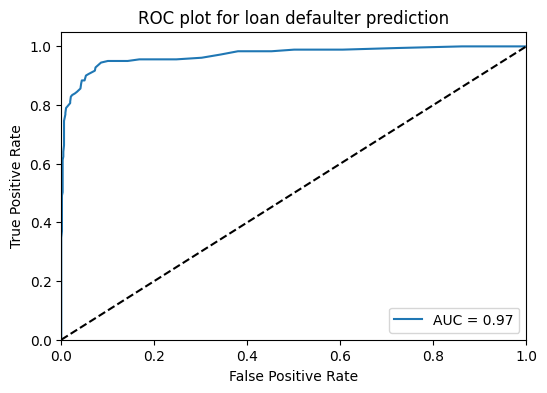

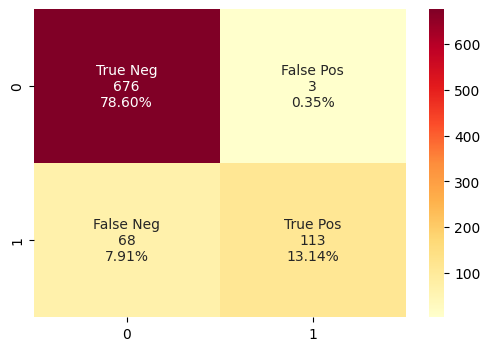

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       679
           1       0.97      0.62      0.76       181

    accuracy                           0.92       860
   macro avg       0.94      0.81      0.86       860
weighted avg       0.92      0.92      0.91       860






Model 4: KNeighborsClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.920527 using {'weights': 'distance', 'n_neighbors': 14, 'metric': 'manhattan'}
Accuracy on Training Set: 1.0000
Accuracy on Test Set: 0.8465
Recall on Training Set: 1.0000
Recall on Test Set: 0.2707


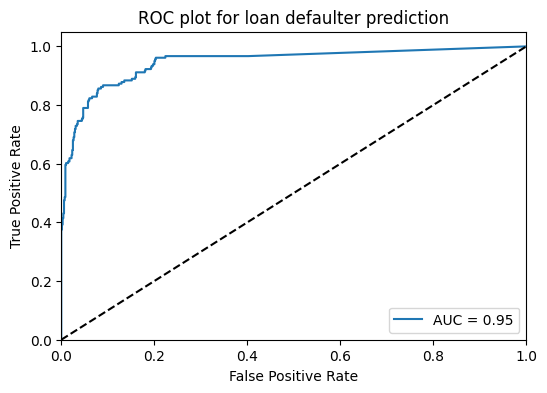

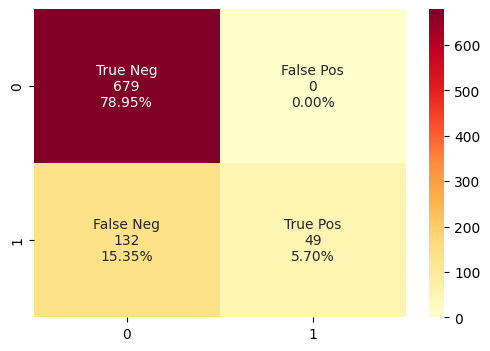

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       679
           1       1.00      0.27      0.43       181

    accuracy                           0.85       860
   macro avg       0.92      0.64      0.67       860
weighted avg       0.87      0.85      0.81       860






Model 5: SVC
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.990657 using {'C': 3.8561926716745654, 'gamma': 1.0, 'kernel': 'rbf'}
Accuracy on Training Set: 0.9992
Accuracy on Test Set: 0.9640
Recall on Training Set: 0.9957
Recall on Test Set: 0.8729


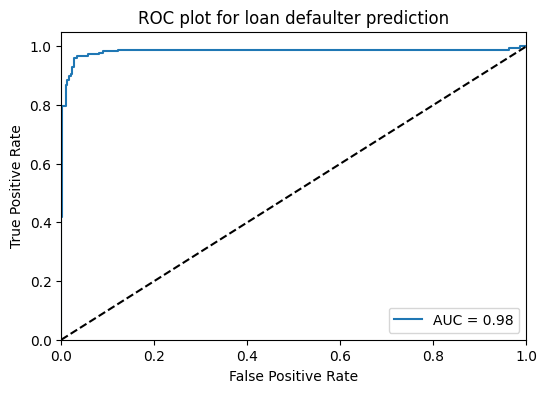

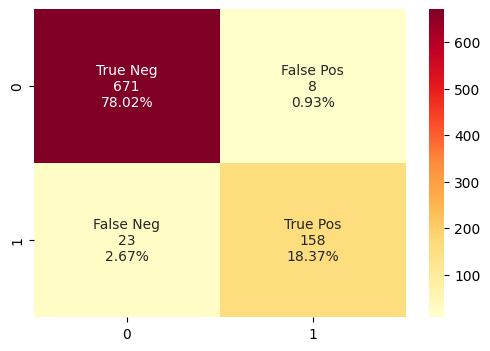

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       679
           1       0.95      0.87      0.91       181

    accuracy                           0.96       860
   macro avg       0.96      0.93      0.94       860
weighted avg       0.96      0.96      0.96       860






Model 6: XGBClassifier
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best train: 0.920062 using {'colsample_bytree': 0.8532634797588031, 'gamma': 0.8824407901720773, 'max_depth': 9, 'min_child_weight': 2}
Accuracy on Training Set: 0.9729
Accuracy on Test Set: 0.8837
Recall on Training Set: 0.8611
Recall on Test Set: 0.4586


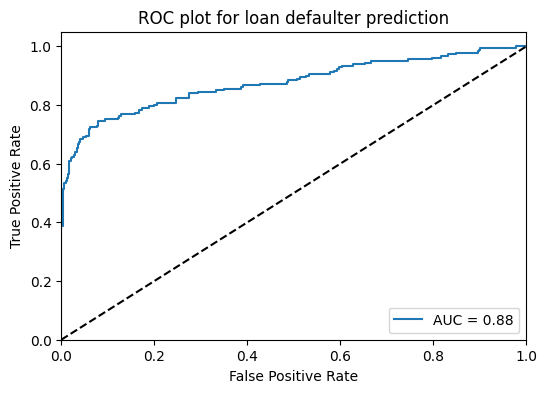

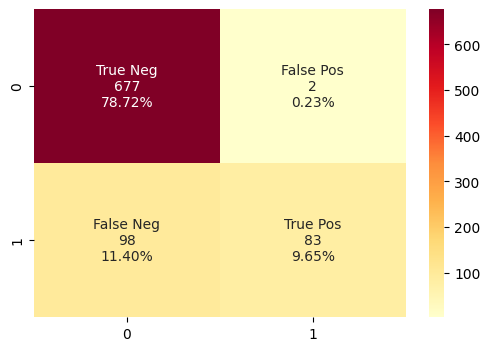

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       679
           1       0.98      0.46      0.62       181

    accuracy                           0.88       860
   macro avg       0.93      0.73      0.78       860
weighted avg       0.90      0.88      0.87       860








In [227]:
build_and_train_model(models, param_random, X_train_7, y_train_7, X_test_7, y_test_7, 7)

<p>Với bộ dữ liệu data1 - GridSearch

In [322]:
data1 = {
    'Model': ['LogisticRegression', 'DecisionTree', 'RandomForest', 'KNN', 'SVC', 'XGBClassifier'],
    'AUC': [0.77, 0.78, 0.91, 0.9, 0.97, 0.88],
    'Accuracy_train': [0.84, 0.93, 1.0, 1.0, 0.99, 1],
    'Accuracy_test': [0.81, 0.82, 0.87, 0.85, 0.84, 0.87],
    'Recall': [0.25, 0.51, 0.52, 0.36, 0.3, 0.5]
}

pd.DataFrame(data1)

Model   AUC  Accuracy_train  Accuracy_test  Recall
0  LogisticRegression  0.77            0.84           0.81    0.25
1        DecisionTree  0.78            0.93           0.82    0.51
2        RandomForest  0.91            1.00           0.87    0.52
3                 KNN  0.90            1.00           0.85    0.36
4                 SVC  0.97            0.99           0.84    0.30
5       XGBClassifier  0.88            1.00           0.87    0.50

<p> Với bộ dữ liệu data2 - GridSearch

In [323]:
data2 = {
    'Model': ['LogisticRegression', 'DecisionTree', 'RandomForest', 'KNN', 'SVC', 'XGBClassifier'],
    'AUC': [0.83, 0.91, 0.97, 0.78, 0.51, 0.98],
    'Accuracy_train': [0.85, 0.97, 1.0, 1.0, 1.0, 1.0],
    'Accuracy_test': [0.84, 0.95, 0.96, 0.82, 0.77, 0.97],
    'Recall': [0.39, 0.79, 0.85, 0.29, 0, 87]
}

pd.DataFrame(data2)

Model   AUC  Accuracy_train  Accuracy_test  Recall
0  LogisticRegression  0.83            0.85           0.84    0.39
1        DecisionTree  0.91            0.97           0.95    0.79
2        RandomForest  0.97            1.00           0.96    0.85
3                 KNN  0.78            1.00           0.82    0.29
4                 SVC  0.51            1.00           0.77    0.00
5       XGBClassifier  0.98            1.00           0.97   87.00

<p>Với bộ dữ liệu data3

In [324]:
data3 = {
    'Model': ['LogisticRegression', 'DecisionTree', 'RandomForest', 'KNN', 'SVC', 'XGBClassifier'],
    'AUC': [0.83, 0.91, 0.97, 0.78, 0.51, 0.98],
    'Accuracy_train': [0.85, 0.97, 1.0, 1.0, 1, 1],
    'Accuracy_test': [0.84, 0.95, 0.96, 0.82, 0.77, 0.96],
    'Recall': [0.38, 0.79, 0.83, 0.29, 0, 0.84]
}

pd.DataFrame(data3)

Model   AUC  Accuracy_train  Accuracy_test  Recall
0  LogisticRegression  0.83            0.85           0.84    0.38
1        DecisionTree  0.91            0.97           0.95    0.79
2        RandomForest  0.97            1.00           0.96    0.83
3                 KNN  0.78            1.00           0.82    0.29
4                 SVC  0.51            1.00           0.77    0.00
5       XGBClassifier  0.98            1.00           0.96    0.84

<p>Với bộ dữ liệu data4

In [325]:
data4 = {
    'Model': ['LogisticRegression', 'DecisionTree', 'RandomForest', 'KNN', 'SVC', 'XGBClassifier'],
    'AUC': [0.77, 0.88, 0.96, 0.94, 0.98, 0.5],
    'Accuracy_train': [0.84, 0.92, 1.0, 1.0, 0.99, 1],
    'Accuracy_test': [0.81, 0.88, 0.91, 0.87, 0.93, 0.9],
    'Recall': [0.28, 0.59, 0.69, 0.42, 0.72, 0.62]
}

pd.DataFrame(data4)

Model   AUC  Accuracy_train  Accuracy_test  Recall
0  LogisticRegression  0.77            0.84           0.81    0.28
1        DecisionTree  0.88            0.92           0.88    0.59
2        RandomForest  0.96            1.00           0.91    0.69
3                 KNN  0.94            1.00           0.87    0.42
4                 SVC  0.98            0.99           0.93    0.72
5       XGBClassifier  0.50            1.00           0.90    0.62

<p>Với bộ dữ liệu data5

In [326]:
data5 = {
    'Model': ['LogisticRegression', 'DecisionTree', 'RandomForest', 'KNN', 'SVC', 'XGBClassifier'],
    'AUC': [0.77, 0.77, 0.93, 0.68, 0.54, 0.93],
    'Accuracy_train': [0.82, 0.93, 1.0, 1.0, 1.0, 1.0],
    'Accuracy_test': [0.81, 0.84, 0.87, 0.80, 0.77, 0.88],
    'Recall': [0.31, 0.31, 0.43, 0.27, 0, 0.46]
}

pd.DataFrame(data5)

Model   AUC  Accuracy_train  Accuracy_test  Recall
0  LogisticRegression  0.77            0.82           0.81    0.31
1        DecisionTree  0.77            0.93           0.84    0.31
2        RandomForest  0.93            1.00           0.87    0.43
3                 KNN  0.68            1.00           0.80    0.27
4                 SVC  0.54            1.00           0.77    0.00
5       XGBClassifier  0.93            1.00           0.88    0.46

<p>Với bộ dữ liệu data6

In [327]:
data6 = {
    'Model': ['LogisticRegression', 'DecisionTree', 'RandomForest', 'KNN', 'SVC', 'XGBClassifier'],
    'AUC': [0.78, 0.79, 0.94, 0.74, 0.5, 0.94],
    'Accuracy_train': [0.84, 0.93, 1.0, 1.0, 1.0, 1.0],
    'Accuracy_test': [0.81, 0.84, 0.87, 0.82, 0.77, 0.88],
    'Recall': [0.31, 0.37, 0.45, 0.26, 0, 0.45]
}

pd.DataFrame(data6)

Model   AUC  Accuracy_train  Accuracy_test  Recall
0  LogisticRegression  0.78            0.84           0.81    0.31
1        DecisionTree  0.79            0.93           0.84    0.37
2        RandomForest  0.94            1.00           0.87    0.45
3                 KNN  0.74            1.00           0.82    0.26
4                 SVC  0.50            1.00           0.77    0.00
5       XGBClassifier  0.94            1.00           0.88    0.45

<p>Với bộ dữ liệu data7

In [328]:
data7 = {
    'Model': ['LogisticRegression', 'DecisionTree', 'RandomForest', 'KNN', 'SVC', 'XGBClassifier'],
    'AUC': [0.78, 0.81, 0.96, 0.95, 0.98, 0.89],
    'Accuracy_train': [0.85, 0.94, 1.0, 1.0, 1.0, 1.0],
    'Accuracy_test': [0.83, 0.84, 0.91, 0.88, 0.97, 0.89],
    'Recall': [0.3, 0.53, 0.6, 0.43, 0.87, 0.52]
}

pd.DataFrame(data7)

Model   AUC  Accuracy_train  Accuracy_test  Recall
0  LogisticRegression  0.78            0.85           0.83    0.30
1        DecisionTree  0.81            0.94           0.84    0.53
2        RandomForest  0.96            1.00           0.91    0.60
3                 KNN  0.95            1.00           0.88    0.43
4                 SVC  0.98            1.00           0.97    0.87
5       XGBClassifier  0.89            1.00           0.89    0.52

<h3>Credit Score for dataset

In [228]:
def credit_score(p):
    factor = 25 / np.log(2)
    offset = 600 - factor * np.log(50)
    val = (1-p) / p
    score = offset + factor * np.log(val)
    return round(score)

In [302]:
X_test_2_xgb = X_test_2.copy()

In [303]:
model_grid2 = pickle.load(open('./model/XGBClassifier2.pkl', 'rb'))
y_pred_prob_test = model_grid2.predict_proba(X_test_2_xgb)[:,1]
y_pred_test = model_grid2.predict(X_test_2_xgb)
X_test_2_xgb["BAD"] = y_pred_test
X_test_2_xgb["PRO"] = y_pred_prob_test
X_test_2_xgb["SCORE"] = X_test_2_xgb["PRO"].apply(lambda x: credit_score(x))
X_test_2_xgb["RISK"] = X_test_2_xgb["SCORE"].apply(lambda x: 'high' if x <= 430 else 'medium' if x <= 679 else 'lower')

In [304]:
X_test_2_xgb

LOAN   MORTDUE     VALUE   YOJ  DEROG  DELINQ       CLAGE  NINQ  CLNO  \
1344  10600   44696.0   57686.0   0.0    0.0     0.0  170.340974   0.0  20.0   
625    7800   38506.0   50309.0  11.0    0.0     0.0  231.001195   0.0  32.0   
5908  65100   67389.0  142740.0   9.0    0.0     1.0  116.906104   0.0  11.0   
2991  16400   63574.0   88586.0   7.0    0.0     0.0  298.146552   0.0  20.0   
1545  11300   67356.0   28600.0  20.0    0.0     0.0  190.031218   0.0  15.0   
...     ...       ...       ...   ...    ...     ...         ...   ...   ...   
3688  19400  109812.0  172705.0   5.0    0.0     0.0  204.105415   3.0  23.0   
2404  14500   71511.0   88632.0   9.0    0.0     0.0   85.748149   2.0  11.0   
1173  10000   10000.0   68250.0  20.0    0.0     2.0  398.800000   1.0  12.0   
3209  17200   43996.0   79419.0   5.0    0.0     0.0  140.973401   0.0   9.0   
2728  15400   67356.0   55421.0   2.0    0.0     0.0   81.278511   2.0   9.0   

        DEBTINC  ...  JOB_Mgr  JOB_Office  JOB_Other  JOB_ProfExe  JOB_Sales  \
1344  37.792555  ...    False        True      False        False      False   
625   35.906116  ...    False       False       True        False      False   
5908  43.368718  ...    False        True      False        False      False   
2991  29.153372  ...    False       False       True        False      False   
1545  39.008673  ...    False        True      False        False      False   
...         ...  ...      ...         ...        ...          ...        ...   
3688  43.338407  ...    False        True      False        False      False   
2404  31.547812  ...    False       False       True        False      False   
1173  35.000000  ...    False       False      False         True      False   
3209  28.662173  ...     True       False      False        False      False   
2728  38.723895  ...    False        True      False        False      False   

      JOB_Self  BAD       PRO  SCORE    RISK  
1344     False    0  0.041434    572  medium  
625      False    0  0.016675    606  medium  
5908     False    0  0.144163    523  medium  
2991     False    0  0.000177    770   lower  
1545     False    0  0.003237    666  medium  
...        ...  ...       ...    ...     ...  
3688     False    0  0.008127    632  medium  
2404     False    0  0.009120    628  medium  
1173     False    0  0.048063    567  medium  
3209     False    0  0.003227    666  medium  
2728     False    0  0.008546    630  medium  

[1192 rows x 22 columns]

In [305]:
X_test_2_xgb['SCORE'].min()

116

In [306]:
X_test_2_xgb['SCORE'].max()

825

In [317]:
X_train_2_xgb = X_train_2.copy()

In [318]:
y_pred_prob_train = model_grid2.predict_proba(X_train_2_xgb)[:,1]
y_pred_train = model_grid2.predict(X_train_2_xgb)
X_train_2_xgb["BAD"] = y_pred_train
X_train_2_xgb["PRO"] = y_pred_prob_train
X_train_2_xgb["SCORE"] = X_train_2_xgb["PRO"].apply(lambda x: credit_score(x))
X_train_2_xgb["RISK"] = X_train_2_xgb["SCORE"].apply(lambda x: 'high' if x <= 430 else 'medium' if x <= 679 else 'lower')

In [319]:
X_train_2_xgb['SCORE'].min()

88

In [320]:
X_train_2_xgb['SCORE'].max()

843

In [321]:
X_train_2_xgb

LOAN  MORTDUE     VALUE   YOJ  DEROG  DELINQ       CLAGE  NINQ  CLNO  \
944    9100  62976.0   77829.0   0.0    0.0     2.0  131.193496   0.0  23.0   
5755  43800   5884.0   64890.0   7.0    0.0     0.0  309.827548   0.0  19.0   
2259  13800  75142.0   95667.0  19.0    0.0     0.0  230.457554  10.0  24.0   
12     2000  45000.0   55000.0   3.0    0.0     0.0   86.066667   2.0  25.0   
1117   9900  47367.0  114837.0   4.0    0.0     0.0  210.435534   0.0  10.0   
...     ...      ...       ...   ...    ...     ...         ...   ...   ...   
3772  20000  99300.0  139150.0  10.0    0.0     0.0  162.366667   1.0  23.0   
5191  28000  49764.0   74526.0  24.0    0.0     1.0  294.594783   1.0  30.0   
5226  28300  71973.0  119224.0   4.0    0.0     0.0   89.379952   2.0  32.0   
5390  31100  73386.0  108864.0   5.0    0.0     0.0  119.539518  10.0  21.0   
860    8700  77930.0   80164.0  20.0    0.0     0.0  350.528410   1.0  47.0   

        DEBTINC  ...  JOB_Mgr  JOB_Office  JOB_Other  JOB_ProfExe  JOB_Sales  \
944   26.090419  ...     True       False      False        False      False   
5755  16.160451  ...    False        True      False        False      False   
2259  33.383314  ...     True       False      False        False      False   
12    38.000000  ...    False       False       True        False      False   
1117  25.042109  ...    False       False      False         True      False   
...         ...  ...      ...         ...        ...          ...        ...   
3772  34.000000  ...    False       False      False         True      False   
5191  37.611309  ...    False       False       True        False      False   
5226  39.981059  ...    False       False       True        False      False   
5390  42.826601  ...    False       False       True        False      False   
860   29.662360  ...    False       False       True        False      False   

      JOB_Self  BAD       PRO  SCORE    RISK  
944      False    0  0.029660    585  medium  
5755     False    0  0.000508    732   lower  
2259     False    0  0.001433    695   lower  
12       False    1  0.999270    198    high  
1117     False    0  0.000572    728   lower  
...        ...  ...       ...    ...     ...  
3772     False    0  0.000131    781   lower  
5191     False    0  0.010138    624  medium  
5226     False    0  0.000407    740   lower  
5390     False    0  0.008482    631  medium  
860      False    0  0.001722    688   lower  

[4768 rows x 22 columns]

In [329]:
def distribution_score(x0, x1):
    fig, axes = plt.subplots(1,2,figsize=(12, 4))

    sns.histplot(x0["SCORE"], bins=15, kde=True, ax=axes[0])
    axes[0].set_title(f"Phân phối của score với class 0 - trả được nợ")
    axes[0].set_ylabel("Tần suất")
    axes[0].set_xlabel(None)
    

    sns.histplot(x1["SCORE"], bins=15, kde=True, ax=axes[1])
    axes[1].set_title(f"Phân phối của score với class 1 - vỡ nợ")
    axes[1].set_ylabel("Tần suất")
    axes[1].set_xlabel(None)
    

    plt.tight_layout()
    plt.show()
    

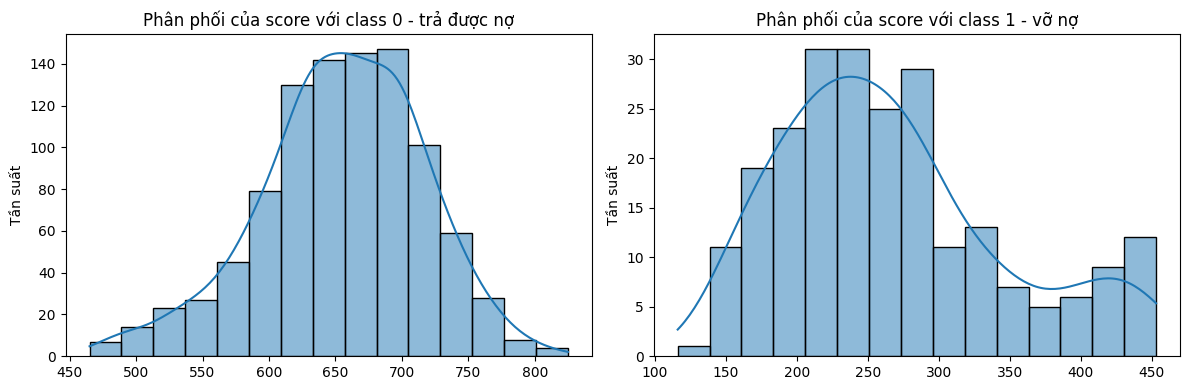

In [330]:
class1 = X_test_2_xgb[X_test_2_xgb["BAD"] == 1]
class0 = X_test_2_xgb[X_test_2_xgb["BAD"] == 0]
distribution_score(class0, class1)

In [331]:
X_train_2

LOAN  MORTDUE     VALUE   YOJ  DEROG  DELINQ       CLAGE  NINQ  CLNO  \
944    9100  62976.0   77829.0   0.0    0.0     2.0  131.193496   0.0  23.0   
5755  43800   5884.0   64890.0   7.0    0.0     0.0  309.827548   0.0  19.0   
2259  13800  75142.0   95667.0  19.0    0.0     0.0  230.457554  10.0  24.0   
12     2000  45000.0   55000.0   3.0    0.0     0.0   86.066667   2.0  25.0   
1117   9900  47367.0  114837.0   4.0    0.0     0.0  210.435534   0.0  10.0   
...     ...      ...       ...   ...    ...     ...         ...   ...   ...   
3772  20000  99300.0  139150.0  10.0    0.0     0.0  162.366667   1.0  23.0   
5191  28000  49764.0   74526.0  24.0    0.0     1.0  294.594783   1.0  30.0   
5226  28300  71973.0  119224.0   4.0    0.0     0.0   89.379952   2.0  32.0   
5390  31100  73386.0  108864.0   5.0    0.0     0.0  119.539518  10.0  21.0   
860    8700  77930.0   80164.0  20.0    0.0     0.0  350.528410   1.0  47.0   

        DEBTINC  REASON_DebtCon  REASON_HomeImp  JOB_Mgr  JOB_Office  \
944   26.090419           False            True     True       False   
5755  16.160451           False            True    False        True   
2259  33.383314            True           False     True       False   
12    38.000000           False            True    False       False   
1117  25.042109            True           False    False       False   
...         ...             ...             ...      ...         ...   
3772  34.000000           False            True    False       False   
5191  37.611309            True           False    False       False   
5226  39.981059            True           False    False       False   
5390  42.826601           False            True    False       False   
860   29.662360           False            True    False       False   

      JOB_Other  JOB_ProfExe  JOB_Sales  JOB_Self  
944       False        False      False     False  
5755      False        False      False     False  
2259      False        False      False     False  
12         True        False      False     False  
1117      False         True      False     False  
...         ...          ...        ...       ...  
3772      False         True      False     False  
5191       True        False      False     False  
5226       True        False      False     False  
5390       True        False      False     False  
860        True        False      False     False  

[4768 rows x 18 columns]

In [343]:
X_train_1.head()

LOAN   MORTDUE     VALUE       YOJ     DEROG    DELINQ     CLAGE  \
944  -0.864332 -0.246000 -0.419238 -1.197572 -0.306914  1.513170 -0.569306   
5755  2.287895 -1.549641 -0.646291  0.076786 -0.306914 -0.400147  1.517603   
2259 -0.437373  0.031799 -0.106218  1.351144 -0.306914 -0.400147  0.590356   
12   -1.509312 -0.656464 -0.819840 -0.795143 -0.306914 -0.400147 -1.096505   
1117 -0.791658 -0.602416  0.230176 -0.661000 -0.306914 -0.400147  0.356446   

          NINQ      CLNO   DEBTINC  REASON_DebtCon  REASON_HomeImp   JOB_Mgr  \
944  -0.696526  0.173827 -0.936585       -1.535807        1.535807  2.585942   
5755 -0.696526 -0.226879 -2.170359       -1.535807        1.535807 -0.386706   
2259  5.167532  0.274004 -0.030460        0.651123       -0.651123  2.585942   
12    0.476286  0.374180 -0.548648       -1.535807        1.535807 -0.386706   
1117 -0.696526 -1.128469 -1.066835        0.651123       -0.651123 -0.386706   

      JOB_Office  JOB_Other  JOB_ProfExe  JOB_Sales  JOB_Self  
944    -0.432149  -0.896244    -0.523116  -0.140297 -0.184564  
5755    2.314015  -0.896244    -0.523116  -0.140297 -0.184564  
2259   -0.432149  -0.896244    -0.523116  -0.140297 -0.184564  
12     -0.432149   1.115767    -0.523116  -0.140297 -0.184564  
1117   -0.432149  -0.896244     1.911622  -0.140297 -0.184564

In [344]:
X_train_2.head()

LOAN  MORTDUE     VALUE   YOJ  DEROG  DELINQ       CLAGE  NINQ  CLNO  \
944    9100  62976.0   77829.0   0.0    0.0     2.0  131.193496   0.0  23.0   
5755  43800   5884.0   64890.0   7.0    0.0     0.0  309.827548   0.0  19.0   
2259  13800  75142.0   95667.0  19.0    0.0     0.0  230.457554  10.0  24.0   
12     2000  45000.0   55000.0   3.0    0.0     0.0   86.066667   2.0  25.0   
1117   9900  47367.0  114837.0   4.0    0.0     0.0  210.435534   0.0  10.0   

        DEBTINC  REASON_DebtCon  REASON_HomeImp  JOB_Mgr  JOB_Office  \
944   26.090419           False            True     True       False   
5755  16.160451           False            True    False        True   
2259  33.383314            True           False     True       False   
12    38.000000           False            True    False       False   
1117  25.042109            True           False    False       False   

      JOB_Other  JOB_ProfExe  JOB_Sales  JOB_Self  
944       False        False      False     False  
5755      False        False      False     False  
2259      False        False      False     False  
12         True        False      False     False  
1117      False         True      False     False

In [342]:
X_train_3.head()

LOAN  MORTDUE     VALUE   YOJ  DEROG  DELINQ       CLAGE  NINQ  CLNO  \
944    9100  62976.0   77829.0   0.0    0.0     2.0  131.193496   0.0  23.0   
5755  43800   5884.0   64890.0   7.0    0.0     0.0  309.827548   0.0  19.0   
2259  13800  75142.0   95667.0  19.0    0.0     0.0  230.457554  10.0  24.0   
12     2000  45000.0   55000.0   3.0    0.0     0.0   86.066667   2.0  25.0   
1117   9900  47367.0  114837.0   4.0    0.0     0.0  210.435534   0.0  10.0   

        DEBTINC  REASON_DebtCon  REASON_HomeImp  JOB_Mgr  JOB_Office  \
944   26.090419           False            True     True       False   
5755  16.160451           False            True    False        True   
2259  33.383314            True           False     True       False   
12    38.000000           False            True    False       False   
1117  25.042109            True           False    False       False   

      JOB_Other  JOB_ProfExe  JOB_Sales  JOB_Self  
944       False        False      False     False  
5755      False        False      False     False  
2259      False        False      False     False  
12         True        False      False     False  
1117      False         True      False     False

In [341]:
X_train_4.head()

LOAN   MORTDUE     VALUE           YOJ     DEROG    DELINQ  \
944  -0.863774 -0.254054 -0.421384 -1.227598e+00 -0.284728  1.571082   
5755  2.288149 -1.586279 -0.649309 -2.439702e-16 -0.284728 -0.370828   
2259 -0.436856  0.029836 -0.107162  1.381920e+00 -0.284728 -0.370828   
12   -1.508692 -0.673519 -0.823524 -8.155685e-01 -0.284728 -0.370828   
1117 -0.791107 -0.618286  0.230524 -6.782255e-01 -0.284728 -0.370828   

         CLAGE      NINQ      CLNO   DEBTINC  REASON_DebtCon  REASON_HomeImp  \
944  -0.576078 -0.712405  0.175932 -1.014463       -1.536266        1.536266   
5755  1.539203 -0.712405 -0.228169 -2.345107       -1.536266        1.536266   
2259  0.599349  5.283326  0.276957 -0.037195        0.650929       -0.650929   
12   -1.110444  0.486741  0.377982  0.000000       -1.536266        1.536266   
1117  0.362260 -0.712405 -1.137394 -1.154940        0.650929       -0.650929   

       JOB_Mgr  JOB_Office  JOB_Other  JOB_ProfExe  JOB_Sales  JOB_Self  
944   2.586566   -0.432042  -0.896666    -0.522976  -0.140267 -0.184524  
5755 -0.386613    2.314591  -0.896666    -0.522976  -0.140267 -0.184524  
2259  2.586566   -0.432042  -0.896666    -0.522976  -0.140267 -0.184524  
12   -0.386613   -0.432042   1.115242    -0.522976  -0.140267 -0.184524  
1117 -0.386613   -0.432042  -0.896666     1.912132  -0.140267 -0.184524

In [340]:
X_train_5.head()

LOAN     VALUE        YOJ  DEROG  DELINQ       CLAGE  NINQ  CLNO  \
944    9100   77829.0   0.000000    0.0     2.0  131.193496   0.0  23.0   
5755  43800   64890.0   8.938187    0.0     0.0  309.827548   0.0  19.0   
2259  13800   95667.0  19.000000    0.0     0.0  230.457554  10.0  24.0   
12     2000   55000.0   3.000000    0.0     0.0   86.066667   2.0  25.0   
1117   9900  114837.0   4.000000    0.0     0.0  210.435534   0.0  10.0   

        DEBTINC  REASON_DebtCon  REASON_HomeImp  JOB_Mgr  JOB_Office  \
944   26.090419           False            True     True       False   
5755  16.160451           False            True    False        True   
2259  33.383314            True           False     True       False   
12    33.660883           False            True    False       False   
1117  25.042109            True           False    False       False   

      JOB_Other  JOB_ProfExe  JOB_Sales  JOB_Self  
944       False        False      False     False  
5755      False        False      False     False  
2259      False        False      False     False  
12         True        False      False     False  
1117      False         True      False     False

In [339]:
X_train_6.head()

LOAN  MORTDUE     VALUE        YOJ  DEROG  DELINQ       CLAGE  NINQ  \
944    9100  62976.0   77829.0   0.000000    0.0     2.0  131.193496   0.0   
5755  43800   5884.0   64890.0   8.938187    0.0     0.0  309.827548   0.0   
2259  13800  75142.0   95667.0  19.000000    0.0     0.0  230.457554  10.0   
12     2000  45000.0   55000.0   3.000000    0.0     0.0   86.066667   2.0   
1117   9900  47367.0  114837.0   4.000000    0.0     0.0  210.435534   0.0   

      CLNO    DEBTINC  REASON_DebtCon  REASON_HomeImp  JOB_Mgr  JOB_Office  \
944   23.0  26.090419           False            True     True       False   
5755  19.0  16.160451           False            True    False        True   
2259  24.0  33.383314            True           False     True       False   
12    25.0  33.660883           False            True    False       False   
1117  10.0  25.042109            True           False    False       False   

      JOB_Other  JOB_ProfExe  JOB_Sales  JOB_Self  
944       False        False      False     False  
5755      False        False      False     False  
2259      False        False      False     False  
12         True        False      False     False  
1117      False         True      False     False

In [338]:
X_train_7.head()

LOAN   MORTDUE     VALUE       YOJ    DEROG    DELINQ     CLAGE  \
944  -0.854793 -0.248756 -0.494734 -1.193080 -0.28801  1.620352 -0.548136   
2259 -0.426686  0.020339 -0.169856  1.284805 -0.28801 -0.370247  0.629042   
12   -1.501507 -0.646360 -0.910513 -0.801835 -0.28801 -0.370247 -1.083298   
1117 -0.781924 -0.594006  0.179282 -0.671420 -0.28801 -0.370247  0.391600   
4333  0.365767  0.017420  0.178044 -0.019345 -0.28801  0.625053  1.386120   

          NINQ      CLNO  REASON_DebtCon  REASON_HomeImp   JOB_Mgr  \
944  -0.694403  0.106292       -1.485292        1.561115  2.534410   
2259  5.238197  0.210889        0.673268       -0.640568  2.534410   
12    0.492117  0.315486       -1.485292        1.561115 -0.394569   
1117 -0.694403 -1.253468        0.673268       -0.640568 -0.394569   
4333 -0.101143  0.629277        0.673268       -0.640568  2.534410   

      JOB_Office  JOB_Other  JOB_ProfExe  JOB_Sales  JOB_Self  
944    -0.437579  -0.784442    -0.582729  -0.136025 -0.178931  
2259   -0.437579  -0.784442    -0.582729  -0.136025 -0.178931  
12     -0.437579   1.274791    -0.582729  -0.136025 -0.178931  
1117   -0.437579  -0.784442     1.716063  -0.136025 -0.178931  
4333   -0.437579  -0.784442    -0.582729  -0.136025 -0.178931

In [347]:
X_test_2_xgb.iloc[:, 9:]

DEBTINC  REASON_DebtCon  REASON_HomeImp  JOB_Mgr  JOB_Office  \
1344  37.792555            True           False    False        True   
625   35.906116            True           False    False       False   
5908  43.368718           False            True    False        True   
2991  29.153372           False            True    False       False   
1545  39.008673           False            True    False        True   
...         ...             ...             ...      ...         ...   
3688  43.338407            True           False    False        True   
2404  31.547812            True           False    False       False   
1173  35.000000            True           False    False       False   
3209  28.662173            True           False     True       False   
2728  38.723895            True           False    False        True   

      JOB_Other  JOB_ProfExe  JOB_Sales  JOB_Self  BAD       PRO  SCORE  \
1344      False        False      False     False    0  0.041434    572   
625        True        False      False     False    0  0.016675    606   
5908      False        False      False     False    0  0.144163    523   
2991       True        False      False     False    0  0.000177    770   
1545      False        False      False     False    0  0.003237    666   
...         ...          ...        ...       ...  ...       ...    ...   
3688      False        False      False     False    0  0.008127    632   
2404       True        False      False     False    0  0.009120    628   
1173      False         True      False     False    0  0.048063    567   
3209      False        False      False     False    0  0.003227    666   
2728      False        False      False     False    0  0.008546    630   

        RISK  
1344  medium  
625   medium  
5908  medium  
2991   lower  
1545  medium  
...      ...  
3688  medium  
2404  medium  
1173  medium  
3209  medium  
2728  medium  

[1192 rows x 13 columns]